# Black box
Odchudzone z dodatkowych wizualizacji - wiele powtarza się w pliku z interpretowalnym modelem

# Część 1

In [ ]:
# Standardowe biblioteki i ustawienia
import os
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from scipy import stats, mstats
from scipy.stats import beta as beta_dist
from scipy.special import expit, logit
from scipy.optimize import minimize

warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

# Preprocessing i Inżynieria Cech (Feature Engineering)
from sklearn.experimental import enable_iterative_imputer # Wymagane dla IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PowerTransformer
)
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE

# Wybór i Walidacja Modeli
from sklearn.model_selection import (
    TimeSeriesSplit,
    train_test_split
)

# Modele
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    IsolationForest
)
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier
import shap
import lime.lime_tabular

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    roc_curve,
    confusion_matrix
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.inspection import PartialDependenceDisplay

# Statystyka i Wpływ
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import lime
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

import optuna
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate
)
import joblib

In [7]:
df = pd.read_csv('zbior_10.csv')
target_col = 'default' 

X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
def full_feature_engineering(df):
    df_new = df.copy()

    def safe_div(a, b):
        return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b != 0)

    if 'pkdKod' in df_new.columns:
        temp_pkd = df_new['pkdKod'].fillna(0).astype(int).astype(str)
        df_new['PKD_Dzial'] = temp_pkd.str[:2].astype('category')

    zob_krotkie = df_new['Zobowiazania_krotkoterminowe'].fillna(0)
    zob_dlugie = df_new['Zobowiazania_dlugoterminowe'].fillna(0)
    zob_total = zob_krotkie + zob_dlugie
    aktywa = df_new['Aktywa']
    przychody = df_new['przychody']

    df_new['New_Current_Ratio'] = safe_div(df_new['Aktywa_obrotowe'], zob_krotkie)
    df_new['New_Cash_Ratio'] = safe_div(df_new['Srodki_pieniezne'], zob_krotkie)
    df_new['New_Debt_Ratio'] = safe_div(zob_total, aktywa)
    df_new['New_Equity_Multiplier'] = safe_div(aktywa, df_new['Kapital_wlasny'])

    df_new['New_ROA'] = safe_div(df_new['Zysk_netto'], aktywa)
    df_new['New_ROS'] = safe_div(df_new['Zysk_netto'], przychody)
    df_new['New_Op_Margin'] = safe_div(df_new['zysk_operacyjny'], przychody)
    df_new['New_Asset_Turnover'] = safe_div(przychody, aktywa)
    df_new['New_Receivables_Cycle'] = safe_div(df_new['Naleznosci_krotkoterminowe'], przychody)

    for col in ['Aktywa', 'przychody', 'zysk_brutto']:
        if col in df_new.columns:
            df_new[f'Log_{col}'] = np.log1p(df_new[col].clip(lower=0)).astype('float32')

    ebitda = df_new['zysk_operacyjny'].fillna(0) + df_new['amortyzacja'].fillna(0)
    df_new['Calc_EBITDA'] = ebitda
    df_new['Ratio_Interest_Coverage'] = safe_div(ebitda, df_new['koszty_odsetki'].fillna(0))

    net_debt = zob_total - df_new['Srodki_pieniezne'].fillna(0)
    df_new['Ratio_NetDebt_EBITDA'] = safe_div(net_debt, ebitda)
    df_new['Log_EBITDA'] = np.log1p(ebitda.clip(lower=0)).astype('float32')

    koszty_op = df_new['koszty_operacyjne']
    df_new['Cycle_Receivables'] = safe_div(df_new['Naleznosci_krotkoterminowe'], przychody)
    df_new['Cycle_Inventory'] = safe_div(df_new['Zapasy'], koszty_op)
    df_new['Cycle_Payables'] = safe_div(zob_krotkie, koszty_op)
    df_new['Cycle_Gap'] = df_new['Cycle_Payables'] - df_new['Cycle_Receivables']

    permanent_capital = df_new['Kapital_wlasny'].fillna(0) + zob_dlugie
    df_new['Rule_Golden'] = safe_div(permanent_capital, df_new['Aktywa_trwale'])
    df_new['Structure_Debt_LongTerm'] = safe_div(zob_dlugie, zob_total)

    rel_receivables = (df_new['Naleznosci_dostaw_uslug_12m_powiazane'].fillna(0) + 
                       df_new['Naleznosci_dostaw_uslug_pow12m_powiazane'].fillna(0))
    df_new['Risk_Related_Receivables'] = safe_div(rel_receivables, aktywa)

    rel_payables = (df_new['Zobowiazania_dostaw_uslug_12m_powiazane'].fillna(0) + 
                    df_new['Zobowiazania_dostaw_uslug_pow12m_powiazane'].fillna(0))
    df_new['Risk_Related_Payables'] = safe_div(rel_payables, zob_total)

    nwc = df_new['Aktywa_obrotowe'] - zob_krotkie
    df_new['Altman_T1_WorkingCapital'] = safe_div(nwc, aktywa)
    df_new['Structure_Retained_Earnings'] = safe_div(df_new['Kapital_zapasowy'].fillna(0), df_new['Kapital_wlasny'])

    trade_receivables = (df_new['Naleznosci_dostaw_uslug_12m'].fillna(0) + df_new['Naleznosci_dostaw_uslug_pow12m'].fillna(0))
    trade_payables = (df_new['Zobowiazania_dostaw_uslug_12m'].fillna(0) + df_new['Zobowiazania_dostaw_uslug_pow12m'].fillna(0))
    df_new['Ratio_Trade_Financing'] = safe_div(trade_payables, trade_receivables)

    df_new['Ratio_Overhead_Burden'] = safe_div(df_new['koszty_ogolnego_zarzadu'], przychody)
    df_new['Ratio_Effective_Tax'] = safe_div(df_new['podatek_dochodowy'], df_new['zysk_brutto'])
    df_new['Structure_Intangibles'] = safe_div(df_new['Wartosci_niematerialne_prawne'], aktywa)
    df_new['Ratio_FinCost_Coverage'] = safe_div(df_new['zysk_operacyjny'], df_new['koszty_finansowe'])
    
    df_new['Ratio_Legal_Proceedings'] = safe_div(
        df_new['Naleznosci_dostaw_uslug_pozostale_sadowe'].fillna(0), aktywa
    )

    total_receivables = df_new['Naleznosci_dlugoterminowe'].fillna(0) + df_new['Naleznosci_krotkoterminowe'].fillna(0)
    df_new['Structure_Receivables_Long'] = safe_div(df_new['Naleznosci_dlugoterminowe'].fillna(0), total_receivables)

    liquid_assets = df_new['Srodki_pieniezne'].fillna(0) + df_new['Naleznosci_krotkoterminowe'].fillna(0)
    df_new['Structure_Liquidity_Share'] = safe_div(liquid_assets, aktywa)

    related_party_vol = (df_new['Naleznosci_dostaw_uslug_12m_powiazane'].fillna(0) + 
                         df_new['Zobowiazania_dostaw_uslug_12m_powiazane'].fillna(0))
    df_new['Dependency_Related_Parties'] = safe_div(related_party_vol, aktywa)

    
    df_new['Flag_No_Revenue'] = (przychody <= 0).astype('int8')

    obj_cols = df_new.select_dtypes(include=['object']).columns
    df_new[obj_cols] = df_new[obj_cols].astype('category')

    float_cols = df_new.select_dtypes(include=['float64']).columns
    df_new[float_cols] = df_new[float_cols].astype('float32')

    return df_new

X_fin = full_feature_engineering(X)

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_fin, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print(f"{X_train.shape}")
print(f"{X_val.shape}")
print(f"{X_test.shape}")

(1800, 256)
(600, 256)
(600, 256)


In [ ]:
def advanced_preprocessing(X_train, X_test, X_val, use_svd=True, vif_threshold=10.0):
    print("Rozpoczynam zaawansowane przetwarzanie danych...")
    
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()
    X_val_proc = X_val.copy()

    numeric_cols = X_train_proc.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_train_proc.select_dtypes(exclude=[np.number]).columns.tolist()

    for df in [X_train_proc, X_test_proc, X_val_proc]:
        df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    
    print(f"  Imputacja braków danych (IterativeImputer) dla {len(numeric_cols)} kolumn...")
    imputer = IterativeImputer(max_iter=10, random_state=42, initial_strategy='median')
    
    # Fit tylko na Train
    X_train_proc[numeric_cols] = imputer.fit_transform(X_train_proc[numeric_cols])
    X_test_proc[numeric_cols] = imputer.transform(X_test_proc[numeric_cols])
    X_val_proc[numeric_cols] = imputer.transform(X_val_proc[numeric_cols])

    print("  Winsoryzacja i transformacja Yeo-Johnson...")
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    
    # Winsoryzacja
    for col in numeric_cols:
        q_low = X_train_proc[col].quantile(0.01)
        q_high = X_train_proc[col].quantile(0.99)
        if q_high > q_low:
            X_train_proc[col] = np.clip(X_train_proc[col], q_low, q_high)
            X_test_proc[col] = np.clip(X_test_proc[col], q_low, q_high)
            X_val_proc[col] = np.clip(X_val_proc[col], q_low, q_high)

    X_train_proc[numeric_cols] = pt.fit_transform(X_train_proc[numeric_cols])
    X_test_proc[numeric_cols] = pt.transform(X_test_proc[numeric_cols])
    X_val_proc[numeric_cols] = pt.transform(X_val_proc[numeric_cols])


    iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)
    iso.fit(X_train_proc[numeric_cols])
    
    X_train_proc['Anomaly_Score'] = iso.decision_function(X_train_proc[numeric_cols])
    X_test_proc['Anomaly_Score'] = iso.decision_function(X_test_proc[numeric_cols])
    X_val_proc['Anomaly_Score'] = iso.decision_function(X_val_proc[numeric_cols])
    
    pca_lev = PCA(n_components=10)
    pca_lev.fit(X_train_proc[numeric_cols])
    
    def get_leverage_proxy(data, pca_model):
        X_pca = pca_model.transform(data)
        return np.sum(X_pca**2, axis=1)

    X_train_proc['Leverage_Proxy'] = get_leverage_proxy(X_train_proc[numeric_cols], pca_lev)
    X_test_proc['Leverage_Proxy'] = get_leverage_proxy(X_test_proc[numeric_cols], pca_lev)
    X_val_proc['Leverage_Proxy'] = get_leverage_proxy(X_val_proc[numeric_cols], pca_lev)
    
    numeric_cols.extend(['Anomaly_Score', 'Leverage_Proxy'])
    print(f"  Analiza VIF (próg={vif_threshold})...")
    
    
    cols_to_keep = numeric_cols.copy()
    X_vif_sample = X_train_proc[cols_to_keep].sample(min(5000, len(X_train_proc)), random_state=42)
    X_vif_sample = sm.add_constant(X_vif_sample)
    
    drop_vif = True
    while drop_vif and len(cols_to_keep) > 5:
        vifs = pd.Series(
            [variance_inflation_factor(X_vif_sample[cols_to_keep].values, i) 
             for i in range(len(cols_to_keep))],
            index=cols_to_keep
        )
        max_vif = vifs.max()
        if max_vif > vif_threshold:
            feature_to_drop = vifs.idxmax()
            print(f"    Usuwanie zmiennej z VIF={max_vif:.2f}: {feature_to_drop}")
            cols_to_keep.remove(feature_to_drop)
            X_vif_sample = X_vif_sample.drop(columns=[feature_to_drop])
        else:
            drop_vif = False
            
    print(f"  Pozostawiono {len(cols_to_keep)} zmiennych numerycznych po selekcji VIF.")
    
    final_cols = cols_to_keep + cat_cols
    X_train_final = X_train_proc[final_cols].copy()
    X_test_final = X_test_proc[final_cols].copy()
    X_val_final = X_val_proc[final_cols].copy()

    if use_svd:
        print("  Dodawanie cech latentnych (SVD/PCA) - Wykład I...")
        pca = PCA(n_components=3)
        X_pca_train = pca.fit_transform(X_train_proc[numeric_cols])
        X_pca_test = pca.transform(X_test_proc[numeric_cols])
        X_pca_val = pca.transform(X_val_proc[numeric_cols])
        
        for i in range(3):
            col_name = f'Latent_SVD_Component_{i+1}'
            X_train_final[col_name] = X_pca_train[:, i]
            X_test_final[col_name] = X_pca_test[:, i]
            X_val_final[col_name] = X_pca_val[:, i]

    return X_train_final, X_test_final, X_val_final

Rozpoczynam zaawansowane przetwarzanie danych...
  Imputacja braków danych (IterativeImputer) dla 253 kolumn...
  Winsoryzacja i transformacja Yeo-Johnson...
  Generowanie cech anomalii i Leverage...
  Analiza VIF (próg=10.0)...
    Usuwanie zmiennej z VIF=inf: wsk_ROS
    Usuwanie zmiennej z VIF=inf: wsk_zysk_op_zobowiazania
    Usuwanie zmiennej z VIF=inf: wsk_koszty_przychody
    Usuwanie zmiennej z VIF=inf: wsk_koszty_fin_przychody
    Usuwanie zmiennej z VIF=inf: wsk_koszty_odsetki_przychody
    Usuwanie zmiennej z VIF=inf: wsk_udzial_kap_wlasnego_aktywa_1
    Usuwanie zmiennej z VIF=inf: wsk_ebitda_koszty_odsetkowe_1
    Usuwanie zmiennej z VIF=inf: wsk_ebitda_koszty_odsetkowe_2
    Usuwanie zmiennej z VIF=inf: New_Receivables_Cycle
    Usuwanie zmiennej z VIF=4381470518.15: wsk_pokrycie_aktywow_kap_stalym
    Usuwanie zmiennej z VIF=599361820.86: wsk_zadluzenie_kap_wlasnego
    Usuwanie zmiennej z VIF=47309.92: wsk_struktura_kap_wlasnego_2
    Usuwanie zmiennej z VIF=12129.08: w

In [ ]:
X_train_final, X_test_final, X_val_final = advanced_preprocessing(X_train, X_test, X_val)

print(f"Finalny kształt X_train: {X_train_final.shape}")
print(f"Finalne kolumny: {X_train_final.columns.tolist()}")


##### dodatkowy kod na potem - żeby nie trzeba było szukać funkcji do ładowania i metryk

In [2]:
def save_best_params(params_dict, model_name, filepath=None):
    if filepath is None:
        filepath = f'best_params_{model_name}_tuned.json'
    
    params_serializable = {}
    for key, value in params_dict.items():
        if isinstance(value, (np.integer, np.int64, np.int32)):
            params_serializable[key] = int(value)
        elif isinstance(value, (np.floating, np.float64, np.float32)):
            params_serializable[key] = float(value)
        else:
            params_serializable[key] = value
    
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(params_serializable, f, indent=4, ensure_ascii=False)
    
    print(f"✓ Zapisano parametry {model_name} do: {filepath}")
    return filepath

def load_best_params(model_name, filepath=None):

    if filepath is None:
        filepath = f'best_params_{model_name}_tuned.json'
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            params = json.load(f)
        print(f"✓ Wczytano parametry {model_name} z: {filepath}")
        return params
    except FileNotFoundError:
        print(f"✗ Nie znaleziono pliku: {filepath}")
        return None
    except json.JSONDecodeError as e:
        print(f"✗ Błąd w parsowaniu JSON: {e}")
        return None

print("Funkcje save_best_params() i load_best_params() zostały zdefiniowane.")

Funkcje save_best_params() i load_best_params() zostały zdefiniowane.


In [3]:
def evaluate_model(y_true, y_pred_proba, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    ks_statistic = max(tpr - fpr)
    
    logloss = log_loss(y_true, y_pred_proba)
    
    brier = brier_score_loss(y_true, y_pred_proba)
    
    results = {
        'Model': model_name,
        'AUC-ROC': roc_auc,
        'PR-AUC': pr_auc,
        'KS Statistic': ks_statistic,
        'Log Loss': logloss,
        'Brier Score': brier
    }
    
    return results

def print_evaluation(results):
    print("=" * 70)
    print(f"WYNIKI EWALUACJI: {results['Model']}")
    print("=" * 70)
    print(f"AUC-ROC:       {results['AUC-ROC']:.4f}")
    print(f"PR-AUC:        {results['PR-AUC']:.4f}")
    print(f"KS Statistic:  {results['KS Statistic']:.4f}")
    print(f"Log Loss:      {results['Log Loss']:.4f}")
    print(f"Brier Score:   {results['Brier Score']:.4f}")
    print("=" * 70)


# Część 2
Trenowanie modeli Black                                                                                                                         Box                                                                                                                                                                                                                                                                                                     

### Trenowanie

#### LightGMB

In [1]:
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Trenowanie LightGBM...")
lgbm_model.fit(X_train_final, y_train)

y_pred_proba_lgbm_train = lgbm_model.predict_proba(X_train_final)[:, 1]
y_pred_proba_lgbm_val = lgbm_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_lgbm_test = lgbm_model.predict_proba(X_test_final)[:, 1]


results_lgbm_train = evaluate_model(y_train, y_pred_proba_lgbm_train, model_name="LightGBM (Train)")
print_evaluation(results_lgbm_train)

results_lgbm_val = evaluate_model(y_val, y_pred_proba_lgbm_val, model_name="LightGBM (Val)")
print_evaluation(results_lgbm_val)

results_lgbm_test = evaluate_model(y_test, y_pred_proba_lgbm_test, model_name="LightGBM (Test)")
print_evaluation(results_lgbm_test)


NameError: name 'LGBMClassifier' is not defined

#### XGBoost

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    enable_categorical=True
)

print("Trenowanie XGBoost...")
xgb_model.fit(X_train_final, y_train)

y_pred_proba_xgb_train = xgb_model.predict_proba(X_train_final)[:, 1]
y_pred_proba_xgb_val = xgb_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_xgb_test = xgb_model.predict_proba(X_test_final)[:, 1]


results_xgb_train = evaluate_model(y_train, y_pred_proba_xgb_train, model_name="XGBoost (Train)")
print_evaluation(results_xgb_train)

results_xgb_val = evaluate_model(y_val, y_pred_proba_xgb_val, model_name="XGBoost (Val)")
print_evaluation(results_xgb_val)

results_xgb_test = evaluate_model(y_test, y_pred_proba_xgb_test, model_name="XGBoost (Test)")
print_evaluation(results_xgb_test)

Trenowanie XGBoost...
WYNIKI EWALUACJI: XGBoost (Train)
AUC-ROC:       0.9995
PR-AUC:        0.9929
KS Statistic:  0.9820
Log Loss:      0.0658
Brier Score:   0.0151
WYNIKI EWALUACJI: XGBoost (Val)
AUC-ROC:       0.7592
PR-AUC:        0.2228
KS Statistic:  0.4540
Log Loss:      0.2098
Brier Score:   0.0541
WYNIKI EWALUACJI: XGBoost (Test)
AUC-ROC:       0.7595
PR-AUC:        0.1369
KS Statistic:  0.5089
Log Loss:      0.2146
Brier Score:   0.0556


#### SVM

In [ ]:
cat_cols = X_train_final.select_dtypes(include=['object', 'category']).columns
num_cols = X_train_final.select_dtypes(exclude=['object', 'category']).columns

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    (StandardScaler(), num_cols),
    verbose_feature_names_out=False
)

svm_pipeline = make_pipeline(
    preprocessor,
    SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
)

print("Trenowanie SVM...")
svm_pipeline.fit(X_train_final, y_train)

y_pred_proba_svm_train = svm_pipeline.predict_proba(X_train_final)[:, 1]
y_pred_proba_svm_val = svm_pipeline.predict_proba(X_val_final)[:, 1]
y_pred_proba_svm_test = svm_pipeline.predict_proba(X_test_final)[:, 1]

results_svm_train = evaluate_model(y_train, y_pred_proba_svm_train, model_name="SVM (Train)")
print_evaluation(results_svm_train)

results_svm_val = evaluate_model(y_val, y_pred_proba_svm_val, model_name="SVM (Val)")
print_evaluation(results_svm_val)

results_svm_test = evaluate_model(y_test, y_pred_proba_svm_test, model_name="SVM (Test)")
print_evaluation(results_svm_test)

Trenowanie SVM...
WYNIKI EWALUACJI: SVM (Train)
AUC-ROC:       0.9731
PR-AUC:        0.9365
KS Statistic:  0.9196
Log Loss:      0.1299
Brier Score:   0.0305
WYNIKI EWALUACJI: SVM (Val)
AUC-ROC:       0.7234
PR-AUC:        0.2205
KS Statistic:  0.3595
Log Loss:      0.2108
Brier Score:   0.0544
WYNIKI EWALUACJI: SVM (Test)
AUC-ROC:       0.6802
PR-AUC:        0.1198
KS Statistic:  0.3056
Log Loss:      0.2154
Brier Score:   0.0551


### Porównanie wszystkich modeli


PORÓWNANIE WSZYSTKICH MODELI (TRAIN, VAL, TEST)
           Model  AUC-ROC   PR-AUC  KS Statistic  Log Loss  Brier Score
LightGBM (Train) 0.998518 0.984166      0.956213  0.065375     0.014790
  LightGBM (Val) 0.748788 0.152916      0.480438  0.218309     0.056311
 LightGBM (Test) 0.771474 0.170031      0.494090  0.210394     0.054546
 XGBoost (Train) 0.999478 0.992889      0.982033  0.065772     0.015115
   XGBoost (Val) 0.759205 0.222775      0.454035  0.209782     0.054113
  XGBoost (Test) 0.759456 0.136914      0.508865  0.214558     0.055550
     SVM (Train) 0.973147 0.936478      0.919580  0.129909     0.030538
       SVM (Val) 0.723393 0.220499      0.359512  0.210835     0.054433
      SVM (Test) 0.680162 0.119837      0.305556  0.215437     0.055053


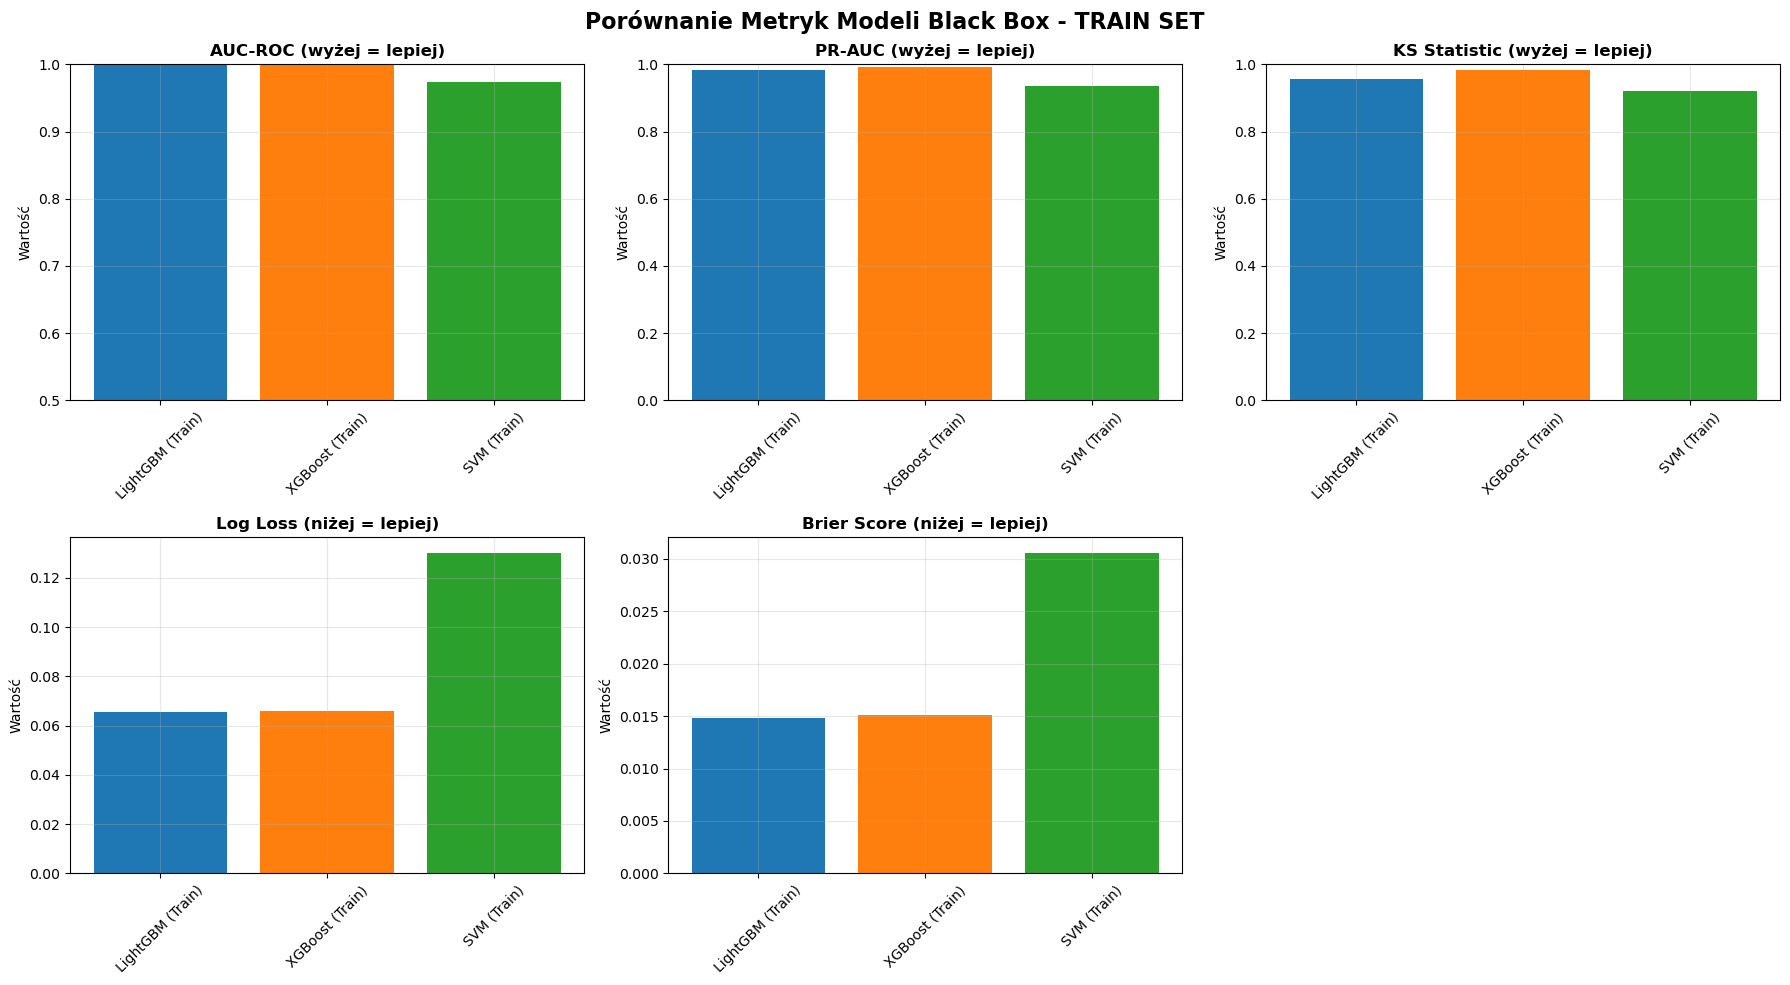

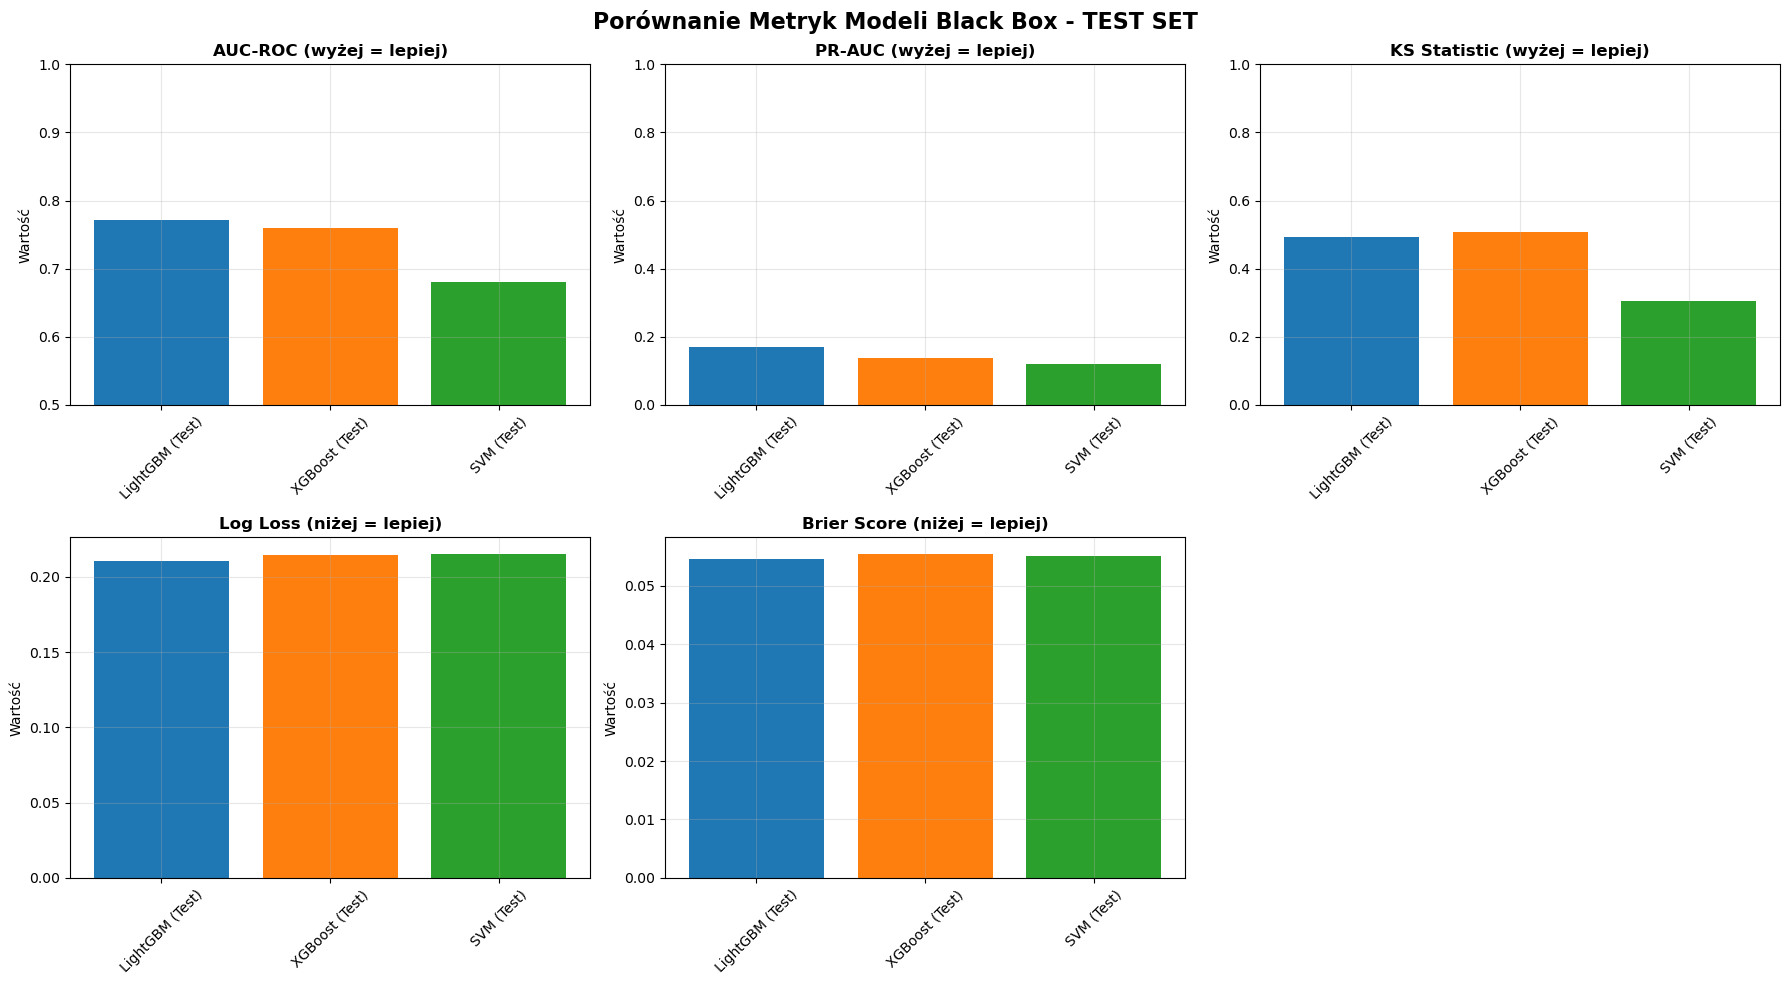

In [ ]:
all_results_train = [results_lgbm_train, results_xgb_train, results_svm_train]
all_results_test = [results_lgbm_test, results_xgb_test, results_svm_test]
comparison_df_train = pd.DataFrame(all_results_train)
comparison_df_test = pd.DataFrame(all_results_test)

all_results_detailed = [
    results_lgbm_train, results_lgbm_val, results_lgbm_test,
    results_xgb_train, results_xgb_val, results_xgb_test,
    results_svm_train, results_svm_val, results_svm_test
]
comparison_df_detailed = pd.DataFrame(all_results_detailed)


print(comparison_df_detailed.to_string(index=False))

# Wizualizacja porównania - TRAIN SET
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Porównanie Metryk Modeli Black Box - TRAIN SET', fontsize=16, fontweight='bold')

metrics = ['AUC-ROC', 'PR-AUC', 'KS Statistic', 'Log Loss', 'Brier Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# AUC-ROC
axes[0, 0].bar(comparison_df_train['Model'], comparison_df_train['AUC-ROC'], color=colors)
axes[0, 0].set_title('AUC-ROC (wyżej = lepiej)', fontweight='bold')
axes[0, 0].set_ylabel('Wartość')
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# PR-AUC
axes[0, 1].bar(comparison_df_train['Model'], comparison_df_train['PR-AUC'], color=colors)
axes[0, 1].set_title('PR-AUC (wyżej = lepiej)', fontweight='bold')
axes[0, 1].set_ylabel('Wartość')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# KS Statistic
axes[0, 2].bar(comparison_df_train['Model'], comparison_df_train['KS Statistic'], color=colors)
axes[0, 2].set_title('KS Statistic (wyżej = lepiej)', fontweight='bold')
axes[0, 2].set_ylabel('Wartość')
axes[0, 2].set_ylim([0, 1.0])
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Log Loss
axes[1, 0].bar(comparison_df_train['Model'], comparison_df_train['Log Loss'], color=colors)
axes[1, 0].set_title('Log Loss (niżej = lepiej)', fontweight='bold')
axes[1, 0].set_ylabel('Wartość')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Brier Score
axes[1, 1].bar(comparison_df_train['Model'], comparison_df_train['Brier Score'], color=colors)
axes[1, 1].set_title('Brier Score (niżej = lepiej)', fontweight='bold')
axes[1, 1].set_ylabel('Wartość')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Ukryj ostatni subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Wizualizacja porównania - TEST SET
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Porównanie Metryk Modeli Black Box - TEST SET', fontsize=16, fontweight='bold')

# AUC-ROC
axes[0, 0].bar(comparison_df_test['Model'], comparison_df_test['AUC-ROC'], color=colors)
axes[0, 0].set_title('AUC-ROC (wyżej = lepiej)', fontweight='bold')
axes[0, 0].set_ylabel('Wartość')
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# PR-AUC
axes[0, 1].bar(comparison_df_test['Model'], comparison_df_test['PR-AUC'], color=colors)
axes[0, 1].set_title('PR-AUC (wyżej = lepiej)', fontweight='bold')
axes[0, 1].set_ylabel('Wartość')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# KS Statistic
axes[0, 2].bar(comparison_df_test['Model'], comparison_df_test['KS Statistic'], color=colors)
axes[0, 2].set_title('KS Statistic (wyżej = lepiej)', fontweight='bold')
axes[0, 2].set_ylabel('Wartość')
axes[0, 2].set_ylim([0, 1.0])
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Log Loss
axes[1, 0].bar(comparison_df_test['Model'], comparison_df_test['Log Loss'], color=colors)
axes[1, 0].set_title('Log Loss (niżej = lepiej)', fontweight='bold')
axes[1, 0].set_ylabel('Wartość')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Brier Score
axes[1, 1].bar(comparison_df_test['Model'], comparison_df_test['Brier Score'], color=colors)
axes[1, 1].set_title('Brier Score (niżej = lepiej)', fontweight='bold')
axes[1, 1].set_ylabel('Wartość')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Ukryj ostatni subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Hipetruning parametryczny z kontrolą overfittingu

#### LightGBM - Optuna Tuning

In [ ]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.02, log=True),
        
        'max_depth': trial.suggest_int('max_depth', 2, 4), 
        'num_leaves': trial.suggest_int('num_leaves', 3, 10), 
        
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500),

        'min_split_gain': trial.suggest_float('min_split_gain', 0.5, 10.0),
        
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'bagging_freq': 1,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),
        
        'reg_alpha': trial.suggest_float('reg_alpha', 5.0, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 5.0, 100.0, log=True), 
        
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    try:
        model = LGBMClassifier(**params)
        model.fit(X_train_final, y_train)
        
        y_pred_train = model.predict_proba(X_train_final)[:, 1]
        y_pred_test = model.predict_proba(X_test_final)[:, 1]
        
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        penalty_weight = 0.5 
        score = auc_test - penalty_weight * abs(auc_train - auc_test)
        
        return score
    except Exception as e:
        print(f"  Error in trial: {str(e)}")
        return -np.inf

sampler_lgbm = optuna.samplers.TPESampler(seed=42)
pruner_lgbm = MedianPruner()
study_lgbm = optuna.create_study(sampler=sampler_lgbm, pruner=pruner_lgbm, direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100, show_progress_bar=False)

print(f"\nNajlepszy wynik LightGBM: {study_lgbm.best_value:.6f}")
print("Najlepsze parametry LightGBM:")
lgbm_best_params = study_lgbm.best_params
for param, value in lgbm_best_params.items():
    print(f"  {param}: {value}")

lgbm_tuned = LGBMClassifier(
    n_estimators=int(lgbm_best_params['n_estimators']),
    learning_rate=lgbm_best_params['learning_rate'],
    max_depth=int(lgbm_best_params['max_depth']),
    num_leaves=int(lgbm_best_params['num_leaves']),
    min_child_samples=int(lgbm_best_params['min_child_samples']),
    min_split_gain=lgbm_best_params['min_split_gain'],
    subsample=lgbm_best_params['subsample'],
    bagging_freq=1,
    colsample_bytree=lgbm_best_params['colsample_bytree'],
    reg_lambda=lgbm_best_params['reg_lambda'],
    reg_alpha=lgbm_best_params['reg_alpha'],
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_tuned.fit(X_train_final, y_train)

y_pred_lgbm_train_tuned = lgbm_tuned.predict_proba(X_train_final)[:, 1]
y_pred_lgbm_val_tuned = lgbm_tuned.predict_proba(X_val_final)[:, 1]
y_pred_lgbm_test_tuned = lgbm_tuned.predict_proba(X_test_final)[:, 1]

results_lgbm_train_tuned = evaluate_model(y_train, y_pred_lgbm_train_tuned, "LightGBM Tuned (Train)")
results_lgbm_val_tuned = evaluate_model(y_val, y_pred_lgbm_val_tuned, "LightGBM Tuned (Val)")
results_lgbm_test_tuned = evaluate_model(y_test, y_pred_lgbm_test_tuned, "LightGBM Tuned (Test)")


print("\nWyniki LightGBM Tuned:")
print_evaluation(results_lgbm_test_tuned)

print_evaluation(results_lgbm_train_tuned)
print_evaluation(results_lgbm_val_tuned)

[I 2025-12-08 23:50:20,018] A new study created in memory with name: no-name-ca3e5f48-74b5-4a35-8085-37559ea74d63


Rozpoczęto tuning LightGBM z Optuna (100 trials z silną kontrolą overfittingu)...


[I 2025-12-08 23:50:21,124] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 144, 'learning_rate': 0.017254716573280357, 'max_depth': 4, 'num_leaves': 7, 'min_child_samples': 162, 'min_split_gain': 1.981947943193925, 'subsample': 0.4174250836504598, 'colsample_bytree': 0.6598528437324805, 'reg_alpha': 30.271829277346235, 'reg_lambda': 41.705532161810446}. Best is trial 0 with value: 0.5.
[I 2025-12-08 23:50:21,441] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 55, 'learning_rate': 0.018276027831785738, 'max_depth': 4, 'num_leaves': 4, 'min_child_samples': 172, 'min_split_gain': 2.2423428436076214, 'subsample': 0.4912726728878613, 'colsample_bytree': 0.5574269294896713, 'reg_alpha': 18.23658142455605, 'reg_lambda': 11.963764382790318}. Best is trial 0 with value: 0.5.
[I 2025-12-08 23:50:21,441] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 55, 'learning_rate': 0.018276027831785738, 'max_depth': 4, 'num_leaves': 4, 'min_child_samp


Najlepszy wynik LightGBM: 0.766490
Najlepsze parametry LightGBM:
  n_estimators: 63
  learning_rate: 0.01693164434447474
  max_depth: 2
  num_leaves: 6
  min_child_samples: 180
  min_split_gain: 2.004526326861063
  subsample: 0.6214142234891638
  colsample_bytree: 0.4936295636271494
  reg_alpha: 10.020304956485493
  reg_lambda: 5.478573929338031

Wyniki LightGBM Tuned:
WYNIKI EWALUACJI: LightGBM Tuned (Test)
AUC-ROC:       0.7686
PR-AUC:        0.1353
KS Statistic:  0.5124
Log Loss:      0.2181
Brier Score:   0.0554
WYNIKI EWALUACJI: LightGBM Tuned (Train)
AUC-ROC:       0.7729
PR-AUC:        0.1554
KS Statistic:  0.4333
Log Loss:      0.2204
Brier Score:   0.0563
WYNIKI EWALUACJI: LightGBM Tuned (Val)
AUC-ROC:       0.7234
PR-AUC:        0.1277
KS Statistic:  0.4296
Log Loss:      0.2237
Brier Score:   0.0569


#### XGBoost - Optuna Tuning

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),
        'enable_categorical': True,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    try:
        model = XGBClassifier(**params)
        model.fit(X_train_final, y_train)
        
        y_pred_train = model.predict_proba(X_train_final)[:, 1]
        y_pred_test = model.predict_proba(X_test_final)[:, 1]
        
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        penalty_weight = 0.5 
        score = auc_test - penalty_weight * abs(auc_train - auc_test)
        
        return score
    except Exception as e:
        print(f"  Error in trial: {str(e)}")
        return -np.inf

sampler_xgb = optuna.samplers.TPESampler(seed=42)
pruner_xgb = MedianPruner()
study_xgb = optuna.create_study(sampler=sampler_xgb, pruner=pruner_xgb, direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=False)

print(f"\nNajlepszy wynik XGBoost: {study_xgb.best_value:.6f}")
print("Najlepsze parametry XGBoost:")
xgb_best_params = study_xgb.best_params
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")

xgb_tuned = XGBClassifier(
    n_estimators=int(xgb_best_params['n_estimators']),
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=int(xgb_best_params['max_depth']),
    min_child_weight=int(xgb_best_params['min_child_weight']),
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    reg_lambda=xgb_best_params['reg_lambda'],
    reg_alpha=xgb_best_params['reg_alpha'],
    gamma=xgb_best_params['gamma'],
    enable_categorical=True,
    eval_metric='logloss',
    random_state=42
)
xgb_tuned.fit(X_train_final, y_train)

y_pred_xgb_train_tuned = xgb_tuned.predict_proba(X_train_final)[:, 1]
y_pred_xgb_val_tuned = xgb_tuned.predict_proba(X_val_final)[:, 1]
y_pred_xgb_test_tuned = xgb_tuned.predict_proba(X_test_final)[:, 1]

results_xgb_train_tuned = evaluate_model(y_train, y_pred_xgb_train_tuned, "XGBoost Tuned (Train)")
results_xgb_val_tuned = evaluate_model(y_val, y_pred_xgb_val_tuned, "XGBoost Tuned (Val)")
results_xgb_test_tuned = evaluate_model(y_test, y_pred_xgb_test_tuned, "XGBoost Tuned (Test)")

print("\nWyniki XGBoost Tuned:")
print_evaluation(results_xgb_train_tuned)
print_evaluation(results_xgb_val_tuned)
print_evaluation(results_xgb_test_tuned)

[I 2025-12-09 14:04:43,210] A new study created in memory with name: no-name-624b1fd4-26cd-431a-b754-5104ddbb103e


Rozpoczęto tuning XGBoost z Optuna (100 trials z silną kontrolą overfittingu)...


[I 2025-12-09 14:04:43,979] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 144, 'learning_rate': 0.04123206532618727, 'max_depth': 5, 'min_child_weight': 14, 'subsample': 0.46240745617697465, 'colsample_bytree': 0.46239780813448106, 'reg_lambda': 1.2551115172973832, 'reg_alpha': 29.621516588303486, 'gamma': 3.0454635575417233}. Best is trial 0 with value: 0.5.
[I 2025-12-09 14:04:47,323] Trial 1 finished with value: 0.7237874543623318 and parameters: {'n_estimators': 227, 'learning_rate': 0.0010838581269344747, 'max_depth': 6, 'min_child_weight': 18, 'subsample': 0.4849356442713105, 'colsample_bytree': 0.4727299868828403, 'reg_lambda': 2.0492680115417348, 'reg_alpha': 3.2877474139911183, 'gamma': 2.6713065149979656}. Best is trial 1 with value: 0.7237874543623318.
[I 2025-12-09 14:04:48,067] Trial 2 finished with value: 0.6578134040899999 and parameters: {'n_estimators': 158, 'learning_rate': 0.003124565071260871, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0


Najlepszy wynik XGBoost: 0.761303
Najlepsze parametry XGBoost:
  n_estimators: 52
  learning_rate: 0.0306599239305505
  max_depth: 6
  min_child_weight: 15
  subsample: 0.7223773406449352
  colsample_bytree: 0.4670828931244811
  reg_lambda: 3.065959879280908
  reg_alpha: 4.017902417610171
  gamma: 2.267789756277663

Wyniki XGBoost Tuned:
WYNIKI EWALUACJI: XGBoost Tuned (Train)
AUC-ROC:       0.7958
PR-AUC:        0.1787
KS Statistic:  0.4685
Log Loss:      0.2090
Brier Score:   0.0548
WYNIKI EWALUACJI: XGBoost Tuned (Val)
AUC-ROC:       0.7551
PR-AUC:        0.1687
KS Statistic:  0.4631
Log Loss:      0.2144
Brier Score:   0.0556
WYNIKI EWALUACJI: XGBoost Tuned (Test)
AUC-ROC:       0.7728
PR-AUC:        0.1637
KS Statistic:  0.4965
Log Loss:      0.2086
Brier Score:   0.0543


#### SVM - Optuna Tuning

In [ ]:
cat_cols = X_train_final.select_dtypes(include=['object', 'category']).columns
num_cols = X_train_final.select_dtypes(exclude=['object', 'category']).columns

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    (StandardScaler(), num_cols),
    verbose_feature_names_out=False
)

def objective_svm(trial):
    c_param = trial.suggest_float('C', 0.001, 5.0, log=True)
    gamma_param = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    weight_param = trial.suggest_categorical('class_weight', [None, 'balanced']) 
    
    model_pipeline = make_pipeline(
        preprocessor,
        SVC(
            C=c_param,
            gamma=gamma_param,
            class_weight=weight_param,
            kernel='rbf',
            probability=True,
            random_state=42,
            cache_size=1000
        )
    )
    
    try:
        model_pipeline.fit(X_train_final, y_train)
        
        y_pred_train = model_pipeline.predict_proba(X_train_final)[:, 1]
        y_pred_test = model_pipeline.predict_proba(X_test_final)[:, 1]
        
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        penalty_weight = 0.7
        overfitting_gap = abs(auc_train - auc_test)
        
        extra_penalty = 0.1 if overfitting_gap > 0.2 else 0.0
        
        score = auc_test - (penalty_weight * overfitting_gap) - extra_penalty
        
        return score

    except Exception as e:
        return -np.inf

sampler_svm = optuna.samplers.TPESampler(seed=42)
study_svm = optuna.create_study(sampler=sampler_svm, direction='maximize')
study_svm.optimize(objective_svm, n_trials=100, show_progress_bar=False)

print(f"\nNajlepszy wynik (score): {study_svm.best_value:.6f}")
print("Najlepsze parametry SVM:", study_svm.best_params)


best = study_svm.best_params

svm_pipeline_final = make_pipeline(
    preprocessor,
    SVC(
        C=best['C'],
        gamma=best['gamma'],
        class_weight=best['class_weight'],
        kernel='rbf',
        probability=True,
        random_state=42,
        cache_size=1000
    )
)

svm_pipeline_final.fit(X_train_final, y_train)

y_pred_svm_train = svm_pipeline_final.predict_proba(X_train_final)[:, 1]
y_pred_svm_val = svm_pipeline_final.predict_proba(X_val_final)[:, 1]
y_pred_svm_test = svm_pipeline_final.predict_proba(X_test_final)[:, 1]

results_svm_train_tuned = evaluate_model(y_train, y_pred_svm_train, "SVM BetterReg (Train)")
results_svm_val_tuned = evaluate_model(y_val, y_pred_svm_val, "SVM BetterReg (Val)")
results_svm_test_tuned = evaluate_model(y_test, y_pred_svm_test, "SVM BetterReg (Test)")

print("\nWyniki SVM po poprawkach:")
print_evaluation(results_svm_train)
print_evaluation(results_svm_val)
print_evaluation(results_svm_test)


Wyniki SVM po poprawkach:
WYNIKI EWALUACJI: SVM BetterReg (Train)
AUC-ROC:       0.7987
PR-AUC:        0.1977
KS Statistic:  0.4348
Log Loss:      0.2038
Brier Score:   0.0540
WYNIKI EWALUACJI: SVM BetterReg (Val)
AUC-ROC:       0.7317
PR-AUC:        0.1466
KS Statistic:  0.4339
Log Loss:      0.2140
Brier Score:   0.0557
WYNIKI EWALUACJI: SVM BetterReg (Test)
AUC-ROC:       0.6967
PR-AUC:        0.1037
KS Statistic:  0.3717
Log Loss:      0.2141
Brier Score:   0.0551


In [ ]:

comparison_tuning = [
    results_lgbm_train, results_lgbm_val, results_lgbm_test,
    results_lgbm_train_tuned, results_lgbm_val_tuned, results_lgbm_test_tuned,
    results_xgb_train, results_xgb_val, results_xgb_test,
    results_xgb_train_tuned, results_xgb_val_tuned, results_xgb_test_tuned,
    results_svm_train, results_svm_val, results_svm_test,
    results_svm_train_tuned, results_svm_val_tuned, results_svm_test_tuned
]

df_tuning = pd.DataFrame(comparison_tuning)
print("\n" + df_tuning.to_string(index=False))


print(f"{'Model':<25} {'AUC-ROC':<12} {'PR-AUC':<12} {'Log Loss':<12} {'Brier':<12}")
print("-" * 75)

for model_name in ['LightGBM', 'XGBoost', 'SVM']:
    train_before = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                             (df_tuning['Model'].str.contains('Train')) & 
                             (~df_tuning['Model'].str.contains('Tuned')) &
                             (~df_tuning['Model'].str.contains('BetterReg'))]
    test_before = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                            (df_tuning['Model'].str.contains('Test')) & 
                            (~df_tuning['Model'].str.contains('Tuned')) &
                            (~df_tuning['Model'].str.contains('BetterReg'))]
    
    train_after = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                            (df_tuning['Model'].str.contains('Train')) & 
                            ((df_tuning['Model'].str.contains('Tuned')) |
                             (df_tuning['Model'].str.contains('BetterReg')))]
    test_after = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                           (df_tuning['Model'].str.contains('Test')) & 
                           ((df_tuning['Model'].str.contains('Tuned')) |
                            (df_tuning['Model'].str.contains('BetterReg')))]
    
    if not train_before.empty and not test_before.empty:
        print(f"\n{model_name} (PRZED tuningiem):")
        auc_diff = train_before['AUC-ROC'].values[0] - test_before['AUC-ROC'].values[0]
        pr_diff = train_before['PR-AUC'].values[0] - test_before['PR-AUC'].values[0]
        loss_diff = test_before['Log Loss'].values[0] - train_before['Log Loss'].values[0]
        brier_diff = test_before['Brier Score'].values[0] - train_before['Brier Score'].values[0]
        print(f"  {'(PRZED)':<25} {auc_diff:>11.4f}  {pr_diff:>11.4f}  {loss_diff:>11.4f}  {brier_diff:>11.4f}")
        
    if not train_after.empty and not test_after.empty:
        print(f"{model_name} (PO tuningu):")
        auc_diff = train_after['AUC-ROC'].values[0] - test_after['AUC-ROC'].values[0]
        pr_diff = train_after['PR-AUC'].values[0] - test_after['PR-AUC'].values[0]
        loss_diff = test_after['Log Loss'].values[0] - train_after['Log Loss'].values[0]
        brier_diff = test_after['Brier Score'].values[0] - train_after['Brier Score'].values[0]
        print(f"  {'(PO TUNINGU)':<25} {auc_diff:>11.4f}  {pr_diff:>11.4f}  {loss_diff:>11.4f}  {brier_diff:>11.4f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Porównanie Modeli: Przed vs Po Tuningu - TEST SET', fontsize=16, fontweight='bold')

models_names = ['LightGBM', 'XGBoost', 'SVM']
metrics_list = ['AUC-ROC', 'PR-AUC', 'Log Loss', 'Brier Score']

test_before = []
test_after = []
valid_models = []

for model_name in models_names:
    before = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                      (df_tuning['Model'].str.contains('Test')) & 
                      (~df_tuning['Model'].str.contains('Tuned')) &
                      (~df_tuning['Model'].str.contains('BetterReg'))]
    after = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                     (df_tuning['Model'].str.contains('Test')) & 
                     ((df_tuning['Model'].str.contains('Tuned')) |
                      (df_tuning['Model'].str.contains('BetterReg')))]
    
    if not before.empty and not after.empty:
        test_before.append(before.iloc[0])
        test_after.append(after.iloc[0])
        valid_models.append(model_name)

if len(valid_models) > 0:
    ax = axes[0, 0]
    x = np.arange(len(valid_models))
    width = 0.35
    before_values = [d['AUC-ROC'] for d in test_before]
    after_values = [d['AUC-ROC'] for d in test_after]
    ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
    ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
    ax.set_ylabel('Wartość')
    ax.set_title('AUC-ROC (wyżej = lepiej)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0.5, 1.0])

    # PR-AUC
    ax = axes[0, 1]
    before_values = [d['PR-AUC'] for d in test_before]
    after_values = [d['PR-AUC'] for d in test_after]
    ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
    ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
    ax.set_ylabel('Wartość')
    ax.set_title('PR-AUC (wyżej = lepiej)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.0])

    # Log Loss
    ax = axes[1, 0]
    before_values = [d['Log Loss'] for d in test_before]
    after_values = [d['Log Loss'] for d in test_after]
    ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
    ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
    ax.set_ylabel('Wartość')
    ax.set_title('Log Loss (niżej = lepiej)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Brier Score
    ax = axes[1, 1]
    before_values = [d['Brier Score'] for d in test_before]
    after_values = [d['Brier Score'] for d in test_after]
    ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
    ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
    ax.set_ylabel('Wartość')
    ax.set_title('Brier Score (niżej = lepiej)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()
else:
    print("\n Brak wyników do wyświetlenia na wykresach")



PORÓWNANIE MODELI PRZED I PO TUNINGU


NameError: name 'results_lgbm_train_tuned' is not defined

## Feature Selection 2

### Model przed selekcją cech

In [ ]:
print(f"\nLiczba cech przed selekcją:")
print(f"  X_train_final: {X_train_final.shape[1]} cech")
print(f"  X_test_final: {X_test_final.shape[1]} cech")
print(f"  X_val_final: {X_val_final.shape[1]} cech")

xgb_baseline = XGBClassifier(**xgb_best_params, enable_categorical=True, random_state=42)
xgb_baseline.fit(X_train_final, y_train)

y_pred_baseline_train = xgb_baseline.predict_proba(X_train_final)[:, 1]
y_pred_baseline_test = xgb_baseline.predict_proba(X_test_final)[:, 1]
y_pred_baseline_val = xgb_baseline.predict_proba(X_val_final)[:, 1]

results_baseline_train = evaluate_model(y_train, y_pred_baseline_train, "XGBoost Baseline (Train)")
results_baseline_test = evaluate_model(y_test, y_pred_baseline_test, "XGBoost Baseline (Test)")
results_baseline_val = evaluate_model(y_val, y_pred_baseline_val, "XGBoost Baseline (Val)")

print("WYNIKI BASELINE")
print_evaluation(results_baseline_train)
print_evaluation(results_baseline_test)
print_evaluation(results_baseline_val)

gap_baseline = results_baseline_train['AUC-ROC'] - results_baseline_test['AUC-ROC']
print(f"\nGap Train-Test AUC: {gap_baseline:.4f}")


FEATURE SELECTION - BASELINE (przed selekcją)

Liczba cech przed selekcją:
  X_train_final: 155 cech
  X_test_final: 155 cech
  X_val_final: 155 cech

WYNIKI BASELINE
WYNIKI EWALUACJI: XGBoost Baseline (Train)
AUC-ROC:       0.7958
PR-AUC:        0.1787
KS Statistic:  0.4685
Log Loss:      0.2090
Brier Score:   0.0548
WYNIKI EWALUACJI: XGBoost Baseline (Test)
AUC-ROC:       0.7728
PR-AUC:        0.1637
KS Statistic:  0.4965
Log Loss:      0.2086
Brier Score:   0.0543
WYNIKI EWALUACJI: XGBoost Baseline (Val)
AUC-ROC:       0.7551
PR-AUC:        0.1687
KS Statistic:  0.4631
Log Loss:      0.2144
Brier Score:   0.0556

Gap Train-Test AUC: 0.0230


### VarianceThreshold

In [ ]:

def get_quasi_constant_features(df, threshold=0.99):
    quasi_constant_feats = []
    for feature in df.columns:
        predominant = df[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
        if predominant > threshold:
            quasi_constant_feats.append(feature)
    return quasi_constant_feats

print("\nEtap 1: Usuwanie cech idealnie stałych (variance=0)...")
selector_const = VarianceThreshold(threshold=0)
selector_const.fit(X_train_final.select_dtypes(include=[np.number]))
const_features = X_train_final.select_dtypes(include=[np.number]).columns[~selector_const.get_support()].tolist()
print(f"  Znaleziono {len(const_features)} cech stałych")

print("\nEtap 2: Wykrywanie cech quasi-stałych (>99% identycznych wartości)...")
quasi_const_threshold = 0.99
cols_to_drop = get_quasi_constant_features(X_train_final, threshold=quasi_const_threshold)

print(f"\nZnaleziono {len(cols_to_drop)} cech quasi-stałych (≥{quasi_const_threshold*100}% identycznych wartości)")
print(f"Liczba cech przed: {X_train_final.shape[1]}")
print(f"Liczba cech po usunięciu: {X_train_final.shape[1] - len(cols_to_drop)}")

if len(cols_to_drop) > 0:
    print(f"\nUsuwane cechy quasi-stałe ({len(cols_to_drop)}):")
    for feat in cols_to_drop[:30]:  # Pokaż max 30
        dominant_pct = X_train_final[feat].value_counts(normalize=True).values[0]
        dominant_val = X_train_final[feat].value_counts().index[0]
        print(f"  - {feat}: {dominant_pct*100:.2f}% to '{dominant_val}'")
    if len(cols_to_drop) > 30:
        print(f"  ... i {len(cols_to_drop) - 30} więcej")
else:
    print("\nBrak cech quasi-stałych do usunięcia")

X_train_var = X_train_final.drop(columns=cols_to_drop, errors='ignore').copy()
X_test_var = X_test_final.drop(columns=cols_to_drop, errors='ignore').copy()
X_val_var = X_val_final.drop(columns=cols_to_drop, errors='ignore').copy()

print(f"\nKońcowy kształt danych:")
print(f"  X_train_var: {X_train_var.shape}")
print(f"  X_test_var: {X_test_var.shape}")
print(f"  X_val_var: {X_val_var.shape}")

xgb_var = XGBClassifier(**xgb_best_params, enable_categorical=True, random_state=42)
xgb_var.fit(X_train_var, y_train)

y_pred_var_train = xgb_var.predict_proba(X_train_var)[:, 1]
y_pred_var_test = xgb_var.predict_proba(X_test_var)[:, 1]
y_pred_var_val = xgb_var.predict_proba(X_val_var)[:, 1]

results_var_train = evaluate_model(y_train, y_pred_var_train, "XGBoost VarianceThreshold (Train)")
results_var_test = evaluate_model(y_test, y_pred_var_test, "XGBoost VarianceThreshold (Test)")
results_var_val = evaluate_model(y_val, y_pred_var_val, "XGBoost VarianceThreshold (Val)")

print("WYNIKI PO VarianceThreshold")
print_evaluation(results_var_train)
print_evaluation(results_var_test)
print_evaluation(results_var_val)

gap_var = results_var_train['AUC-ROC'] - results_var_test['AUC-ROC']
print(f"\nPORÓWNANIE Z BASELINE:")
print(f"  Baseline AUC Test: {results_baseline_test['AUC-ROC']:.6f}")
print(f"  VarianceThreshold AUC Test: {results_var_test['AUC-ROC']:.6f}")
print(f"  Zmiana: {results_var_test['AUC-ROC'] - results_baseline_test['AUC-ROC']:+.6f}")
print(f"  ")
print(f"  Baseline Gap: {gap_baseline:.6f}")
print(f"  VarianceThreshold Gap: {gap_var:.6f}")
print(f"  Zmiana Gap: {gap_var - gap_baseline:+.6f}")



METODA 1: VarianceThreshold - Usuwanie cech quasi-stałych

Etap 1: Usuwanie cech idealnie stałych (variance=0)...
  Znaleziono 1 cech stałych

Etap 2: Wykrywanie cech quasi-stałych (>99% identycznych wartości)...

Znaleziono 9 cech quasi-stałych (≥99.0% identycznych wartości)
Liczba cech przed: 155
Liczba cech po usunięciu: 146

Usuwane cechy quasi-stałe (9):
  - szczegolnaFormaPrawna_Symbol: 100.00% to '0.0'
  - Wartosc_firmy: 99.39% to '-0.07841356016017086'
  - Naleznosci_dostaw_uslug_pow12m_powiazane: 99.72% to '-0.05277798139692595'
  - Naleznosci_dostaw_uslug_pow12m_kapitale: 99.94% to '-0.023576776053861586'
  - Pozostale_rezerwy: 99.44% to '-0.07474350927519358'
  - Zobowiazania_dostaw_uslug_pow12m_powiazane: 99.94% to '-0.023576776053861593'
  - Zobowiazania_dostaw_uslug_12m_kapitale: 99.28% to '-0.08529221635786419'
  - Zobowiazania_dostaw_uslug_pow12m_kapitale: 99.94% to '-0.02357677605386159'
  - Ujemna_wartosc_firmy: 99.83% to '-0.040858892322271835'

Końcowy kształt dany

### XGBoost Feature Importance


METODA 2: XGBoost Feature Importance

20 najważniejszych cech:
                             feature  importance
                        wsk_ebitda_2    0.051641
                         Rule_Golden    0.051181
      wsk_zast_kapitalu_podstawowego    0.047609
                      Kapital_wlasny    0.047148
             wsk_ebitda_zobowiazan_3    0.035017
                      RP_amortyzacja    0.034666
                  wsk_marza_ebitda_3    0.034114
               New_Equity_Multiplier    0.034060
                     Log_zysk_brutto    0.033711
wsk_poziom_kapitalu_obrotowego_netto    0.030369
     wsk_ebitda_zobowiazan_odsetki_3    0.030224
                  wsk_mnoznik_kap_wl    0.029517
           wsk_obrotowsci_naleznosci    0.028280
             RP_przeplywy_operacyjne    0.027303
     wsk_poziom_kosztow_operacyjnych    0.027156
                      Leverage_Proxy    0.026712
             wsk_ebitda_zobowiazan_1    0.026605
            pozostale_przychody_oper    0.026343
     

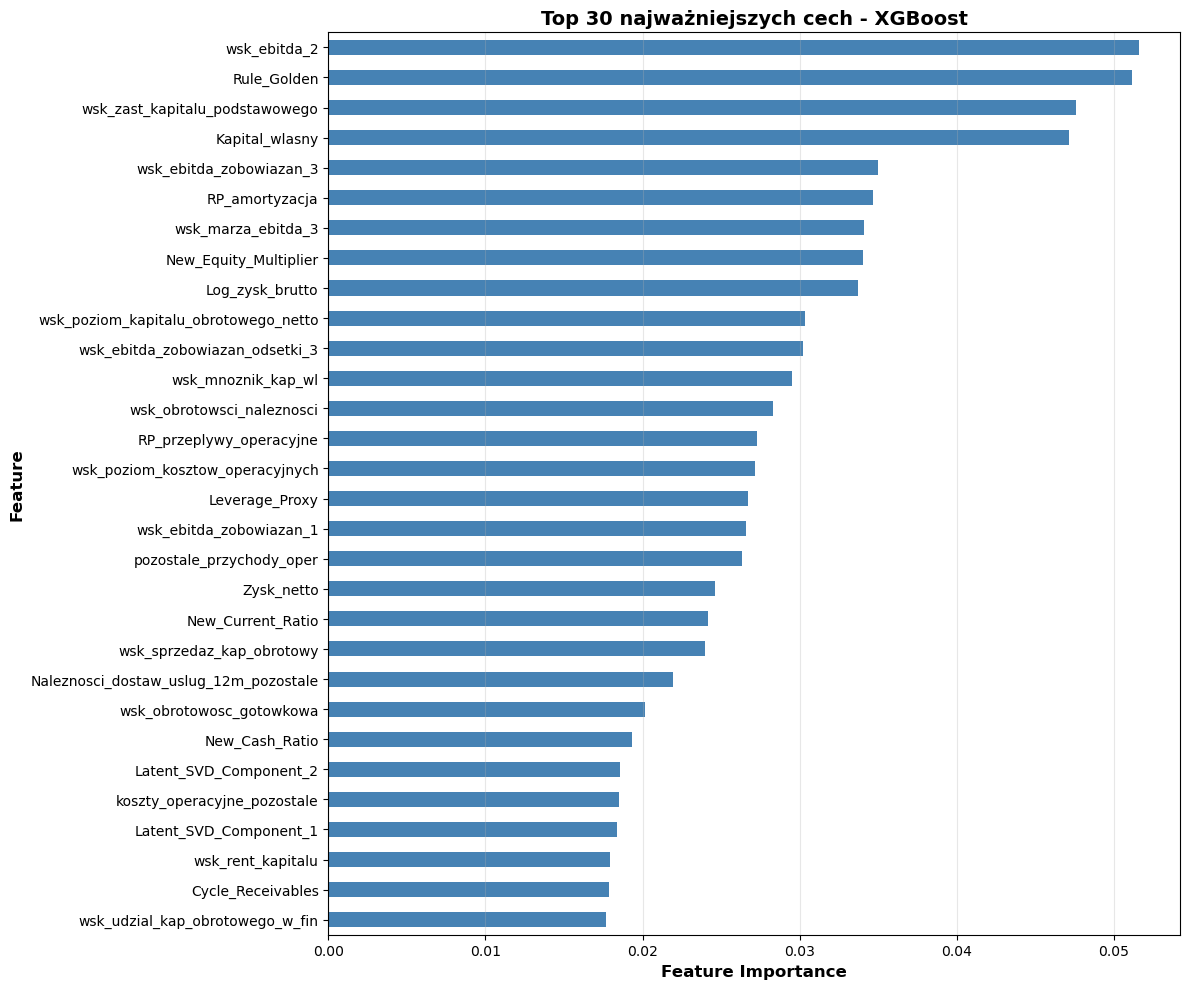



Percentyl: top 75%
Threshold: 0.000000
Liczba cech przed: 146
Liczba cech po: 146
Usunięto cech: 0

WYNIKI PO Feature Importance
WYNIKI EWALUACJI: XGBoost FeatureImportance (Train)
AUC-ROC:       0.7955
PR-AUC:        0.1946
KS Statistic:  0.4591
Log Loss:      0.2091
Brier Score:   0.0548
WYNIKI EWALUACJI: XGBoost FeatureImportance (Test)
AUC-ROC:       0.7648
PR-AUC:        0.1633
KS Statistic:  0.4628
Log Loss:      0.2090
Brier Score:   0.0543
WYNIKI EWALUACJI: XGBoost FeatureImportance (Val)
AUC-ROC:       0.7616
PR-AUC:        0.1869
KS Statistic:  0.4655
Log Loss:      0.2132
Brier Score:   0.0554

PORÓWNANIE Z VarianceThreshold:
  VarianceThreshold AUC Test: 0.764948
  FeatureImportance AUC Test: 0.764825
  Zmiana: -0.000123
  
  VarianceThreshold Gap: 0.032739
  FeatureImportance Gap: 0.030649
  Zmiana Gap: -0.002090


In [ ]:
print("METODA 2: XGBoost Feature Importance")

feature_importances = xgb_var.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train_var.columns.tolist(),
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(f"\n20 najważniejszych cech:")
print(importance_df.head(20).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 10))
top_n = 30
importance_df.head(top_n).sort_values('importance', ascending=True).plot(
    x='feature', y='importance', kind='barh', ax=ax, legend=False, color='steelblue'
)
ax.set_xlabel('Feature Importance', fontweight='bold', fontsize=12)
ax.set_ylabel('Feature', fontweight='bold', fontsize=12)
ax.set_title(f'Top {top_n} najważniejszych cech - XGBoost', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

percentile_threshold = 75
importance_threshold = np.percentile(feature_importances, 100 - percentile_threshold)

selected_features_imp = importance_df[importance_df['importance'] >= importance_threshold]['feature'].tolist()
removed_features_imp = importance_df[importance_df['importance'] < importance_threshold]['feature'].tolist()

print(f"\n\nPercentyl: top {percentile_threshold}%")
print(f"Threshold: {importance_threshold:.6f}")
print(f"Liczba cech przed: {X_train_var.shape[1]}")
print(f"Liczba cech po: {len(selected_features_imp)}")
print(f"Usunięto cech: {len(removed_features_imp)}")

if len(removed_features_imp) > 0:
    print(f"\nUsunięte cechy o niskiej ważności ({len(removed_features_imp)}):")
    for feat in removed_features_imp[:20]:
        imp = importance_df[importance_df['feature'] == feat]['importance'].values[0]
        print(f"  - {feat} (importance: {imp:.6f})")
    if len(removed_features_imp) > 20:
        print(f"  ... i {len(removed_features_imp) - 20} więcej")

X_train_imp = X_train_var[selected_features_imp]
X_test_imp = X_test_var[selected_features_imp]
X_val_imp = X_val_var[selected_features_imp]

xgb_imp = XGBClassifier(**xgb_best_params, enable_categorical=True, random_state=42)
xgb_imp.fit(X_train_imp, y_train)

y_pred_imp_train = xgb_imp.predict_proba(X_train_imp)[:, 1]
y_pred_imp_test = xgb_imp.predict_proba(X_test_imp)[:, 1]
y_pred_imp_val = xgb_imp.predict_proba(X_val_imp)[:, 1]

results_imp_train = evaluate_model(y_train, y_pred_imp_train, "XGBoost FeatureImportance (Train)")
results_imp_test = evaluate_model(y_test, y_pred_imp_test, "XGBoost FeatureImportance (Test)")
results_imp_val = evaluate_model(y_val, y_pred_imp_val, "XGBoost FeatureImportance (Val)")

print("WYNIKI PO Feature Importance")
print_evaluation(results_imp_train)
print_evaluation(results_imp_test)
print_evaluation(results_imp_val)

gap_imp = results_imp_train['AUC-ROC'] - results_imp_test['AUC-ROC']
print(f"\nPORÓWNANIE Z VarianceThreshold:")
print(f"  VarianceThreshold AUC Test: {results_var_test['AUC-ROC']:.6f}")
print(f"  FeatureImportance AUC Test: {results_imp_test['AUC-ROC']:.6f}")
print(f"  Zmiana: {results_imp_test['AUC-ROC'] - results_var_test['AUC-ROC']:+.6f}")
print(f"  ")
print(f"  VarianceThreshold Gap: {gap_var:.6f}")
print(f"  FeatureImportance Gap: {gap_imp:.6f}")
print(f"  Zmiana Gap: {gap_imp - gap_var:+.6f}")


### RFE

START: Analiza 155 zmiennych.

[Faza 1] Probe Method - usuwanie zmiennych nieistotnych statystycznie...
  Próg ważności (szum): 0.003942
  Odrzucono: 72 (szum/śmieci).
  Pozostało: 83 cech do precyzyjnej analizy.

[Faza 2] Iteracyjne usuwanie (krok=1) z walidacją...
  Iter 1: 83 cech -> AUC Val: 0.77512 (Nowy Rekord)
  Iter 2: 82 cech -> AUC Val: 0.77512 (Nowy Rekord)
  Iter 3: 81 cech -> AUC Val: 0.77512 (Nowy Rekord)
  Iter 5: 79 cech -> AUC Val: 0.77384
  Iter 6: 78 cech -> AUC Val: 0.78482 (Nowy Rekord)
  Iter 7: 77 cech -> AUC Val: 0.78778 (Nowy Rekord)
  Iter 10: 74 cech -> AUC Val: 0.78334
  Iter 15: 69 cech -> AUC Val: 0.78103
  Iter 17: 67 cech -> AUC Val: 0.78783 (Nowy Rekord)
  Iter 18: 66 cech -> AUC Val: 0.78920 (Nowy Rekord)
  Iter 20: 64 cech -> AUC Val: 0.78709
  Iter 21: 63 cech -> AUC Val: 0.79442 (Nowy Rekord)
  Iter 25: 59 cech -> AUC Val: 0.79157
  Iter 30: 54 cech -> AUC Val: 0.78807
  Iter 35: 49 cech -> AUC Val: 0.77793
  Iter 40: 44 cech -> AUC Val: 0.78891
  I

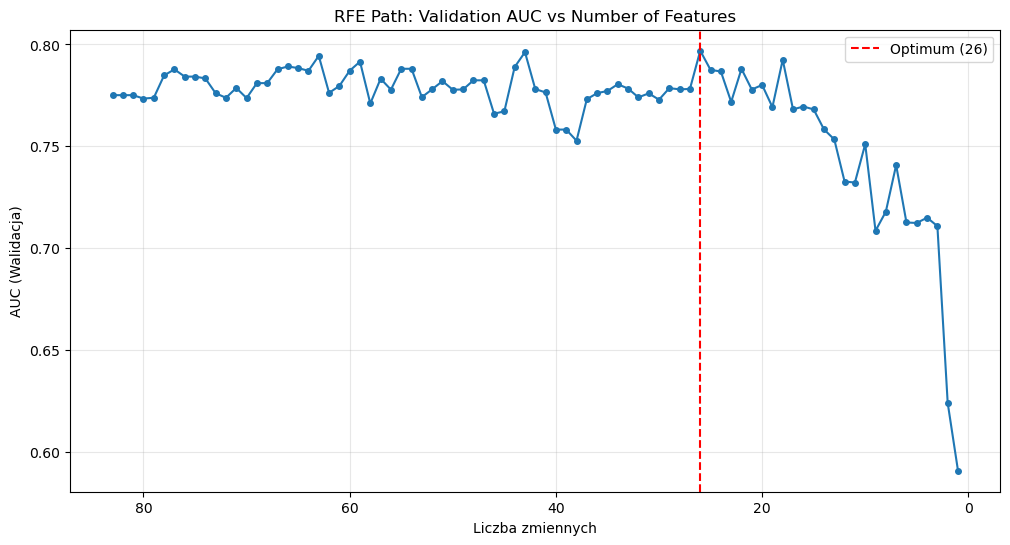

In [ ]:
def hybrid_feature_selection(X_train, y_train, X_val, y_val, step_phase2=1):

    if isinstance(X_train, pd.DataFrame):
        features = X_train.columns.tolist()
        X_t = X_train.copy()
        X_v = X_val.copy()
    else:
        features = [f"feat_{i}" for i in range(X_train.shape[1])]
        X_t = pd.DataFrame(X_train, columns=features)
        X_v = pd.DataFrame(X_val, columns=features)

    print(f"START: Analiza {len(features)} zmiennych.")

    # --- FAZA 1: Probe Method (Odsiewanie szumu) ---    
    X_shadow = X_t.copy()
    X_shadow['RANDOM_PROBE'] = np.random.normal(0, 1, size=len(X_shadow))
    
    model_probe = XGBClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1, enable_categorical=True)
    model_probe.fit(X_shadow, y_train)
    
    imps = pd.Series(model_probe.feature_importances_, index=X_shadow.columns)
    noise_threshold = imps['RANDOM_PROBE']
    
    keep_features = imps[imps > noise_threshold].index.tolist()
    if 'RANDOM_PROBE' in keep_features: keep_features.remove('RANDOM_PROBE')
    
    print(f"  Próg ważności (szum): {noise_threshold:.6f}")
    print(f"  Odrzucono: {len(features) - len(keep_features)} (szum/śmieci).")
    print(f"  Pozostało: {len(keep_features)} cech do precyzyjnej analizy.")

    if not keep_features:
        print("! UWAGA: Wszystkie cechy gorsze od szumu. Zwracam top 10 wg Gain.")
        return imps.drop('RANDOM_PROBE').nlargest(10).index.tolist()

    # --- FAZA 2: Precyzyjne RFE (Loop) ---
    print(f"\n[Faza 2] Iteracyjne usuwanie (krok={step_phase2}) z walidacją...")
    
    current_features = keep_features.copy()
    history = []
    best_auc = 0
    best_features = []
    
    iteration = 0
    while len(current_features) >= 1:
        iteration += 1
        
        model = XGBClassifier(n_estimators=60, learning_rate=0.1, max_depth=4, n_jobs=-1, random_state=42, enable_categorical=True)
        model.fit(X_t[current_features], y_train)
        
        # Kluczowe: Decyzja na podstawie Walidacji
        y_pred_val = model.predict_proba(X_v[current_features])[:, 1]
        auc_val = roc_auc_score(y_val, y_pred_val)
        
        history.append({'n_features': len(current_features), 'auc_val': auc_val})
        
        if auc_val >= best_auc:
            best_auc = auc_val
            best_features = current_features.copy()
            print(f"  Iter {iteration}: {len(current_features)} cech -> AUC Val: {auc_val:.5f} (Nowy Rekord)")
        elif iteration % 5 == 0:
            print(f"  Iter {iteration}: {len(current_features)} cech -> AUC Val: {auc_val:.5f}")

        if len(current_features) == 1:
            break
            
        feat_imps = pd.Series(model.feature_importances_, index=current_features)
        n_drop = min(len(current_features) - 1, step_phase2)
        vars_to_drop = feat_imps.nsmallest(n_drop).index.tolist()
        
        for v in vars_to_drop:
            current_features.remove(v)

    print(f"KONIEC. Wybrano {len(best_features)} zmiennych.")
    print(f"Max AUC Val: {best_auc:.5f}")

    hist_df = pd.DataFrame(history)
    plt.figure(figsize=(12, 6))
    plt.plot(hist_df['n_features'], hist_df['auc_val'], marker='o', markersize=4, linewidth=1.5)
    plt.axvline(len(best_features), color='red', linestyle='--', label=f'Optimum ({len(best_features)})')
    plt.title('RFE Path: Validation AUC vs Number of Features')
    plt.xlabel('Liczba zmiennych')
    plt.ylabel('AUC (Walidacja)')
    plt.gca().invert_xaxis()
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return best_features

selected_cols = hybrid_feature_selection(X_train_final, y_train, X_test_final, y_test, step_phase2=1)

### Eksport danych po feature selection

In [ ]:
print("EKSPORT DANYCH PO FEATURE SELECTION (RFE)")

print(f"\nLiczba wybranych cech: {len(selected_cols)}")
print(f"Kształt zbiorów:")
print(f"  X_train_final: {X_train_final.shape}")
print(f"  X_test_final: {X_test_final.shape}")
print(f"  X_val_final: {X_val_final.shape}")

X_train_selected = X_train_final[selected_cols].copy()
X_test_selected = X_test_final[selected_cols].copy()
X_val_selected = X_val_final[selected_cols].copy()

X_train_selected['default'] = y_train.values
X_test_selected['default'] = y_test.values
X_val_selected['default'] = y_val.values

# Eksport do CSV
X_train_selected.to_csv('train_selected.csv', index=False)
X_test_selected.to_csv('test_selected.csv', index=False)
X_val_selected.to_csv('val_selected.csv', index=False)

print(f"\n✓ Zapisano dane do plików CSV:")
print(f"  • train_selected.csv: {X_train_selected.shape} (z targetem)")
print(f"  • test_selected.csv: {X_test_selected.shape} (z targetem)")
print(f"  • val_selected.csv: {X_val_selected.shape} (z targetem)")





EKSPORT DANYCH PO FEATURE SELECTION (RFE)

Liczba wybranych cech: 26
Kształt zbiorów:
  X_train_final: (1800, 155)
  X_test_final: (600, 155)
  X_val_final: (600, 155)

✓ Zapisano dane do plików CSV:
  • train_selected.csv: (1800, 27) (z targetem)
  • test_selected.csv: (600, 27) (z targetem)
  • val_selected.csv: (600, 27) (z targetem)

Pierwsze 10 wybranych cech:
  1. formaWlasnosci_Symbol
  2. wsk_liczba_dni_istnienia
  3. Naleznosci_dostaw_uslug_12m_pozostale
  4. Kapital_wlasny
  5. koszty_operacyjne_pozostale
  6. RP_przeplywy_operacyjne
  7. RP_amortyzacja
  8. wsk_zwrot_aktywa_trwale
  9. wsk_akt_generowania_got_2
  10. wsk_marza_ebitda_2
  ... i 16 więcej


✓ Zapisano dane do plików CSV:
  • train_selected.csv: (1800, 27) (z targetem)
  • test_selected.csv: (600, 27) (z targetem)
  • val_selected.csv: (600, 27) (z targetem)

Pierwsze 10 wybranych cech:
  1. formaWlasnosci_Symbol
  2. wsk_liczba_dni_istnienia
  3. Naleznosci_dostaw_uslug_12m_pozostale
  4. Kapital_wlasny
  5. k

## Generowanie modelu złożonego

In [ ]:
TRAIN_CSV = "train_selected.csv"
VAL_CSV = "val_selected.csv"
TEST_CSV = "test_selected.csv"
TARGET = "default"
OUT_DIR = "models"

for p in (TRAIN_CSV, VAL_CSV, TEST_CSV):
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing file: {p}")

# --- load ---
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

if TARGET not in train_df.columns:
    raise KeyError(f"'{TARGET}' not in train csv")

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].values

X_val = val_df.drop(columns=[TARGET])
y_val = val_df[TARGET].values

X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET].values

cols = X_train.columns.tolist()
X_val = X_val[cols]
X_test = X_test[cols]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Targets (train/val/test):", np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))


Shapes: (1800, 26) (600, 26) (600, 26)
Targets (train/val/test): [1690  110] [563  37] [564  36]


In [ ]:
#   1) XGBOOST — BAYESIAN OPTIMIZATION
# =========================================================

def objective_xgb(trial):

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": trial.suggest_float("eta", 0.03, 0.10),
        "max_depth": trial.suggest_int("max_depth", 2, 4),
        "min_child_weight": trial.suggest_float("min_child_weight", 15, 60),
        "subsample": trial.suggest_float("subsample", 0.5, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "alpha": trial.suggest_float("alpha", 1.0, 5.0),
        "lambda": trial.suggest_float("lambda", 5.0, 20.0),
        "tree_method": "hist",
        "seed": 42,
        "verbosity": 0
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest  = xgb.DMatrix(X_test,  label=y_test)
    dval   = xgb.DMatrix(X_val,   label=y_val)

    # Trening na train, early stopping na test
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=800,
        evals=[(dtest, "test")],
        early_stopping_rounds=30
    )

    # Ewaluacja na zbiorze walidacyjnym
    preds = model.predict(dval, iteration_range=(0, model.best_iteration + 1))

    return roc_auc_score(y_val, preds)

In [ ]:
#   2) LIGHTGBM — BAYESIAN OPTIMIZATION
# =========================================================
def objective_lgb(trial):

    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.10),
        "num_leaves": trial.suggest_int("num_leaves", 8, 31),
        "max_depth": trial.suggest_int("max_depth", 2, 4),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 80),
        "subsample": trial.suggest_float("subsample", 0.5, 0.8),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 0.8),
        "lambda_l1": trial.suggest_float("lambda_l1", 1.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 5.0, 30.0),
        "seed": 42,
        "verbose": -1
    }

    train_set = lgb.Dataset(X_train, label=y_train)
    test_set  = lgb.Dataset(X_test, label=y_test)

    # Trening na train, early stopping na test
    model = lgb.train(
        params=params,
        train_set=train_set,
        num_boost_round=2000,
        valid_sets=[test_set],
        valid_names=["test"],
        callbacks=[lgb.early_stopping(stopping_rounds=30)]
    )

    # Ewaluacja na zbiorze walidacyjnym
    preds = model.predict(X_val, num_iteration=model.best_iteration)

    return roc_auc_score(y_val, preds)

In [ ]:
#   3) CATBOOST — BAYESIAN OPTIMIZATION
# =========================================================

def objective_cat(trial):

    params = {
        "iterations": 1200,
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.10),
        "depth": trial.suggest_int("depth", 3, 5),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 5.0, 20.0),
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": False,
        "od_type": "Iter",
        "od_wait": 30
    }

    model = CatBoostClassifier(**params)
    # Trening na train, early stopping na test
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

    # Ewaluacja na zbiorze walidacyjnym
    preds = model.predict_proba(X_val)[:, 1]

    return roc_auc_score(y_val, preds)

#### Uruchomienie szukania bayesowskiego

In [ ]:
print("=== XGBOOST BAYESIAN SEARCH ===")
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)
print("BEST XGB:", study_xgb.best_value)
print(study_xgb.best_params)


[I 2025-12-09 20:27:17,503] A new study created in memory with name: no-name-669680fd-eaa5-4a42-8d22-7faf0aea3d0d


=== XGBOOST BAYESIAN SEARCH ===
[0]	test-auc:0.50000
[0]	test-auc:0.50000
[1]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	test-auc:0.5000

[I 2025-12-09 20:27:19,120] Trial 0 finished with value: 0.5 and parameters: {'eta': 0.07213792966737892, 'max_depth': 2, 'min_child_weight': 50.78887213191047, 'subsample': 0.7791381797119551, 'colsample_bytree': 0.6341424832609235, 'alpha': 4.115588668852537, 'lambda': 12.62917160124052}. Best is trial 0 with value: 0.5.


[0]	test-auc:0.65221
[1]	test-auc:0.69065
[1]	test-auc:0.69065
[2]	test-auc:0.67935
[3]	test-auc:0.70986
[2]	test-auc:0.67935
[3]	test-auc:0.70986
[4]	test-auc:0.72131
[5]	test-auc:0.71983
[4]	test-auc:0.72131
[5]	test-auc:0.71983
[6]	test-auc:0.73136
[7]	test-auc:0.72392
[6]	test-auc:0.73136
[7]	test-auc:0.72392
[8]	test-auc:0.72030
[9]	test-auc:0.71437
[10]	test-auc:0.72914
[11]	test-auc:0.72412
[12]	test-auc:0.72225
[8]	test-auc:0.72030
[9]	test-auc:0.71437
[10]	test-auc:0.72914
[11]	test-auc:0.72412
[12]	test-auc:0.72225
[13]	test-auc:0.72372
[13]	test-auc:0.72372
[14]	test-auc:0.72954
[15]	test-auc:0.73183
[14]	test-auc:0.72954
[15]	test-auc:0.73183
[16]	test-auc:0.73190
[16]	test-auc:0.73190
[17]	test-auc:0.73769
[18]	test-auc:0.74672
[19]	test-auc:0.74825
[17]	test-auc:0.73769
[18]	test-auc:0.74672
[19]	test-auc:0.74825
[20]	test-auc:0.74921
[21]	test-auc:0.75002
[20]	test-auc:0.74921
[21]	test-auc:0.75002
[22]	test-auc:0.75094
[22]	test-auc:0.75094
[23]	test-auc:0.75044
[24]	te

[I 2025-12-09 20:27:24,200] Trial 1 finished with value: 0.7312899044693005 and parameters: {'eta': 0.06745440059023108, 'max_depth': 4, 'min_child_weight': 16.192853520051866, 'subsample': 0.5871651296523448, 'colsample_bytree': 0.6935629469825547, 'alpha': 4.301259731593936, 'lambda': 12.173535254591911}. Best is trial 1 with value: 0.7312899044693005.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	test-auc:0.50000
[24]	te

[I 2025-12-09 20:27:24,726] Trial 2 finished with value: 0.5 and parameters: {'eta': 0.07756063055519521, 'max_depth': 3, 'min_child_weight': 45.293916478209184, 'subsample': 0.7400608749279021, 'colsample_bytree': 0.6814334298815111, 'alpha': 2.478265823646434, 'lambda': 16.934555849284017}. Best is trial 1 with value: 0.7312899044693005.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	te

[I 2025-12-09 20:27:25,253] Trial 3 finished with value: 0.5 and parameters: {'eta': 0.0509166185917541, 'max_depth': 2, 'min_child_weight': 50.74142513258987, 'subsample': 0.5495924739951732, 'colsample_bytree': 0.6640207958120529, 'alpha': 4.718256438935025, 'lambda': 9.103873686236332}. Best is trial 1 with value: 0.7312899044693005.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000[19]	test-auc:0.50000
[20]	test-auc:0.50000

[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	te

[I 2025-12-09 20:27:25,804] Trial 4 finished with value: 0.5 and parameters: {'eta': 0.07881703073071814, 'max_depth': 3, 'min_child_weight': 44.3110681168555, 'subsample': 0.6937239617645624, 'colsample_bytree': 0.7577450732007451, 'alpha': 4.6724525312237635, 'lambda': 13.54884765021757}. Best is trial 1 with value: 0.7312899044693005.


[0]	test-auc:0.65160
[1]	test-auc:0.68381
[2]	test-auc:0.70279
[1]	test-auc:0.68381
[2]	test-auc:0.70279
[3]	test-auc:0.72845
[3]	test-auc:0.72845
[4]	test-auc:0.74086
[5]	test-auc:0.73953
[4]	test-auc:0.74086
[5]	test-auc:0.73953
[6]	test-auc:0.74424
[6]	test-auc:0.74424
[7]	test-auc:0.74222
[8]	test-auc:0.73931
[9]	test-auc:0.73715
[7]	test-auc:0.74222
[8]	test-auc:0.73931
[9]	test-auc:0.73715
[10]	test-auc:0.73439
[11]	test-auc:0.73234
[10]	test-auc:0.73439
[11]	test-auc:0.73234
[12]	test-auc:0.73431
[12]	test-auc:0.73431
[13]	test-auc:0.73436
[14]	test-auc:0.74126
[13]	test-auc:0.73436
[14]	test-auc:0.74126
[15]	test-auc:0.74069
[16]	test-auc:0.73985
[15]	test-auc:0.74069
[16]	test-auc:0.73985
[17]	test-auc:0.73995
[18]	test-auc:0.74025
[17]	test-auc:0.73995
[18]	test-auc:0.74025
[19]	test-auc:0.74291
[20]	test-auc:0.74027
[19]	test-auc:0.74291
[20]	test-auc:0.74027
[21]	test-auc:0.73944
[21]	test-auc:0.73944
[22]	test-auc:0.73724
[22]	test-auc:0.73724
[23]	test-auc:0.73764
[24]	te

[I 2025-12-09 20:27:28,282] Trial 5 finished with value: 0.7376986222456916 and parameters: {'eta': 0.05879889533583632, 'max_depth': 4, 'min_child_weight': 34.26239657180446, 'subsample': 0.7281056249589366, 'colsample_bytree': 0.5832588054204686, 'alpha': 2.3063820281146117, 'lambda': 10.386597219595426}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	test-auc:0.50000
[23]	te

[I 2025-12-09 20:27:28,793] Trial 6 finished with value: 0.5 and parameters: {'eta': 0.032126921696125674, 'max_depth': 3, 'min_child_weight': 49.506222885262275, 'subsample': 0.6378674089894594, 'colsample_bytree': 0.7903585549696747, 'alpha': 3.8072556183108666, 'lambda': 16.09025303924794}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.65573
[2]	test-auc:0.50000
[3]	test-auc:0.65573
[4]	test-auc:0.65573
[5]	test-auc:0.70486
[4]	test-auc:0.65573
[5]	test-auc:0.70486
[6]	test-auc:0.73451
[7]	test-auc:0.72816
[6]	test-auc:0.73451
[7]	test-auc:0.72816
[8]	test-auc:0.72833
[8]	test-auc:0.72833
[9]	test-auc:0.72833
[9]	test-auc:0.72833
[10]	test-auc:0.72833
[10]	test-auc:0.72833
[11]	test-auc:0.73281
[11]	test-auc:0.73281
[12]	test-auc:0.73281
[13]	test-auc:0.73281
[12]	test-auc:0.73281
[13]	test-auc:0.73281
[14]	test-auc:0.73281
[15]	test-auc:0.73281
[14]	test-auc:0.73281
[15]	test-auc:0.73281
[16]	test-auc:0.73281
[17]	test-auc:0.73281
[16]	test-auc:0.73281
[17]	test-auc:0.73281
[18]	test-auc:0.73281
[19]	test-auc:0.73281
[20]	test-auc:0.74367
[18]	test-auc:0.73281
[19]	test-auc:0.73281
[20]	test-auc:0.74367
[21]	test-auc:0.74313
[22]	test-auc:0.74313
[21]	test-auc:0.74313
[22]	test-auc:0.74313
[23]	test-auc:0.74205
[24]	te

[I 2025-12-09 20:27:29,699] Trial 7 finished with value: 0.7028467188325092 and parameters: {'eta': 0.09466095558398839, 'max_depth': 2, 'min_child_weight': 36.32529604216838, 'subsample': 0.6956082711948955, 'colsample_bytree': 0.5726114640005296, 'alpha': 2.0464459747117703, 'lambda': 8.431579439384056}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.65160
[1]	test-auc:0.68403
[1]	test-auc:0.68403
[2]	test-auc:0.70819
[3]	test-auc:0.73229
[4]	test-auc:0.72904
[2]	test-auc:0.70819
[3]	test-auc:0.73229
[4]	test-auc:0.72904
[5]	test-auc:0.73234
[6]	test-auc:0.75079
[5]	test-auc:0.73234
[6]	test-auc:0.75079
[7]	test-auc:0.75209
[7]	test-auc:0.75209
[8]	test-auc:0.75271
[8]	test-auc:0.75271
[9]	test-auc:0.75133
[10]	test-auc:0.75926
[9]	test-auc:0.75133
[10]	test-auc:0.75926
[11]	test-auc:0.75714
[12]	test-auc:0.75685
[13]	test-auc:0.76005
[11]	test-auc:0.75714
[12]	test-auc:0.75685
[13]	test-auc:0.76005
[14]	test-auc:0.75943
[14]	test-auc:0.75943
[15]	test-auc:0.75978
[16]	test-auc:0.75936
[15]	test-auc:0.75978
[16]	test-auc:0.75936
[17]	test-auc:0.75877
[18]	test-auc:0.76519
[17]	test-auc:0.75877
[18]	test-auc:0.76519
[19]	test-auc:0.76953
[20]	test-auc:0.77027
[19]	test-auc:0.76953
[20]	test-auc:0.77027
[21]	test-auc:0.76926
[21]	test-auc:0.76926
[22]	test-auc:0.76724
[22]	test-auc:0.76724
[23]	test-auc:0.76670
[24]	te

[I 2025-12-09 20:27:31,061] Trial 8 finished with value: 0.7069511785319956 and parameters: {'eta': 0.09266278327384114, 'max_depth': 3, 'min_child_weight': 19.6038903593826, 'subsample': 0.500355922662695, 'colsample_bytree': 0.5282028214256884, 'alpha': 2.1417108841121046, 'lambda': 13.159856819015419}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.65160
[1]	test-auc:0.68403
[2]	test-auc:0.70198
[3]	test-auc:0.71114
[4]	test-auc:0.70755
[5]	test-auc:0.70789
[6]	test-auc:0.72715
[7]	test-auc:0.72368
[8]	test-auc:0.72301
[1]	test-auc:0.68403
[2]	test-auc:0.70198
[3]	test-auc:0.71114
[4]	test-auc:0.70755
[5]	test-auc:0.70789
[6]	test-auc:0.72715
[7]	test-auc:0.72368
[8]	test-auc:0.72301
[9]	test-auc:0.72306
[10]	test-auc:0.73141
[11]	test-auc:0.72919
[9]	test-auc:0.72306
[10]	test-auc:0.73141
[11]	test-auc:0.72919
[12]	test-auc:0.73141
[12]	test-auc:0.73141
[13]	test-auc:0.73195
[14]	test-auc:0.73264
[13]	test-auc:0.73195
[14]	test-auc:0.73264
[15]	test-auc:0.73229
[15]	test-auc:0.73229
[16]	test-auc:0.73229
[17]	test-auc:0.73224
[18]	test-auc:0.73210
[16]	test-auc:0.73229
[17]	test-auc:0.73224
[18]	test-auc:0.73210
[19]	test-auc:0.73109
[20]	test-auc:0.73717
[19]	test-auc:0.73109
[20]	test-auc:0.73717
[21]	test-auc:0.73323
[21]	test-auc:0.73323
[22]	test-auc:0.73399
[22]	test-auc:0.73399
[23]	test-auc:0.73409
[24]	te

[I 2025-12-09 20:27:34,328] Trial 9 finished with value: 0.7369545389083578 and parameters: {'eta': 0.08291904554172955, 'max_depth': 4, 'min_child_weight': 25.889025782819864, 'subsample': 0.5489041697293251, 'colsample_bytree': 0.7466976112082842, 'alpha': 3.6888365714101674, 'lambda': 15.630222678104925}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.65839
[1]	test-auc:0.68888
[2]	test-auc:0.71343
[1]	test-auc:0.68888
[2]	test-auc:0.71343
[3]	test-auc:0.73914
[4]	test-auc:0.73554
[5]	test-auc:0.73527
[6]	test-auc:0.74234
[7]	test-auc:0.74389[3]	test-auc:0.73914
[4]	test-auc:0.73554
[5]	test-auc:0.73527
[6]	test-auc:0.74234
[7]	test-auc:0.74389
[8]	test-auc:0.73626

[8]	test-auc:0.73626
[9]	test-auc:0.73498
[10]	test-auc:0.74306[9]	test-auc:0.73498
[10]	test-auc:0.74306
[11]	test-auc:0.74414
[12]	test-auc:0.74224

[11]	test-auc:0.74414
[12]	test-auc:0.74224
[13]	test-auc:0.74490
[14]	test-auc:0.74672
[15]	test-auc:0.74409
[16]	test-auc:0.74512
[17]	test-auc:0.74419
[18]	test-auc:0.74291
[19]	test-auc:0.74251
[13]	test-auc:0.74490
[14]	test-auc:0.74672
[15]	test-auc:0.74409
[16]	test-auc:0.74512
[17]	test-auc:0.74419
[18]	test-auc:0.74291
[19]	test-auc:0.74251
[20]	test-auc:0.74379
[21]	test-auc:0.74379
[22]	test-auc:0.74384
[23]	test-auc:0.74604
[20]	test-auc:0.74379
[21]	test-auc:0.74379
[22]	test-auc:0.74384
[23]	te

[I 2025-12-09 20:27:36,614] Trial 10 finished with value: 0.7193845710719601 and parameters: {'eta': 0.05360655840950673, 'max_depth': 4, 'min_child_weight': 32.23350255634182, 'subsample': 0.7981438718050046, 'colsample_bytree': 0.5921251860986727, 'alpha': 1.2542644478126244, 'lambda': 5.454255630598943}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.69031
[1]	test-auc:0.72567
[1]	test-auc:0.72567
[2]	test-auc:0.72496
[3]	test-auc:0.72390
[4]	test-auc:0.73325
[2]	test-auc:0.72496
[3]	test-auc:0.72390
[4]	test-auc:0.73325
[5]	test-auc:0.72774
[6]	test-auc:0.72835
[7]	test-auc:0.72811
[5]	test-auc:0.72774
[6]	test-auc:0.72835
[7]	test-auc:0.72811
[8]	test-auc:0.72762
[8]	test-auc:0.72762
[9]	test-auc:0.72811
[9]	test-auc:0.72811
[10]	test-auc:0.73023
[11]	test-auc:0.72973
[10]	test-auc:0.73023
[11]	test-auc:0.72973
[12]	test-auc:0.73399
[12]	test-auc:0.73399
[13]	test-auc:0.73340
[14]	test-auc:0.73572
[13]	test-auc:0.73340
[14]	test-auc:0.73572
[15]	test-auc:0.73380
[15]	test-auc:0.73380
[16]	test-auc:0.73355
[16]	test-auc:0.73355
[17]	test-auc:0.73291
[18]	test-auc:0.73239
[19]	test-auc:0.73264
[17]	test-auc:0.73291
[18]	test-auc:0.73239
[19]	test-auc:0.73264
[20]	test-auc:0.73229
[20]	test-auc:0.73229
[21]	test-auc:0.73020
[22]	test-auc:0.73064
[23]	test-auc:0.73079
[21]	test-auc:0.73020
[22]	test-auc:0.73064
[23]	te

[I 2025-12-09 20:27:37,308] Trial 11 finished with value: 0.6782919687004945 and parameters: {'eta': 0.05607330743643099, 'max_depth': 4, 'min_child_weight': 26.538249739545222, 'subsample': 0.622204905886133, 'colsample_bytree': 0.734990685429239, 'alpha': 3.2269602367609296, 'lambda': 19.865768904721843}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	test-auc:0.50000
[24]	test-auc:0.50000
[25]	test-auc:0.50000
[21]	te

[I 2025-12-09 20:27:37,823] Trial 12 finished with value: 0.5 and parameters: {'eta': 0.03905545563832116, 'max_depth': 4, 'min_child_weight': 59.6100280434471, 'subsample': 0.6938958592764862, 'colsample_bytree': 0.5089393322139327, 'alpha': 3.1399670228197447, 'lambda': 9.962188854260694}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.66105
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.66105
[12]	test-auc:0.66105
[13]	test-auc:0.66105
[12]	test-auc:0.66105
[13]	test-auc:0.66105
[14]	test-auc:0.66105
[15]	test-auc:0.66105
[14]	test-auc:0.66105
[15]	test-auc:0.66105
[16]	test-auc:0.66105
[16]	test-auc:0.66105
[17]	test-auc:0.66105
[17]	test-auc:0.66105
[18]	test-auc:0.66105
[18]	test-auc:0.66105
[19]	test-auc:0.66105
[19]	test-auc:0.66105
[20]	test-auc:0.66105
[20]	test-auc:0.66105
[21]	test-auc:0.66105
[21]	test-auc:0.66105
[22]	test-auc:0.66105
[23]	test-auc:0.66105
[22]	test-auc:0.66105
[23]	te

[I 2025-12-09 20:27:39,183] Trial 13 finished with value: 0.5682636455282992 and parameters: {'eta': 0.0836145546219117, 'max_depth': 4, 'min_child_weight': 27.08013955359007, 'subsample': 0.5053990037780126, 'colsample_bytree': 0.6050729511985, 'alpha': 1.3406521890072935, 'lambda': 16.414864557622842}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.65160
[1]	test-auc:0.68427
[1]	test-auc:0.68427
[2]	test-auc:0.69693
[3]	test-auc:0.69784[2]	test-auc:0.69693
[3]	test-auc:0.69784

[4]	test-auc:0.70112
[5]	test-auc:0.69624
[6]	test-auc:0.72759
[4]	test-auc:0.70112
[5]	test-auc:0.69624
[6]	test-auc:0.72759
[7]	test-auc:0.73244
[7]	test-auc:0.73244
[8]	test-auc:0.72988
[9]	test-auc:0.73244
[8]	test-auc:0.72988
[9]	test-auc:0.73244
[10]	test-auc:0.72998
[11]	test-auc:0.73143
[10]	test-auc:0.72998
[11]	test-auc:0.73143
[12]	test-auc:0.73409
[12]	test-auc:0.73409
[13]	test-auc:0.73217
[14]	test-auc:0.73586
[13]	test-auc:0.73217
[14]	test-auc:0.73586
[15]	test-auc:0.74145
[16]	test-auc:0.74091
[15]	test-auc:0.74145
[16]	test-auc:0.74091
[17]	test-auc:0.74022
[17]	test-auc:0.74022
[18]	test-auc:0.73988
[19]	test-auc:0.74109
[18]	test-auc:0.73988
[19]	test-auc:0.74109
[20]	test-auc:0.73515
[21]	test-auc:0.73353
[22]	test-auc:0.73348
[20]	test-auc:0.73515
[21]	test-auc:0.73353
[22]	test-auc:0.73348
[23]	test-auc:0.73350
[24]	te

[I 2025-12-09 20:27:43,660] Trial 14 finished with value: 0.7313619125342039 and parameters: {'eta': 0.06140524981143648, 'max_depth': 4, 'min_child_weight': 26.018657092493477, 'subsample': 0.5734654286367562, 'colsample_bytree': 0.7123089879497312, 'alpha': 3.5495462958893524, 'lambda': 18.880031910938904}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.65160
[1]	test-auc:0.68381
[2]	test-auc:0.70644
[1]	test-auc:0.68381
[2]	test-auc:0.70644
[3]	test-auc:0.73131
[4]	test-auc:0.73848
[5]	test-auc:0.73771
[3]	test-auc:0.73131
[4]	test-auc:0.73848
[5]	test-auc:0.73771
[6]	test-auc:0.74249
[7]	test-auc:0.74212
[6]	test-auc:0.74249
[7]	test-auc:0.74212
[8]	test-auc:0.74074
[8]	test-auc:0.74074
[9]	test-auc:0.73916
[10]	test-auc:0.74005
[11]	test-auc:0.74458
[12]	test-auc:0.74498
[13]	test-auc:0.74572
[14]	test-auc:0.75020
[9]	test-auc:0.73916
[10]	test-auc:0.74005
[11]	test-auc:0.74458
[12]	test-auc:0.74498
[13]	test-auc:0.74572
[14]	test-auc:0.75020
[15]	test-auc:0.75182
[15]	test-auc:0.75182
[16]	test-auc:0.75163
[17]	test-auc:0.75133
[18]	test-auc:0.75069
[19]	test-auc:0.75094
[20]	test-auc:0.74966
[21]	test-auc:0.74936
[22]	test-auc:0.74914
[16]	test-auc:0.75163
[17]	test-auc:0.75133
[18]	test-auc:0.75069
[19]	test-auc:0.75094
[20]	test-auc:0.74966
[21]	test-auc:0.74936
[22]	test-auc:0.74914
[23]	test-auc:0.74882
[24]	te

[I 2025-12-09 20:27:46,094] Trial 15 finished with value: 0.737314579232874 and parameters: {'eta': 0.08731066238544574, 'max_depth': 4, 'min_child_weight': 34.15662861415165, 'subsample': 0.7391793002103478, 'colsample_bytree': 0.5581716995713942, 'alpha': 2.6237671628569155, 'lambda': 6.8815735760289725}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.65366
[1]	test-auc:0.68740
[2]	test-auc:0.72190
[1]	test-auc:0.68740
[2]	test-auc:0.72190
[3]	test-auc:0.73655
[3]	test-auc:0.73655
[4]	test-auc:0.73968
[5]	test-auc:0.73340
[4]	test-auc:0.73968
[5]	test-auc:0.73340
[6]	test-auc:0.73554
[7]	test-auc:0.73180
[6]	test-auc:0.73554
[7]	test-auc:0.73180
[8]	test-auc:0.73348
[9]	test-auc:0.72890
[10]	test-auc:0.72860
[11]	test-auc:0.72422
[12]	test-auc:0.72471
[8]	test-auc:0.73348
[9]	test-auc:0.72890
[10]	test-auc:0.72860
[11]	test-auc:0.72422
[12]	test-auc:0.72471
[13]	test-auc:0.72323
[14]	test-auc:0.73106
[15]	test-auc:0.74219
[13]	test-auc:0.72323
[14]	test-auc:0.73106
[15]	test-auc:0.74219
[16]	test-auc:0.74170
[17]	test-auc:0.74111
[18]	test-auc:0.74096
[16]	test-auc:0.74170
[17]	test-auc:0.74111
[18]	test-auc:0.74096
[19]	test-auc:0.74101
[20]	test-auc:0.74086
[21]	test-auc:0.74074
[19]	test-auc:0.74101
[20]	test-auc:0.74086
[21]	test-auc:0.74074
[22]	test-auc:0.74054
[23]	test-auc:0.74143
[24]	test-auc:0.74234
[22]	te

[I 2025-12-09 20:27:48,189] Trial 16 finished with value: 0.7257212807834479 and parameters: {'eta': 0.04510446473204928, 'max_depth': 3, 'min_child_weight': 37.398345735115235, 'subsample': 0.7455190732087403, 'colsample_bytree': 0.5471115460069511, 'alpha': 2.5183084386443793, 'lambda': 5.531879109618528}. Best is trial 5 with value: 0.7376986222456916.


[0]	test-auc:0.65160
[1]	test-auc:0.68381
[2]	test-auc:0.69673
[3]	test-auc:0.72794
[1]	test-auc:0.68381
[2]	test-auc:0.69673
[3]	test-auc:0.72794
[4]	test-auc:0.73715
[5]	test-auc:0.74042
[6]	test-auc:0.74867
[4]	test-auc:0.73715
[5]	test-auc:0.74042
[6]	test-auc:0.74867
[7]	test-auc:0.74616
[8]	test-auc:0.74005
[7]	test-auc:0.74616
[8]	test-auc:0.74005
[9]	test-auc:0.73941
[10]	test-auc:0.74397
[11]	test-auc:0.74468
[12]	test-auc:0.74663
[13]	test-auc:0.74786
[14]	test-auc:0.74384
[15]	test-auc:0.74599
[9]	test-auc:0.73941
[10]	test-auc:0.74397
[11]	test-auc:0.74468
[12]	test-auc:0.74663
[13]	test-auc:0.74786
[14]	test-auc:0.74384
[15]	test-auc:0.74599
[16]	test-auc:0.74643
[17]	test-auc:0.74539
[18]	test-auc:0.74461
[19]	test-auc:0.74426
[20]	test-auc:0.74507
[16]	test-auc:0.74643
[17]	test-auc:0.74539
[18]	test-auc:0.74461
[19]	test-auc:0.74426
[20]	test-auc:0.74507
[21]	test-auc:0.74394
[22]	test-auc:0.74478
[23]	test-auc:0.74443
[24]	test-auc:0.74769
[21]	test-auc:0.74394
[22]	te

[I 2025-12-09 20:27:51,593] Trial 17 finished with value: 0.7400748883874995 and parameters: {'eta': 0.06379115767661893, 'max_depth': 4, 'min_child_weight': 31.477898887427962, 'subsample': 0.7354794284527864, 'colsample_bytree': 0.6284051706126055, 'alpha': 1.744716878563034, 'lambda': 7.516684540942123}. Best is trial 17 with value: 0.7400748883874995.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	te

[I 2025-12-09 20:27:52,455] Trial 18 finished with value: 0.5 and parameters: {'eta': 0.065296213529416, 'max_depth': 4, 'min_child_weight': 42.70974521296803, 'subsample': 0.6750006141202196, 'colsample_bytree': 0.6129494874415651, 'alpha': 1.677858145512504, 'lambda': 10.50771836022407}. Best is trial 17 with value: 0.7400748883874995.


[0]	test-auc:0.65839
[1]	test-auc:0.68888
[1]	test-auc:0.68888
[2]	test-auc:0.68866
[3]	test-auc:0.72798
[2]	test-auc:0.68866
[3]	test-auc:0.72798
[4]	test-auc:0.73441
[4]	test-auc:0.73441
[5]	test-auc:0.73678
[5]	test-auc:0.73678
[6]	test-auc:0.72983
[7]	test-auc:0.72895
[6]	test-auc:0.72983
[7]	test-auc:0.72895
[8]	test-auc:0.72993
[9]	test-auc:0.72939
[8]	test-auc:0.72993
[9]	test-auc:0.72939
[10]	test-auc:0.73623
[11]	test-auc:0.73663
[10]	test-auc:0.73623
[11]	test-auc:0.73663
[12]	test-auc:0.73779
[13]	test-auc:0.73813
[12]	test-auc:0.73779
[13]	test-auc:0.73813
[14]	test-auc:0.73096
[15]	test-auc:0.73035
[14]	test-auc:0.73096
[15]	test-auc:0.73035
[16]	test-auc:0.73055
[17]	test-auc:0.72993
[16]	test-auc:0.73055
[17]	test-auc:0.72993
[18]	test-auc:0.72885
[18]	test-auc:0.72885
[19]	test-auc:0.72717
[19]	test-auc:0.72717
[20]	test-auc:0.73052
[21]	test-auc:0.73279
[20]	test-auc:0.73052
[21]	test-auc:0.73279
[22]	test-auc:0.73439
[22]	test-auc:0.73439
[23]	test-auc:0.73825
[23]	te

[I 2025-12-09 20:27:56,070] Trial 19 finished with value: 0.727905525418847 and parameters: {'eta': 0.060326160377461434, 'max_depth': 3, 'min_child_weight': 30.657754814686932, 'subsample': 0.7681198843161594, 'colsample_bytree': 0.6396053794518288, 'alpha': 1.811156890395377, 'lambda': 8.142363232415684}. Best is trial 17 with value: 0.7400748883874995.


[0]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[1]	test-auc:0.50000
[2]	test-auc:0.50000
[3]	test-auc:0.50000
[3]	test-auc:0.50000
[4]	test-auc:0.50000
[4]	test-auc:0.50000
[5]	test-auc:0.50000
[5]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[6]	test-auc:0.50000
[7]	test-auc:0.50000
[8]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[9]	test-auc:0.50000
[10]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[11]	test-auc:0.50000
[12]	test-auc:0.50000
[13]	test-auc:0.50000
[13]	test-auc:0.50000
[14]	test-auc:0.50000
[14]	test-auc:0.50000
[15]	test-auc:0.50000
[15]	test-auc:0.50000
[16]	test-auc:0.50000
[16]	test-auc:0.50000
[17]	test-auc:0.50000
[17]	test-auc:0.50000
[18]	test-auc:0.50000
[18]	test-auc:0.50000
[19]	test-auc:0.50000
[19]	test-auc:0.50000
[20]	test-auc:0.50000
[20]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[21]	test-auc:0.50000
[22]	test-auc:0.50000
[23]	test-auc:0.50000
[24]	te

[I 2025-12-09 20:27:57,633] Trial 20 finished with value: 0.5 and parameters: {'eta': 0.045155570179107166, 'max_depth': 3, 'min_child_weight': 40.80226432255838, 'subsample': 0.7148712042135844, 'colsample_bytree': 0.5811641270893126, 'alpha': 1.146644705247318, 'lambda': 11.254190225712453}. Best is trial 17 with value: 0.7400748883874995.


[0]	test-auc:0.65160
[1]	test-auc:0.68381
[1]	test-auc:0.68381
[2]	test-auc:0.70279
[3]	test-auc:0.72845
[4]	test-auc:0.74086
[2]	test-auc:0.70279
[3]	test-auc:0.72845
[4]	test-auc:0.74086
[5]	test-auc:0.73953
[5]	test-auc:0.73953
[6]	test-auc:0.74695
[7]	test-auc:0.74572
[6]	test-auc:0.74695
[7]	test-auc:0.74572
[8]	test-auc:0.74473
[8]	test-auc:0.74473
[9]	test-auc:0.74286
[10]	test-auc:0.74246
[9]	test-auc:0.74286
[10]	test-auc:0.74246
[11]	test-auc:0.74685
[11]	test-auc:0.74685
[12]	test-auc:0.74771
[13]	test-auc:0.74781
[12]	test-auc:0.74771
[13]	test-auc:0.74781
[14]	test-auc:0.75190
[14]	test-auc:0.75190
[15]	test-auc:0.74934
[16]	test-auc:0.74938
[15]	test-auc:0.74934
[16]	test-auc:0.74938
[17]	test-auc:0.74958
[18]	test-auc:0.74973
[17]	test-auc:0.74958
[18]	test-auc:0.74973
[19]	test-auc:0.75170
[19]	test-auc:0.75170
[20]	test-auc:0.74884
[21]	test-auc:0.74855
[20]	test-auc:0.74884
[21]	test-auc:0.74855
[22]	test-auc:0.74601
[22]	test-auc:0.74601
[23]	test-auc:0.74596[23]	tes

[I 2025-12-09 20:28:01,444] Trial 21 finished with value: 0.7208487350583265 and parameters: {'eta': 0.07199590196601421, 'max_depth': 4, 'min_child_weight': 34.313275830269156, 'subsample': 0.7330366969168556, 'colsample_bytree': 0.5587751087814342, 'alpha': 2.5998912876783744, 'lambda': 6.847299119787955}. Best is trial 17 with value: 0.7400748883874995.


[0]	test-auc:0.65160
[1]	test-auc:0.68381
[1]	test-auc:0.68381
[2]	test-auc:0.69624
[2]	test-auc:0.69624
[3]	test-auc:0.71991
[3]	test-auc:0.71991
[4]	test-auc:0.73500
[4]	test-auc:0.73500
[5]	test-auc:0.73702
[5]	test-auc:0.73702
[6]	test-auc:0.73771
[6]	test-auc:0.73771
[7]	test-auc:0.73648
[7]	test-auc:0.73648
[8]	test-auc:0.73764
[8]	test-auc:0.73764
[9]	test-auc:0.73685
[10]	test-auc:0.74032
[11]	test-auc:0.74182
[12]	test-auc:0.74330
[13]	test-auc:0.74414
[14]	test-auc:0.74306
[15]	test-auc:0.74744
[16]	test-auc:0.74808
[17]	test-auc:0.74759
[9]	test-auc:0.73685
[10]	test-auc:0.74032
[11]	test-auc:0.74182
[12]	test-auc:0.74330
[13]	test-auc:0.74414
[14]	test-auc:0.74306
[15]	test-auc:0.74744
[16]	test-auc:0.74808
[17]	test-auc:0.74759
[18]	test-auc:0.74813
[19]	test-auc:0.74892
[18]	test-auc:0.74813
[19]	test-auc:0.74892
[20]	test-auc:0.74778
[20]	test-auc:0.74778
[21]	test-auc:0.74985
[21]	test-auc:0.74985
[22]	test-auc:0.74884
[22]	test-auc:0.74884
[23]	test-auc:0.74956
[24]	te

[I 2025-12-09 20:28:06,398] Trial 22 finished with value: 0.7340022082473238 and parameters: {'eta': 0.08940970698943158, 'max_depth': 4, 'min_child_weight': 30.904044109310384, 'subsample': 0.667889682402963, 'colsample_bytree': 0.6205933348551541, 'alpha': 2.7888792035446897, 'lambda': 6.984658758788597}. Best is trial 17 with value: 0.7400748883874995.


[0]	test-auc:0.66492
[1]	test-auc:0.69718
[1]	test-auc:0.69718
[2]	test-auc:0.72365
[2]	test-auc:0.72365
[3]	test-auc:0.74549
[3]	test-auc:0.74549
[4]	test-auc:0.74604
[4]	test-auc:0.74604
[5]	test-auc:0.74429
[5]	test-auc:0.74429
[6]	test-auc:0.74946
[6]	test-auc:0.74946
[7]	test-auc:0.74133
[7]	test-auc:0.74133
[8]	test-auc:0.74365
[8]	test-auc:0.74365
[9]	test-auc:0.73579
[9]	test-auc:0.73579
[10]	test-auc:0.73904
[10]	test-auc:0.73904
[11]	test-auc:0.74180
[11]	test-auc:0.74180
[12]	test-auc:0.74411
[12]	test-auc:0.74411
[13]	test-auc:0.74685
[13]	test-auc:0.74685
[14]	test-auc:0.75443
[14]	test-auc:0.75443
[15]	test-auc:0.76091
[16]	test-auc:0.75928
[15]	test-auc:0.76091
[16]	test-auc:0.75928
[17]	test-auc:0.75803
[18]	test-auc:0.75660
[17]	test-auc:0.75803
[18]	test-auc:0.75660
[19]	test-auc:0.75835
[20]	test-auc:0.75805
[19]	test-auc:0.75835
[20]	test-auc:0.75805
[21]	test-auc:0.76155
[22]	test-auc:0.76088
[21]	test-auc:0.76155
[22]	test-auc:0.76088
[23]	test-auc:0.76630
[23]	te

[I 2025-12-09 20:28:10,326] Trial 23 finished with value: 0.739138783543757 and parameters: {'eta': 0.07005291860446697, 'max_depth': 4, 'min_child_weight': 21.285695864401035, 'subsample': 0.725340180552927, 'colsample_bytree': 0.5452115731609095, 'alpha': 2.142227911030443, 'lambda': 6.902259549899105}. Best is trial 17 with value: 0.7400748883874995.


[0]	test-auc:0.66620
[1]	test-auc:0.69802
[2]	test-auc:0.72372
[1]	test-auc:0.69802
[2]	test-auc:0.72372
[3]	test-auc:0.74535
[3]	test-auc:0.74535
[4]	test-auc:0.74608
[4]	test-auc:0.74608
[5]	test-auc:0.74443
[6]	test-auc:0.74926
[5]	test-auc:0.74443
[6]	test-auc:0.74926
[7]	test-auc:0.74020
[7]	test-auc:0.74020
[8]	test-auc:0.74906
[9]	test-auc:0.74049
[10]	test-auc:0.74480
[8]	test-auc:0.74906
[9]	test-auc:0.74049
[10]	test-auc:0.74480
[11]	test-auc:0.74852
[12]	test-auc:0.74618
[11]	test-auc:0.74852
[12]	test-auc:0.74618
[13]	test-auc:0.74778
[14]	test-auc:0.74719
[13]	test-auc:0.74778
[14]	test-auc:0.74719
[15]	test-auc:0.74734
[15]	test-auc:0.74734
[16]	test-auc:0.74714
[16]	test-auc:0.74714
[17]	test-auc:0.75534
[17]	test-auc:0.75534
[18]	test-auc:0.75367
[19]	test-auc:0.75887
[18]	test-auc:0.75367
[19]	test-auc:0.75887
[20]	test-auc:0.75862
[21]	test-auc:0.75773
[22]	test-auc:0.75943
[23]	test-auc:0.76229
[24]	test-auc:0.76716
[25]	test-auc:0.77440
[20]	test-auc:0.75862
[21]	te

[I 2025-12-09 20:28:12,986] Trial 24 finished with value: 0.7409629878546398 and parameters: {'eta': 0.07128949166153564, 'max_depth': 4, 'min_child_weight': 21.876611695926698, 'subsample': 0.7622366847525213, 'colsample_bytree': 0.5017586390301215, 'alpha': 2.1700450492421957, 'lambda': 9.324836563480957}. Best is trial 24 with value: 0.7409629878546398.


[0]	test-auc:0.65817
[1]	test-auc:0.69538
[1]	test-auc:0.69538
[2]	test-auc:0.72057
[2]	test-auc:0.72057
[3]	test-auc:0.74333
[4]	test-auc:0.74687
[3]	test-auc:0.74333
[4]	test-auc:0.74687
[5]	test-auc:0.74409
[5]	test-auc:0.74409
[6]	test-auc:0.74665
[7]	test-auc:0.73651
[6]	test-auc:0.74665
[7]	test-auc:0.73651
[8]	test-auc:0.74805
[8]	test-auc:0.74805
[9]	test-auc:0.73653
[9]	test-auc:0.73653
[10]	test-auc:0.75209
[10]	test-auc:0.75209
[11]	test-auc:0.75564
[12]	test-auc:0.76037
[11]	test-auc:0.75564
[12]	test-auc:0.76037
[13]	test-auc:0.75995
[13]	test-auc:0.75995
[14]	test-auc:0.75852
[14]	test-auc:0.75852
[15]	test-auc:0.75589
[16]	test-auc:0.75677
[15]	test-auc:0.75589
[16]	test-auc:0.75677
[17]	test-auc:0.76544
[18]	test-auc:0.76325
[19]	test-auc:0.76532
[17]	test-auc:0.76544
[18]	test-auc:0.76325
[19]	test-auc:0.76532
[20]	test-auc:0.76517
[20]	test-auc:0.76517
[21]	test-auc:0.76662
[22]	test-auc:0.76852
[21]	test-auc:0.76662
[22]	test-auc:0.76852
[23]	test-auc:0.77076
[23]	te

[I 2025-12-09 20:28:15,808] Trial 25 finished with value: 0.7394748211799723 and parameters: {'eta': 0.07081049116298248, 'max_depth': 4, 'min_child_weight': 21.028942575324475, 'subsample': 0.7674876888752579, 'colsample_bytree': 0.5018602450561063, 'alpha': 1.6463729694983487, 'lambda': 7.864503136784241}. Best is trial 24 with value: 0.7409629878546398.


[0]	test-auc:0.65817
[1]	test-auc:0.69538
[1]	test-auc:0.69538
[2]	test-auc:0.72057
[2]	test-auc:0.72057
[3]	test-auc:0.74232
[3]	test-auc:0.74232
[4]	test-auc:0.74325
[4]	test-auc:0.74325
[5]	test-auc:0.74089
[6]	test-auc:0.74675
[5]	test-auc:0.74089
[6]	test-auc:0.74675
[7]	test-auc:0.73823
[8]	test-auc:0.74744
[7]	test-auc:0.73823
[8]	test-auc:0.74744
[9]	test-auc:0.73951
[10]	test-auc:0.74557
[9]	test-auc:0.73951
[10]	test-auc:0.74557
[11]	test-auc:0.74537
[12]	test-auc:0.75239
[11]	test-auc:0.74537
[12]	test-auc:0.75239
[13]	test-auc:0.75443
[13]	test-auc:0.75443
[14]	test-auc:0.75254[14]	test-auc:0.75254

[15]	test-auc:0.75234
[15]	test-auc:0.75234
[16]	test-auc:0.75185
[16]	test-auc:0.75185
[17]	test-auc:0.76300
[17]	test-auc:0.76300
[18]	test-auc:0.76039
[18]	test-auc:0.76039
[19]	test-auc:0.76579
[19]	test-auc:0.76579
[20]	test-auc:0.76411
[20]	test-auc:0.76411
[21]	test-auc:0.76652
[21]	test-auc:0.76652
[22]	test-auc:0.76884
[22]	test-auc:0.76884
[23]	test-auc:0.77364
[23]	te

[I 2025-12-09 20:28:20,217] Trial 26 finished with value: 0.7453554798137392 and parameters: {'eta': 0.07745227878149437, 'max_depth': 4, 'min_child_weight': 21.280061758709895, 'subsample': 0.7613809514568642, 'colsample_bytree': 0.5026836188173984, 'alpha': 1.64541784938858, 'lambda': 8.84847783788262}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.65817

[1]	test-auc:0.68339
[1]	test-auc:0.68339
[2]	test-auc:0.68900
[3]	test-auc:0.70878
[2]	test-auc:0.68900
[3]	test-auc:0.70878
[4]	test-auc:0.72343
[4]	test-auc:0.72343
[5]	test-auc:0.72986
[6]	test-auc:0.76029
[7]	test-auc:0.75936
[8]	test-auc:0.76778
[9]	test-auc:0.77362
[10]	test-auc:0.77608
[11]	test-auc:0.78315
[12]	test-auc:0.79076
[13]	test-auc:0.78947
[5]	test-auc:0.72986
[6]	test-auc:0.76029
[7]	test-auc:0.75936
[8]	test-auc:0.76778
[9]	test-auc:0.77362
[10]	test-auc:0.77608
[11]	test-auc:0.78315
[12]	test-auc:0.79076
[13]	test-auc:0.78947
[14]	test-auc:0.78933
[15]	test-auc:0.79039
[16]	test-auc:0.79408
[17]	test-auc:0.79297[14]	test-auc:0.78933
[15]	test-auc:0.79039
[16]	test-auc:0.79408
[17]	test-auc:0.79297
[18]	test-auc:0.79243
[19]	test-auc:0.78746

[18]	test-auc:0.79243
[19]	test-auc:0.78746
[20]	test-auc:0.79282
[20]	test-auc:0.79282
[21]	test-auc:0.79440
[21]	test-auc:0.79440
[22]	test-auc:0.79647
[22]	test-auc:0.79647
[23]	test-auc:0.79671
[24]	t

[I 2025-12-09 20:28:22,148] Trial 27 finished with value: 0.716936296865249 and parameters: {'eta': 0.09959814397869618, 'max_depth': 3, 'min_child_weight': 15.678009880196832, 'subsample': 0.7935039917129074, 'colsample_bytree': 0.5239461104059351, 'alpha': 1.5410092584777302, 'lambda': 9.175091903704473}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.66396
[1]	test-auc:0.69661
[1]	test-auc:0.69661
[2]	test-auc:0.72235
[2]	test-auc:0.72235
[3]	test-auc:0.74429
[3]	test-auc:0.74429
[4]	test-auc:0.74685
[5]	test-auc:0.74414
[4]	test-auc:0.74685
[5]	test-auc:0.74414
[6]	test-auc:0.75766
[7]	test-auc:0.74741
[6]	test-auc:0.75766
[7]	test-auc:0.74741
[8]	test-auc:0.75101
[9]	test-auc:0.74515
[8]	test-auc:0.75101
[9]	test-auc:0.74515
[10]	test-auc:0.75214
[10]	test-auc:0.75214
[11]	test-auc:0.75480
[11]	test-auc:0.75480
[12]	test-auc:0.75227
[12]	test-auc:0.75227
[13]	test-auc:0.75202
[14]	test-auc:0.75037
[13]	test-auc:0.75202
[14]	test-auc:0.75037
[15]	test-auc:0.74677
[15]	test-auc:0.74677
[16]	test-auc:0.74643
[16]	test-auc:0.74643
[17]	test-auc:0.75052
[17]	test-auc:0.75052
[18]	test-auc:0.75532
[18]	test-auc:0.75532
[19]	test-auc:0.75845
[19]	test-auc:0.75845
[20]	test-auc:0.75884
[20]	test-auc:0.75884
[21]	test-auc:0.75948
[21]	test-auc:0.75948
[22]	test-auc:0.76288
[22]	test-auc:0.76288
[23]	test-auc:0.76404
[24]	te

[I 2025-12-09 20:28:28,133] Trial 28 finished with value: 0.7380586625702079 and parameters: {'eta': 0.07600916570578868, 'max_depth': 4, 'min_child_weight': 23.294947746849623, 'subsample': 0.7687673606624047, 'colsample_bytree': 0.5251646638340421, 'alpha': 1.0119897779769755, 'lambda': 11.481529122863211}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.65817
[1]	test-auc:0.69999
[1]	test-auc:0.69999
[2]	test-auc:0.68913
[3]	test-auc:0.72621
[4]	test-auc:0.73862
[2]	test-auc:0.68913
[3]	test-auc:0.72621
[4]	test-auc:0.73862
[5]	test-auc:0.73988
[6]	test-auc:0.75396
[5]	test-auc:0.73988
[6]	test-auc:0.75396
[7]	test-auc:0.74618
[7]	test-auc:0.74618
[8]	test-auc:0.74813
[8]	test-auc:0.74813
[9]	test-auc:0.74133
[9]	test-auc:0.74133
[10]	test-auc:0.75030
[11]	test-auc:0.74901
[10]	test-auc:0.75030
[11]	test-auc:0.74901
[12]	test-auc:0.75328
[13]	test-auc:0.75621
[12]	test-auc:0.75328
[13]	test-auc:0.75621
[14]	test-auc:0.75283
[14]	test-auc:0.75283
[15]	test-auc:0.75790
[15]	test-auc:0.75790
[16]	test-auc:0.75778
[16]	test-auc:0.75778
[17]	test-auc:0.76707
[18]	test-auc:0.76810
[17]	test-auc:0.76707
[18]	test-auc:0.76810
[19]	test-auc:0.77209
[19]	test-auc:0.77209
[20]	test-auc:0.77162
[20]	test-auc:0.77162
[21]	test-auc:0.77406
[22]	test-auc:0.77800
[21]	test-auc:0.77406
[22]	test-auc:0.77800
[23]	test-auc:0.78095
[23]	te

[I 2025-12-09 20:28:32,965] Trial 29 finished with value: 0.7305218184436657 and parameters: {'eta': 0.06386644232087622, 'max_depth': 2, 'min_child_weight': 17.862712097715306, 'subsample': 0.7562105934075047, 'colsample_bytree': 0.6504756027022196, 'alpha': 1.998329939894274, 'lambda': 14.579016232006978}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.65603
[1]	test-auc:0.68962
[1]	test-auc:0.68962
[2]	test-auc:0.71151
[3]	test-auc:0.73946
[4]	test-auc:0.73978
[2]	test-auc:0.71151
[3]	test-auc:0.73946
[4]	test-auc:0.73978
[5]	test-auc:0.74160
[5]	test-auc:0.74160
[6]	test-auc:0.75505
[6]	test-auc:0.75505
[7]	test-auc:0.75561
[7]	test-auc:0.75561
[8]	test-auc:0.75566
[8]	test-auc:0.75566
[9]	test-auc:0.75576
[9]	test-auc:0.75576
[10]	test-auc:0.75382
[10]	test-auc:0.75382
[11]	test-auc:0.75692
[11]	test-auc:0.75692
[12]	test-auc:0.75712
[13]	test-auc:0.75726
[12]	test-auc:0.75712
[13]	test-auc:0.75726
[14]	test-auc:0.74897
[15]	test-auc:0.74948
[14]	test-auc:0.74897
[15]	test-auc:0.74948
[16]	test-auc:0.74958
[16]	test-auc:0.74958
[17]	test-auc:0.75603
[17]	test-auc:0.75603
[18]	test-auc:0.75495
[18]	test-auc:0.75495
[19]	test-auc:0.75968
[20]	test-auc:0.76111
[19]	test-auc:0.75968
[20]	test-auc:0.76111
[21]	test-auc:0.76342
[21]	test-auc:0.76342
[22]	test-auc:0.76308
[22]	test-auc:0.76308
[23]	test-auc:0.76566
[23]	te

[I 2025-12-09 20:28:37,712] Trial 30 finished with value: 0.7302097834957517 and parameters: {'eta': 0.07450591269093124, 'max_depth': 4, 'min_child_weight': 29.946567202613544, 'subsample': 0.7848088995875031, 'colsample_bytree': 0.5038984856149686, 'alpha': 1.4428639363381914, 'lambda': 9.361289998875321}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.66524
[1]	test-auc:0.69733
[1]	test-auc:0.69733
[2]	test-auc:0.72281
[3]	test-auc:0.74478
[2]	test-auc:0.72281
[3]	test-auc:0.74478
[4]	test-auc:0.74562
[4]	test-auc:0.74562
[5]	test-auc:0.74365
[5]	test-auc:0.74365
[6]	test-auc:0.74872
[7]	test-auc:0.74094
[6]	test-auc:0.74872
[7]	test-auc:0.74094
[8]	test-auc:0.74892
[8]	test-auc:0.74892
[9]	test-auc:0.74158
[10]	test-auc:0.74961
[9]	test-auc:0.74158
[10]	test-auc:0.74961
[11]	test-auc:0.75222
[11]	test-auc:0.75222
[12]	test-auc:0.75714
[12]	test-auc:0.75714
[13]	test-auc:0.75970
[13]	test-auc:0.75970
[14]	test-auc:0.75788
[15]	test-auc:0.75323
[14]	test-auc:0.75788
[15]	test-auc:0.75323
[16]	test-auc:0.75140
[17]	test-auc:0.76074
[16]	test-auc:0.75140
[17]	test-auc:0.76074
[18]	test-auc:0.75914
[19]	test-auc:0.76313
[20]	test-auc:0.76352
[21]	test-auc:0.76628
[18]	test-auc:0.75914
[19]	test-auc:0.76313
[20]	test-auc:0.76352
[21]	test-auc:0.76628
[22]	test-auc:0.76827
[22]	test-auc:0.76827
[23]	test-auc:0.77187
[23]	te

[I 2025-12-09 20:28:40,180] Trial 31 finished with value: 0.7401228937641016 and parameters: {'eta': 0.0695891558920031, 'max_depth': 4, 'min_child_weight': 22.23248459562454, 'subsample': 0.7647252378590249, 'colsample_bytree': 0.5076317599085183, 'alpha': 1.809159808574968, 'lambda': 7.8622155719061215}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.66396
[1]	test-auc:0.69661
[2]	test-auc:0.72235
[3]	test-auc:0.74606
[1]	test-auc:0.69661
[2]	test-auc:0.72235
[3]	test-auc:0.74606
[4]	test-auc:0.74537
[4]	test-auc:0.74537
[5]	test-auc:0.74261
[6]	test-auc:0.74668
[5]	test-auc:0.74261
[6]	test-auc:0.74668
[7]	test-auc:0.73884
[8]	test-auc:0.74569
[7]	test-auc:0.73884
[8]	test-auc:0.74569
[9]	test-auc:0.73771
[9]	test-auc:0.73771
[10]	test-auc:0.74232
[11]	test-auc:0.74490
[10]	test-auc:0.74232
[11]	test-auc:0.74490
[12]	test-auc:0.74466
[13]	test-auc:0.74352
[12]	test-auc:0.74466
[13]	test-auc:0.74352
[14]	test-auc:0.74131
[14]	test-auc:0.74131
[15]	test-auc:0.74298
[16]	test-auc:0.74190
[15]	test-auc:0.74298
[16]	test-auc:0.74190
[17]	test-auc:0.75308
[18]	test-auc:0.75155
[17]	test-auc:0.75308
[18]	test-auc:0.75155
[19]	test-auc:0.75566
[20]	test-auc:0.75645
[19]	test-auc:0.75566
[20]	test-auc:0.75645
[21]	test-auc:0.75379
[22]	test-auc:0.75685
[21]	test-auc:0.75379
[22]	test-auc:0.75685
[23]	test-auc:0.75591
[24]	te

[I 2025-12-09 20:28:46,551] Trial 32 finished with value: 0.7359944313763143 and parameters: {'eta': 0.06739564183840575, 'max_depth': 4, 'min_child_weight': 22.70640114328211, 'subsample': 0.7568328679456466, 'colsample_bytree': 0.533543115417263, 'alpha': 1.909751429503875, 'lambda': 6.0755196689508395}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.65817
[1]	test-auc:0.69538
[2]	test-auc:0.69267
[3]	test-auc:0.73468
[1]	test-auc:0.69538
[2]	test-auc:0.69267
[3]	test-auc:0.73468
[4]	test-auc:0.73754
[5]	test-auc:0.74040
[4]	test-auc:0.73754
[5]	test-auc:0.74040
[6]	test-auc:0.75374
[6]	test-auc:0.75374
[7]	test-auc:0.74173
[7]	test-auc:0.74173
[8]	test-auc:0.74798
[8]	test-auc:0.74798
[9]	test-auc:0.76317
[9]	test-auc:0.76317
[10]	test-auc:0.76566
[11]	test-auc:0.77032
[12]	test-auc:0.78054
[10]	test-auc:0.76566
[11]	test-auc:0.77032
[12]	test-auc:0.78054
[13]	test-auc:0.77714
[13]	test-auc:0.77714
[14]	test-auc:0.78273
[14]	test-auc:0.78273
[15]	test-auc:0.78110
[16]	test-auc:0.78103
[15]	test-auc:0.78110
[16]	test-auc:0.78103
[17]	test-auc:0.78566
[18]	test-auc:0.78699
[17]	test-auc:0.78566
[18]	test-auc:0.78699
[19]	test-auc:0.78494
[20]	test-auc:0.78748
[19]	test-auc:0.78494
[20]	test-auc:0.78748
[21]	test-auc:0.78691
[21]	test-auc:0.78691
[22]	test-auc:0.78888
[23]	test-auc:0.78970
[22]	test-auc:0.78888
[23]	te

[I 2025-12-09 20:28:49,792] Trial 33 finished with value: 0.7326340550141617 and parameters: {'eta': 0.08078792760481357, 'max_depth': 4, 'min_child_weight': 18.19538605478045, 'subsample': 0.7146361935464243, 'colsample_bytree': 0.5166189180717597, 'alpha': 2.292826798054154, 'lambda': 7.8020104287124825}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.66172
[1]	test-auc:0.69558
[1]	test-auc:0.69558
[2]	test-auc:0.72193
[2]	test-auc:0.72193
[3]	test-auc:0.74596
[4]	test-auc:0.74719
[3]	test-auc:0.74596
[4]	test-auc:0.74719
[5]	test-auc:0.74394
[5]	test-auc:0.74394
[6]	test-auc:0.75593
[7]	test-auc:0.74648
[6]	test-auc:0.75593
[7]	test-auc:0.74648
[8]	test-auc:0.74776
[8]	test-auc:0.74776
[9]	test-auc:0.74185
[10]	test-auc:0.75071
[9]	test-auc:0.74185
[10]	test-auc:0.75071
[11]	test-auc:0.75030
[12]	test-auc:0.74759
[11]	test-auc:0.75030
[12]	test-auc:0.74759
[13]	test-auc:0.74719
[14]	test-auc:0.74077
[13]	test-auc:0.74719
[14]	test-auc:0.74077
[15]	test-auc:0.74995
[16]	test-auc:0.74966
[15]	test-auc:0.74995
[16]	test-auc:0.74966
[17]	test-auc:0.75502
[17]	test-auc:0.75502
[18]	test-auc:0.75367
[18]	test-auc:0.75367
[19]	test-auc:0.75392
[19]	test-auc:0.75392
[20]	test-auc:0.75648
[21]	test-auc:0.75864
[20]	test-auc:0.75648
[21]	test-auc:0.75864
[22]	test-auc:0.76170
[23]	test-auc:0.76042
[22]	test-auc:0.76170
[23]	te

[I 2025-12-09 20:29:09,000] Trial 34 finished with value: 0.7333781383514953 and parameters: {'eta': 0.07457020420815118, 'max_depth': 4, 'min_child_weight': 24.4176615564361, 'subsample': 0.7799793774189934, 'colsample_bytree': 0.5438772639672864, 'alpha': 1.6751366100005747, 'lambda': 8.77056617682544}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.65780
[1]	test-auc:0.69119
[2]	test-auc:0.69193
[3]	test-auc:0.69223
[1]	test-auc:0.69119
[2]	test-auc:0.69193
[3]	test-auc:0.69223
[4]	test-auc:0.72190
[4]	test-auc:0.72190
[5]	test-auc:0.72089
[5]	test-auc:0.72089
[6]	test-auc:0.72813
[6]	test-auc:0.72813
[7]	test-auc:0.72939
[7]	test-auc:0.72939
[8]	test-auc:0.73023
[8]	test-auc:0.73023
[9]	test-auc:0.73047
[9]	test-auc:0.73047
[10]	test-auc:0.73249
[10]	test-auc:0.73249
[11]	test-auc:0.73131
[11]	test-auc:0.73131
[12]	test-auc:0.73734
[12]	test-auc:0.73734
[13]	test-auc:0.73744
[13]	test-auc:0.73744
[14]	test-auc:0.73220
[14]	test-auc:0.73220
[15]	test-auc:0.73402
[15]	test-auc:0.73402
[16]	test-auc:0.73426
[16]	test-auc:0.73426
[17]	test-auc:0.73313
[17]	test-auc:0.73313
[18]	test-auc:0.73224
[18]	test-auc:0.73224
[19]	test-auc:0.73978
[19]	test-auc:0.73978
[20]	test-auc:0.74293
[20]	test-auc:0.74293
[21]	test-auc:0.74234
[21]	test-auc:0.74234
[22]	test-auc:0.74067
[22]	test-auc:0.74067
[23]	test-auc:0.74219
[23]	te

[I 2025-12-09 20:29:18,306] Trial 35 finished with value: 0.7247131678748019 and parameters: {'eta': 0.06768858753805229, 'max_depth': 4, 'min_child_weight': 28.513966447556108, 'subsample': 0.7524256787848292, 'colsample_bytree': 0.6828346395844759, 'alpha': 1.445134702027187, 'lambda': 11.133697491985194}. Best is trial 26 with value: 0.7453554798137392.


[0]	test-auc:0.65817
[1]	test-auc:0.67940
[1]	test-auc:0.67940
[2]	test-auc:0.68676
[3]	test-auc:0.70641
[2]	test-auc:0.68676
[3]	test-auc:0.70641
[4]	test-auc:0.71449
[4]	test-auc:0.71449
[5]	test-auc:0.71998
[5]	test-auc:0.71998
[6]	test-auc:0.73500
[6]	test-auc:0.73500
[7]	test-auc:0.72796
[7]	test-auc:0.72796
[8]	test-auc:0.73811
[9]	test-auc:0.76192
[8]	test-auc:0.73811
[9]	test-auc:0.76192
[10]	test-auc:0.76847
[11]	test-auc:0.77689[10]	test-auc:0.76847
[11]	test-auc:0.77689

[12]	test-auc:0.78450[12]	test-auc:0.78450

[13]	test-auc:0.78699
[13]	test-auc:0.78699
[14]	test-auc:0.78534
[14]	test-auc:0.78534
[15]	test-auc:0.78677
[15]	test-auc:0.78677
[16]	test-auc:0.78371
[17]	test-auc:0.79277
[18]	test-auc:0.79071
[19]	test-auc:0.78940
[20]	test-auc:0.79073
[21]	test-auc:0.78923
[22]	test-auc:0.79031
[23]	test-auc:0.78672
[24]	test-auc:0.78815
[25]	test-auc:0.79213
[16]	test-auc:0.78371
[17]	test-auc:0.79277
[18]	test-auc:0.79071
[19]	test-auc:0.78940
[20]	test-auc:0.79073
[21]	te

[I 2025-12-09 20:29:22,803] Trial 36 finished with value: 0.7465556142287937 and parameters: {'eta': 0.07865335667751104, 'max_depth': 4, 'min_child_weight': 15.219845767631444, 'subsample': 0.718823641220292, 'colsample_bytree': 0.5001328146765414, 'alpha': 2.953357868391665, 'lambda': 12.06336751496087}. Best is trial 36 with value: 0.7465556142287937.


[0]	test-auc:0.65817
[1]	test-auc:0.67940
[1]	test-auc:0.67940
[2]	test-auc:0.68637
[3]	test-auc:0.70336
[4]	test-auc:0.71841
[2]	test-auc:0.68637
[3]	test-auc:0.70336
[4]	test-auc:0.71841
[5]	test-auc:0.72424
[5]	test-auc:0.72424
[6]	test-auc:0.73845
[6]	test-auc:0.73845
[7]	test-auc:0.72599
[7]	test-auc:0.72599
[8]	test-auc:0.73274
[8]	test-auc:0.73274
[9]	test-auc:0.75436
[9]	test-auc:0.75436
[10]	test-auc:0.76591
[11]	test-auc:0.76985
[12]	test-auc:0.77982
[13]	test-auc:0.78406
[14]	test-auc:0.78435
[15]	test-auc:0.78379
[10]	test-auc:0.76591
[11]	test-auc:0.76985
[12]	test-auc:0.77982
[13]	test-auc:0.78406
[14]	test-auc:0.78435
[15]	test-auc:0.78379
[16]	test-auc:0.78305
[17]	test-auc:0.78760
[16]	test-auc:0.78305
[17]	test-auc:0.78760
[18]	test-auc:0.78433
[19]	test-auc:0.78046
[20]	test-auc:0.78369
[21]	test-auc:0.78457
[22]	test-auc:0.78733
[23]	test-auc:0.78709
[24]	test-auc:0.78438
[18]	test-auc:0.78433
[19]	test-auc:0.78046
[20]	test-auc:0.78369
[21]	test-auc:0.78457
[22]	te

[I 2025-12-09 20:29:25,149] Trial 37 finished with value: 0.7346262781431521 and parameters: {'eta': 0.07794864941908314, 'max_depth': 3, 'min_child_weight': 15.890254902241468, 'subsample': 0.7995460083293293, 'colsample_bytree': 0.5004554412057866, 'alpha': 2.9709378026300954, 'lambda': 12.536219320633835}. Best is trial 36 with value: 0.7465556142287937.


[0]	test-auc:0.65817
[1]	test-auc:0.69538
[1]	test-auc:0.69538
[2]	test-auc:0.72141
[3]	test-auc:0.74116
[4]	test-auc:0.74530
[5]	test-auc:0.74375
[6]	test-auc:0.75034
[7]	test-auc:0.74010
[8]	test-auc:0.74064
[9]	test-auc:0.75574
[2]	test-auc:0.72141
[3]	test-auc:0.74116
[4]	test-auc:0.74530
[5]	test-auc:0.74375
[6]	test-auc:0.75034
[7]	test-auc:0.74010
[8]	test-auc:0.74064
[9]	test-auc:0.75574
[10]	test-auc:0.76367
[10]	test-auc:0.76367
[11]	test-auc:0.75911
[11]	test-auc:0.75911
[12]	test-auc:0.75606
[13]	test-auc:0.75490
[12]	test-auc:0.75606
[13]	test-auc:0.75490
[14]	test-auc:0.75143
[15]	test-auc:0.75916
[14]	test-auc:0.75143
[15]	test-auc:0.75916
[16]	test-auc:0.75810
[16]	test-auc:0.75810
[17]	test-auc:0.76396
[17]	test-auc:0.76396
[18]	test-auc:0.76450
[19]	test-auc:0.77115
[18]	test-auc:0.76450
[19]	test-auc:0.77115
[20]	test-auc:0.77320
[21]	test-auc:0.77554
[22]	test-auc:0.77640
[23]	test-auc:0.77807
[24]	test-auc:0.77980
[25]	test-auc:0.78364
[26]	test-auc:0.78492
[27]	te

[I 2025-12-09 20:29:28,020] Trial 38 finished with value: 0.7471316787480198 and parameters: {'eta': 0.08744338458221089, 'max_depth': 3, 'min_child_weight': 18.771772627563518, 'subsample': 0.7097995851422444, 'colsample_bytree': 0.5594792787855964, 'alpha': 4.146176550381101, 'lambda': 10.008621149093564}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.65817
[1]	test-auc:0.69538
[1]	test-auc:0.69538
[2]	test-auc:0.72141
[3]	test-auc:0.73963
[4]	test-auc:0.74461
[2]	test-auc:0.72141
[3]	test-auc:0.73963
[4]	test-auc:0.74461
[5]	test-auc:0.74345
[5]	test-auc:0.74345
[6]	test-auc:0.75739
[6]	test-auc:0.75739
[7]	test-auc:0.74724
[8]	test-auc:0.74436
[9]	test-auc:0.73796
[10]	test-auc:0.74436
[7]	test-auc:0.74724
[8]	test-auc:0.74436
[9]	test-auc:0.73796
[10]	test-auc:0.74436
[11]	test-auc:0.74596
[12]	test-auc:0.75081
[11]	test-auc:0.74596
[12]	test-auc:0.75081
[13]	test-auc:0.75369
[13]	test-auc:0.75369
[14]	test-auc:0.75239
[14]	test-auc:0.75239
[15]	test-auc:0.75818
[16]	test-auc:0.75872
[15]	test-auc:0.75818
[16]	test-auc:0.75872
[17]	test-auc:0.76273
[18]	test-auc:0.76047
[17]	test-auc:0.76273
[18]	test-auc:0.76047
[19]	test-auc:0.76633
[19]	test-auc:0.76633
[20]	test-auc:0.76955
[20]	test-auc:0.76955
[21]	test-auc:0.77142
[21]	test-auc:0.77142
[22]	test-auc:0.77335
[23]	test-auc:0.77182
[22]	test-auc:0.77335
[23]	te

[I 2025-12-09 20:29:30,968] Trial 39 finished with value: 0.7369545389083577 and parameters: {'eta': 0.08623583083642734, 'max_depth': 2, 'min_child_weight': 19.509313780206533, 'subsample': 0.7060698276632678, 'colsample_bytree': 0.5643218341366134, 'alpha': 4.392849467018451, 'lambda': 12.167608279980598}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.65221
[1]	test-auc:0.69110
[1]	test-auc:0.69110
[2]	test-auc:0.68942
[2]	test-auc:0.68942
[3]	test-auc:0.71946
[3]	test-auc:0.71946
[4]	test-auc:0.72205
[4]	test-auc:0.72205
[5]	test-auc:0.71885
[5]	test-auc:0.71885
[6]	test-auc:0.72422
[6]	test-auc:0.72422
[7]	test-auc:0.72052
[8]	test-auc:0.72678
[7]	test-auc:0.72052
[8]	test-auc:0.72678
[9]	test-auc:0.74764
[9]	test-auc:0.74764
[10]	test-auc:0.75399
[10]	test-auc:0.75399
[11]	test-auc:0.75421
[12]	test-auc:0.75202
[11]	test-auc:0.75421
[12]	test-auc:0.75202
[13]	test-auc:0.75281
[14]	test-auc:0.76022
[13]	test-auc:0.75281
[14]	test-auc:0.76022
[15]	test-auc:0.76007
[15]	test-auc:0.76007
[16]	test-auc:0.76108
[16]	test-auc:0.76108
[17]	test-auc:0.76743
[17]	test-auc:0.76743
[18]	test-auc:0.77197
[19]	test-auc:0.77344
[18]	test-auc:0.77197
[19]	test-auc:0.77344
[20]	test-auc:0.77497
[20]	test-auc:0.77497
[21]	test-auc:0.77391
[22]	test-auc:0.77490
[21]	test-auc:0.77391
[22]	test-auc:0.77490
[23]	test-auc:0.77605
[24]	te

[I 2025-12-09 20:29:34,825] Trial 40 finished with value: 0.7377706303105948 and parameters: {'eta': 0.09429687544486792, 'max_depth': 3, 'min_child_weight': 17.715427634457978, 'subsample': 0.6742116445128676, 'colsample_bytree': 0.5336001457329596, 'alpha': 4.003669113441123, 'lambda': 14.201120076948303}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.69311
[1]	test-auc:0.71259
[1]	test-auc:0.71259
[2]	test-auc:0.72912
[2]	test-auc:0.72912
[3]	test-auc:0.74564
[4]	test-auc:0.74862
[3]	test-auc:0.74564
[4]	test-auc:0.74862
[5]	test-auc:0.74702
[6]	test-auc:0.75079
[5]	test-auc:0.74702
[6]	test-auc:0.75079
[7]	test-auc:0.74394
[7]	test-auc:0.74394
[8]	test-auc:0.74815
[8]	test-auc:0.74815
[9]	test-auc:0.76500
[10]	test-auc:0.76830
[9]	test-auc:0.76500
[10]	test-auc:0.76830
[11]	test-auc:0.76906
[11]	test-auc:0.76906
[12]	test-auc:0.77278
[13]	test-auc:0.77401
[12]	test-auc:0.77278
[13]	test-auc:0.77401
[14]	test-auc:0.76980
[15]	test-auc:0.76756
[16]	test-auc:0.76785
[14]	test-auc:0.76980
[15]	test-auc:0.76756
[16]	test-auc:0.76785
[17]	test-auc:0.77142
[18]	test-auc:0.77751
[19]	test-auc:0.77994
[20]	test-auc:0.78127
[21]	test-auc:0.78224
[22]	test-auc:0.78529
[23]	test-auc:0.78507
[17]	test-auc:0.77142
[18]	test-auc:0.77751
[19]	test-auc:0.77994
[20]	test-auc:0.78127
[21]	test-auc:0.78224
[22]	test-auc:0.78529
[23]	te

[I 2025-12-09 20:29:41,607] Trial 41 finished with value: 0.7243771302385867 and parameters: {'eta': 0.08020512237533846, 'max_depth': 2, 'min_child_weight': 15.091956944271388, 'subsample': 0.6521408465288678, 'colsample_bytree': 0.5162275558365875, 'alpha': 4.8515312928830605, 'lambda': 9.772838213583295}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.66460
[1]	test-auc:0.69691
[1]	test-auc:0.69691
[2]	test-auc:0.72350
[3]	test-auc:0.74697
[4]	test-auc:0.74589
[2]	test-auc:0.72350
[3]	test-auc:0.74697
[4]	test-auc:0.74589
[5]	test-auc:0.74345
[5]	test-auc:0.74345
[6]	test-auc:0.75840
[6]	test-auc:0.75840
[7]	test-auc:0.74874
[8]	test-auc:0.75263
[7]	test-auc:0.74874
[8]	test-auc:0.75263
[9]	test-auc:0.74636
[9]	test-auc:0.74636
[10]	test-auc:0.75199
[10]	test-auc:0.75199
[11]	test-auc:0.75399
[12]	test-auc:0.75948
[11]	test-auc:0.75399
[12]	test-auc:0.75948
[13]	test-auc:0.76143
[13]	test-auc:0.76143
[14]	test-auc:0.76367
[15]	test-auc:0.76441
[14]	test-auc:0.76367
[15]	test-auc:0.76441
[16]	test-auc:0.76327
[16]	test-auc:0.76327
[17]	test-auc:0.76194
[18]	test-auc:0.76052
[17]	test-auc:0.76194
[18]	test-auc:0.76052
[19]	test-auc:0.76276
[20]	test-auc:0.76276
[19]	test-auc:0.76276
[20]	test-auc:0.76276
[21]	test-auc:0.76130
[22]	test-auc:0.76170
[21]	test-auc:0.76130
[22]	test-auc:0.76170
[23]	test-auc:0.76061
[23]	te

[I 2025-12-09 20:29:49,236] Trial 42 finished with value: 0.7397868561278864 and parameters: {'eta': 0.08373574018740183, 'max_depth': 4, 'min_child_weight': 21.15889794496769, 'subsample': 0.7150882163834136, 'colsample_bytree': 0.5187189271868212, 'alpha': 4.436249575778876, 'lambda': 10.748069172320362}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.66364
[1]	test-auc:0.69646
[2]	test-auc:0.72232
[3]	test-auc:0.74616
[4]	test-auc:0.74700
[5]	test-auc:0.74414
[6]	test-auc:0.75569
[7]	test-auc:0.74732
[8]	test-auc:0.74845
[9]	test-auc:0.74298
[10]	test-auc:0.75103
[11]	test-auc:0.75094
[12]	test-auc:0.75576
[13]	test-auc:0.75507
[14]	test-auc:0.75153
[1]	test-auc:0.69646
[2]	test-auc:0.72232
[3]	test-auc:0.74616
[4]	test-auc:0.74700
[5]	test-auc:0.74414
[6]	test-auc:0.75569
[7]	test-auc:0.74732
[8]	test-auc:0.74845
[9]	test-auc:0.74298
[10]	test-auc:0.75103
[11]	test-auc:0.75094
[12]	test-auc:0.75576
[13]	test-auc:0.75507
[14]	test-auc:0.75153
[15]	test-auc:0.76017
[16]	test-auc:0.75933
[15]	test-auc:0.76017
[16]	test-auc:0.75933
[17]	test-auc:0.76290
[17]	test-auc:0.76290
[18]	test-auc:0.76133
[18]	test-auc:0.76133
[19]	test-auc:0.76034
[20]	test-auc:0.76330
[21]	test-auc:0.76628
[19]	test-auc:0.76034
[20]	test-auc:0.76330
[21]	test-auc:0.76628
[22]	test-auc:0.76864
[23]	test-auc:0.76790
[24]	test-auc:0.76977
[22]	te

[I 2025-12-09 20:29:54,724] Trial 43 finished with value: 0.7371225577264655 and parameters: {'eta': 0.08933501376663838, 'max_depth': 4, 'min_child_weight': 23.86238582341227, 'subsample': 0.7725426225884261, 'colsample_bytree': 0.5412516988030506, 'alpha': 2.343264919092643, 'lambda': 12.12010669825351}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.65817
[1]	test-auc:0.69538
[1]	test-auc:0.69538
[2]	test-auc:0.69235
[3]	test-auc:0.73306
[2]	test-auc:0.69235
[3]	test-auc:0.73306
[4]	test-auc:0.73759
[4]	test-auc:0.73759
[5]	test-auc:0.73985
[5]	test-auc:0.73985
[6]	test-auc:0.74700
[6]	test-auc:0.74700
[7]	test-auc:0.73670
[8]	test-auc:0.74660
[7]	test-auc:0.73670
[8]	test-auc:0.74660
[9]	test-auc:0.73655
[9]	test-auc:0.73655
[10]	test-auc:0.74756
[10]	test-auc:0.74756
[11]	test-auc:0.75177
[11]	test-auc:0.75177
[12]	test-auc:0.75744
[13]	test-auc:0.75704
[12]	test-auc:0.75744
[13]	test-auc:0.75704
[14]	test-auc:0.75483
[15]	test-auc:0.75382
[14]	test-auc:0.75483
[15]	test-auc:0.75382
[16]	test-auc:0.75505
[17]	test-auc:0.76441
[16]	test-auc:0.75505
[17]	test-auc:0.76441
[18]	test-auc:0.76450
[18]	test-auc:0.76450
[19]	test-auc:0.76965
[20]	test-auc:0.76812
[21]	test-auc:0.76677
[19]	test-auc:0.76965
[20]	test-auc:0.76812
[21]	test-auc:0.76677
[22]	test-auc:0.76862
[23]	test-auc:0.77221
[22]	test-auc:0.76862
[23]	te

[I 2025-12-09 20:29:57,202] Trial 44 finished with value: 0.7423071383995008 and parameters: {'eta': 0.07504022071984129, 'max_depth': 3, 'min_child_weight': 19.443422038330475, 'subsample': 0.7542616689758578, 'colsample_bytree': 0.5004677109006517, 'alpha': 3.5655249767654977, 'lambda': 9.906097655999528}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.65817
[1]	test-auc:0.69538
[1]	test-auc:0.69538
[2]	test-auc:0.69267
[2]	test-auc:0.69267
[3]	test-auc:0.73229
[3]	test-auc:0.73229
[4]	test-auc:0.73318
[4]	test-auc:0.73318
[5]	test-auc:0.73291
[6]	test-auc:0.73761
[5]	test-auc:0.73291
[6]	test-auc:0.73761
[7]	test-auc:0.72865
[7]	test-auc:0.72865
[8]	test-auc:0.72840
[8]	test-auc:0.72840
[9]	test-auc:0.74281
[10]	test-auc:0.74778
[11]	test-auc:0.74786
[9]	test-auc:0.74281
[10]	test-auc:0.74778
[11]	test-auc:0.74786
[12]	test-auc:0.74714
[13]	test-auc:0.74660
[12]	test-auc:0.74714
[13]	test-auc:0.74660
[14]	test-auc:0.74429
[15]	test-auc:0.75209
[14]	test-auc:0.74429
[15]	test-auc:0.75209
[16]	test-auc:0.75084
[17]	test-auc:0.75756
[16]	test-auc:0.75084
[17]	test-auc:0.75756
[18]	test-auc:0.76849
[18]	test-auc:0.76849
[19]	test-auc:0.77101
[20]	test-auc:0.77689
[21]	test-auc:0.77911
[19]	test-auc:0.77101
[20]	test-auc:0.77689
[21]	test-auc:0.77911
[22]	test-auc:0.77975
[23]	test-auc:0.77783
[24]	test-auc:0.77576
[25]	te

[I 2025-12-09 20:30:01,466] Trial 45 finished with value: 0.7419470980749844 and parameters: {'eta': 0.07544201970134336, 'max_depth': 3, 'min_child_weight': 18.688018630379474, 'subsample': 0.6953004291608804, 'colsample_bytree': 0.5545922536967939, 'alpha': 3.5856225621503777, 'lambda': 9.683573668972361}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.65817
[1]	test-auc:0.69538
[2]	test-auc:0.69267
[3]	test-auc:0.72973
[4]	test-auc:0.73111
[5]	test-auc:0.72675
[1]	test-auc:0.69538
[2]	test-auc:0.69267
[3]	test-auc:0.72973
[4]	test-auc:0.73111
[5]	test-auc:0.72675
[6]	test-auc:0.73771
[7]	test-auc:0.73195
[6]	test-auc:0.73771
[7]	test-auc:0.73195
[8]	test-auc:0.72939
[8]	test-auc:0.72939
[9]	test-auc:0.74404
[10]	test-auc:0.75416
[9]	test-auc:0.74404
[10]	test-auc:0.75416
[11]	test-auc:0.75204
[12]	test-auc:0.75135
[11]	test-auc:0.75204
[12]	test-auc:0.75135
[13]	test-auc:0.75086
[13]	test-auc:0.75086
[14]	test-auc:0.74865
[14]	test-auc:0.74865
[15]	test-auc:0.75332
[15]	test-auc:0.75332
[16]	test-auc:0.75369
[17]	test-auc:0.75995
[16]	test-auc:0.75369
[17]	test-auc:0.75995
[18]	test-auc:0.76630
[18]	test-auc:0.76630
[19]	test-auc:0.76667
[19]	test-auc:0.76667
[20]	test-auc:0.77544
[20]	test-auc:0.77544
[21]	test-auc:0.77593
[21]	test-auc:0.77593
[22]	test-auc:0.77598
[23]	test-auc:0.77431
[22]	test-auc:0.77598
[23]	te

[I 2025-12-09 20:30:05,086] Trial 46 finished with value: 0.7443953722816957 and parameters: {'eta': 0.07910154543784612, 'max_depth': 3, 'min_child_weight': 18.221015091197476, 'subsample': 0.6906741278624448, 'colsample_bytree': 0.6011701955609421, 'alpha': 3.4242823384157886, 'lambda': 13.225070086924804}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.65805
[1]	test-auc:0.69676
[2]	test-auc:0.72190
[1]	test-auc:0.69676
[2]	test-auc:0.72190
[3]	test-auc:0.73678
[4]	test-auc:0.74350
[3]	test-auc:0.73678
[4]	test-auc:0.74350
[5]	test-auc:0.74281
[6]	test-auc:0.74618
[7]	test-auc:0.74212
[8]	test-auc:0.74064
[5]	test-auc:0.74281
[6]	test-auc:0.74618
[7]	test-auc:0.74212
[8]	test-auc:0.74064
[9]	test-auc:0.75005
[9]	test-auc:0.75005
[10]	test-auc:0.75680
[11]	test-auc:0.75463
[10]	test-auc:0.75680
[11]	test-auc:0.75463
[12]	test-auc:0.75227
[13]	test-auc:0.75419
[12]	test-auc:0.75227
[13]	test-auc:0.75419
[14]	test-auc:0.74970
[15]	test-auc:0.75712[14]	test-auc:0.74970
[15]	test-auc:0.75712

[16]	test-auc:0.75763
[17]	test-auc:0.75859
[16]	test-auc:0.75763
[17]	test-auc:0.75859
[18]	test-auc:0.76278
[19]	test-auc:0.76699
[20]	test-auc:0.76827
[18]	test-auc:0.76278
[19]	test-auc:0.76699
[20]	test-auc:0.76827
[21]	test-auc:0.76753
[21]	test-auc:0.76753
[22]	test-auc:0.76911
[23]	test-auc:0.76832
[22]	test-auc:0.76911
[23]	te

[I 2025-12-09 20:30:13,932] Trial 47 finished with value: 0.7268494071335989 and parameters: {'eta': 0.08072627435692098, 'max_depth': 3, 'min_child_weight': 17.178644605395487, 'subsample': 0.6129000095200121, 'colsample_bytree': 0.5969426499995997, 'alpha': 3.3438256445749004, 'lambda': 13.433436781074032}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.66620
[1]	test-auc:0.69802
[2]	test-auc:0.72321
[3]	test-auc:0.73739
[4]	test-auc:0.73424
[5]	test-auc:0.72902
[6]	test-auc:0.75182
[7]	test-auc:0.74675
[8]	test-auc:0.74443
[1]	test-auc:0.69802
[2]	test-auc:0.72321
[3]	test-auc:0.73739
[4]	test-auc:0.73424
[5]	test-auc:0.72902
[6]	test-auc:0.75182
[7]	test-auc:0.74675
[8]	test-auc:0.74443
[9]	test-auc:0.75394
[10]	test-auc:0.76152
[11]	test-auc:0.75731
[12]	test-auc:0.75493
[13]	test-auc:0.75815
[14]	test-auc:0.75300
[15]	test-auc:0.75778
[16]	test-auc:0.75680
[17]	test-auc:0.76579
[18]	test-auc:0.77135
[19]	test-auc:0.77054
[20]	test-auc:0.77270
[9]	test-auc:0.75394
[10]	test-auc:0.76152
[11]	test-auc:0.75731
[12]	test-auc:0.75493
[13]	test-auc:0.75815
[14]	test-auc:0.75300
[15]	test-auc:0.75778
[16]	test-auc:0.75680
[17]	test-auc:0.76579
[18]	test-auc:0.77135
[19]	test-auc:0.77054
[20]	test-auc:0.77270
[21]	test-auc:0.77519
[21]	test-auc:0.77519
[22]	test-auc:0.77500
[23]	test-auc:0.77381
[24]	test-auc:0.77241
[25]	te

[I 2025-12-09 20:30:22,797] Trial 48 finished with value: 0.7325860496375595 and parameters: {'eta': 0.09144034959455276, 'max_depth': 3, 'min_child_weight': 19.682022427202455, 'subsample': 0.6832631516033744, 'colsample_bytree': 0.5693459360346235, 'alpha': 4.010388979278774, 'lambda': 11.717255041108107}. Best is trial 38 with value: 0.7471316787480198.


[0]	test-auc:0.65817
[1]	test-auc:0.69789
[1]	test-auc:0.69789
[2]	test-auc:0.70828
[2]	test-auc:0.70828
[3]	test-auc:0.72436
[4]	test-auc:0.73431
[3]	test-auc:0.72436
[4]	test-auc:0.73431
[5]	test-auc:0.73626
[6]	test-auc:0.74919
[5]	test-auc:0.73626
[6]	test-auc:0.74919
[7]	test-auc:0.74170
[7]	test-auc:0.74170
[8]	test-auc:0.74150
[8]	test-auc:0.74150
[9]	test-auc:0.76037
[9]	test-auc:0.76037
[10]	test-auc:0.76438
[10]	test-auc:0.76438
[11]	test-auc:0.76448
[12]	test-auc:0.76739
[11]	test-auc:0.76448
[12]	test-auc:0.76739
[13]	test-auc:0.76795
[14]	test-auc:0.76889
[13]	test-auc:0.76795
[14]	test-auc:0.76889
[15]	test-auc:0.76840
[15]	test-auc:0.76840
[16]	test-auc:0.76761
[17]	test-auc:0.77618
[16]	test-auc:0.76761
[17]	test-auc:0.77618
[18]	test-auc:0.77472
[19]	test-auc:0.77785
[18]	test-auc:0.77472
[19]	test-auc:0.77785
[20]	test-auc:0.78568
[20]	test-auc:0.78568
[21]	test-auc:0.78521
[22]	test-auc:0.78755
[21]	test-auc:0.78521
[22]	test-auc:0.78755
[23]	test-auc:0.78957
[23]	te

[I 2025-12-09 20:30:25,762] Trial 49 finished with value: 0.7331381114684845 and parameters: {'eta': 0.08444822435192742, 'max_depth': 3, 'min_child_weight': 16.583304585954448, 'subsample': 0.7250557615822723, 'colsample_bytree': 0.5797420295214726, 'alpha': 3.3461510897133855, 'lambda': 13.004426461731788}. Best is trial 38 with value: 0.7471316787480198.


BEST XGB: 0.7471316787480198
{'eta': 0.08744338458221089, 'max_depth': 3, 'min_child_weight': 18.771772627563518, 'subsample': 0.7097995851422444, 'colsample_bytree': 0.5594792787855964, 'alpha': 4.146176550381101, 'lambda': 10.008621149093564}


In [ ]:
print("\n=== LIGHTGBM BAYESIAN SEARCH ===")
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=50)
print("BEST LGB:", study_lgb.best_value)
print(study_lgb.best_params)


[I 2025-12-09 20:30:25,798] A new study created in memory with name: no-name-03fe0411-9da8-4344-a974-3409f78350c6



=== LIGHTGBM BAYESIAN SEARCH ===
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:26,143] Trial 0 finished with value: 0.7109116221016754 and parameters: {'learning_rate': 0.03782489772416074, 'num_leaves': 13, 'max_depth': 2, 'min_data_in_leaf': 35, 'subsample': 0.6228680758389726, 'feature_fraction': 0.6669265492015954, 'lambda_l1': 1.983997599581894, 'lambda_l2': 29.854787769928496}. Best is trial 0 with value: 0.7109116221016754.


Early stopping, best iteration is:
[11]	test's auc: 0.766967
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:26,427] Trial 1 finished with value: 0.7096634823100187 and parameters: {'learning_rate': 0.030657125719745628, 'num_leaves': 19, 'max_depth': 3, 'min_data_in_leaf': 62, 'subsample': 0.7417011825559012, 'feature_fraction': 0.5200277752303781, 'lambda_l1': 3.1380503431620896, 'lambda_l2': 25.558600079205913}. Best is trial 0 with value: 0.7109116221016754.
[I 2025-12-09 20:30:26,542] Trial 2 finished with value: 0.7036628102347463 and parameters: {'learning_rate': 0.06196645385245818, 'num_leaves': 25, 'max_depth': 3, 'min_data_in_leaf': 28, 'subsample': 0.6726721395570288, 'feature_fraction': 0.5355492332621588, 'lambda_l1': 4.2866526477936215, 'lambda_l2': 10.481772323268068}. Best is trial 0 with value: 0.7109116221016754.
[I 2025-12-09 20:30:26,542] Trial 2 finished with value: 0.7036628102347463 and parameters: {'learning_rate': 0.06196645385245818, 'num_leaves': 25, 'max_depth': 3, 'min_data_in_leaf': 28, 'subsample': 0.6726721395570288, 'feature_fraction': 0.5

Early stopping, best iteration is:
[16]	test's auc: 0.758077
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	test's auc: 0.758176
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	test's auc: 0.76677


[I 2025-12-09 20:30:26,621] Trial 3 finished with value: 0.7165522538524314 and parameters: {'learning_rate': 0.07043911485821201, 'num_leaves': 30, 'max_depth': 2, 'min_data_in_leaf': 61, 'subsample': 0.6167660574601095, 'feature_fraction': 0.524722001248789, 'lambda_l1': 2.0777699552460285, 'lambda_l2': 18.247401353981687}. Best is trial 3 with value: 0.7165522538524314.
[I 2025-12-09 20:30:26,728] Trial 4 finished with value: 0.7266573856271903 and parameters: {'learning_rate': 0.03213850309568259, 'num_leaves': 13, 'max_depth': 4, 'min_data_in_leaf': 73, 'subsample': 0.6854001966275443, 'feature_fraction': 0.6973453419352809, 'lambda_l1': 3.8638422138978332, 'lambda_l2': 5.076673389057594}. Best is trial 4 with value: 0.7266573856271903.
[I 2025-12-09 20:30:26,728] Trial 4 finished with value: 0.7266573856271903 and parameters: {'learning_rate': 0.03213850309568259, 'num_leaves': 13, 'max_depth': 4, 'min_data_in_leaf': 73, 'subsample': 0.6854001966275443, 'feature_fraction': 0.6973

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	test's auc: 0.764455
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:26,931] Trial 5 finished with value: 0.7234410253948443 and parameters: {'learning_rate': 0.09161959502337566, 'num_leaves': 20, 'max_depth': 3, 'min_data_in_leaf': 64, 'subsample': 0.7015968938459078, 'feature_fraction': 0.6373207966046863, 'lambda_l1': 4.704152060891959, 'lambda_l2': 6.108157840116034}. Best is trial 4 with value: 0.7266573856271903.


Early stopping, best iteration is:
[74]	test's auc: 0.782112
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	test's auc: 0.76746


[I 2025-12-09 20:30:27,130] Trial 6 finished with value: 0.6628342374345927 and parameters: {'learning_rate': 0.062008113992549685, 'num_leaves': 26, 'max_depth': 3, 'min_data_in_leaf': 32, 'subsample': 0.6361098481931322, 'feature_fraction': 0.6684994989995878, 'lambda_l1': 4.963988271555172, 'lambda_l2': 9.857454285819657}. Best is trial 4 with value: 0.7266573856271903.


Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:27,477] Trial 7 finished with value: 0.7250252028227162 and parameters: {'learning_rate': 0.054488249402207284, 'num_leaves': 12, 'max_depth': 2, 'min_data_in_leaf': 33, 'subsample': 0.5543507793258239, 'feature_fraction': 0.795865048646456, 'lambda_l1': 1.304401505238265, 'lambda_l2': 10.47800960906708}. Best is trial 4 with value: 0.7266573856271903.
[I 2025-12-09 20:30:27,585] Trial 8 finished with value: 0.7436512889443618 and parameters: {'learning_rate': 0.09201916640528425, 'num_leaves': 15, 'max_depth': 4, 'min_data_in_leaf': 35, 'subsample': 0.5557352971624651, 'feature_fraction': 0.7729734330781284, 'lambda_l1': 2.9008078165848414, 'lambda_l2': 23.19843989492223}. Best is trial 8 with value: 0.7436512889443618.
[I 2025-12-09 20:30:27,585] Trial 8 finished with value: 0.7436512889443618 and parameters: {'learning_rate': 0.09201916640528425, 'num_leaves': 15, 'max_depth': 4, 'min_data_in_leaf': 35, 'subsample': 0.5557352971624651, 'feature_fraction': 0.77297

Early stopping, best iteration is:
[246]	test's auc: 0.784033
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	test's auc: 0.764111
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	test's auc: 0.7648


[I 2025-12-09 20:30:27,677] Trial 9 finished with value: 0.7260813211079642 and parameters: {'learning_rate': 0.0803434441933812, 'num_leaves': 23, 'max_depth': 2, 'min_data_in_leaf': 63, 'subsample': 0.7542090286067672, 'feature_fraction': 0.5039160579785166, 'lambda_l1': 4.136738157004956, 'lambda_l2': 13.890595855742713}. Best is trial 8 with value: 0.7436512889443618.


Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:27,994] Trial 10 finished with value: 0.7137919446978062 and parameters: {'learning_rate': 0.09890826278272116, 'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 45, 'subsample': 0.5141128808193295, 'feature_fraction': 0.7915806214909149, 'lambda_l1': 3.0758671598882215, 'lambda_l2': 21.40094085074522}. Best is trial 8 with value: 0.7436512889443618.


Early stopping, best iteration is:
[56]	test's auc: 0.780536
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:28,510] Trial 11 finished with value: 0.7301617781191495 and parameters: {'learning_rate': 0.04242343298730303, 'num_leaves': 15, 'max_depth': 4, 'min_data_in_leaf': 80, 'subsample': 0.7987976772569002, 'feature_fraction': 0.7250405793007835, 'lambda_l1': 3.656531092185695, 'lambda_l2': 21.436189772382463}. Best is trial 8 with value: 0.7436512889443618.
[I 2025-12-09 20:30:28,668] Trial 12 finished with value: 0.7220248667850799 and parameters: {'learning_rate': 0.04679446832148609, 'num_leaves': 17, 'max_depth': 4, 'min_data_in_leaf': 20, 'subsample': 0.7955822047072876, 'feature_fraction': 0.7413812771166283, 'lambda_l1': 3.497373566175877, 'lambda_l2': 22.70422510568234}. Best is trial 8 with value: 0.7436512889443618.
[I 2025-12-09 20:30:28,668] Trial 12 finished with value: 0.7220248667850799 and parameters: {'learning_rate': 0.04679446832148609, 'num_leaves': 17, 'max_depth': 4, 'min_data_in_leaf': 20, 'subsample': 0.7955822047072876, 'feature_fraction': 0.74

Early stopping, best iteration is:
[245]	test's auc: 0.774084
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	test's auc: 0.765096


[I 2025-12-09 20:30:28,912] Trial 13 finished with value: 0.7145840334117421 and parameters: {'learning_rate': 0.08095962223128145, 'num_leaves': 16, 'max_depth': 4, 'min_data_in_leaf': 48, 'subsample': 0.5376762510080337, 'feature_fraction': 0.7352228456547675, 'lambda_l1': 2.421383083326666, 'lambda_l2': 26.63017451989398}. Best is trial 8 with value: 0.7436512889443618.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	test's auc: 0.767903
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:29,088] Trial 14 finished with value: 0.7321540012481398 and parameters: {'learning_rate': 0.04959848124298795, 'num_leaves': 9, 'max_depth': 4, 'min_data_in_leaf': 78, 'subsample': 0.5798699112324432, 'feature_fraction': 0.7427894960461513, 'lambda_l1': 2.7791166542306205, 'lambda_l2': 18.70741690864238}. Best is trial 8 with value: 0.7436512889443618.
[I 2025-12-09 20:30:29,270] Trial 15 finished with value: 0.7124957995295473 and parameters: {'learning_rate': 0.05175396635577976, 'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 40, 'subsample': 0.5761745921654386, 'feature_fraction': 0.605503804351716, 'lambda_l1': 2.490862632464544, 'lambda_l2': 17.1763712037759}. Best is trial 8 with value: 0.7436512889443618.
[I 2025-12-09 20:30:29,270] Trial 15 finished with value: 0.7124957995295473 and parameters: {'learning_rate': 0.05175396635577976, 'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 40, 'subsample': 0.5761745921654386, 'feature_fraction': 0.6055038

Early stopping, best iteration is:
[6]	test's auc: 0.756058
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	test's auc: 0.779945


[I 2025-12-09 20:30:29,440] Trial 16 finished with value: 0.7620373481829965 and parameters: {'learning_rate': 0.07327937977252821, 'num_leaves': 11, 'max_depth': 4, 'min_data_in_leaf': 53, 'subsample': 0.5838611157819731, 'feature_fraction': 0.7647450448410483, 'lambda_l1': 1.2208067284021893, 'lambda_l2': 17.442420490435076}. Best is trial 16 with value: 0.7620373481829965.
[I 2025-12-09 20:30:29,545] Trial 17 finished with value: 0.7647496519610197 and parameters: {'learning_rate': 0.08071876336404712, 'num_leaves': 11, 'max_depth': 3, 'min_data_in_leaf': 55, 'subsample': 0.507143787631467, 'feature_fraction': 0.7731071558209854, 'lambda_l1': 1.1551773639123222, 'lambda_l2': 14.600698636863086}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:29,545] Trial 17 finished with value: 0.7647496519610197 and parameters: {'learning_rate': 0.08071876336404712, 'num_leaves': 11, 'max_depth': 3, 'min_data_in_leaf': 55, 'subsample': 0.507143787631467, 'feature_fraction': 0

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	test's auc: 0.7747
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	test's auc: 0.777556


[I 2025-12-09 20:30:29,640] Trial 18 finished with value: 0.698766261821324 and parameters: {'learning_rate': 0.07417781572934184, 'num_leaves': 10, 'max_depth': 3, 'min_data_in_leaf': 56, 'subsample': 0.5037243849073508, 'feature_fraction': 0.6052342789130549, 'lambda_l1': 1.0241602133356997, 'lambda_l2': 14.55341470106178}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:29,735] Trial 19 finished with value: 0.6988862752628294 and parameters: {'learning_rate': 0.0828428131581481, 'num_leaves': 11, 'max_depth': 3, 'min_data_in_leaf': 54, 'subsample': 0.584059531718295, 'feature_fraction': 0.7013457845658928, 'lambda_l1': 1.5785192468486609, 'lambda_l2': 15.278585161205498}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:29,735] Trial 19 finished with value: 0.6988862752628294 and parameters: {'learning_rate': 0.0828428131581481, 'num_leaves': 11, 'max_depth': 3, 'min_data_in_leaf': 54, 'subsample': 0.584059531718295, 'feature_fraction': 0.701

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	test's auc: 0.76975
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	test's auc: 0.767706
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:29,933] Trial 20 finished with value: 0.7364024770774327 and parameters: {'learning_rate': 0.06884908195132367, 'num_leaves': 20, 'max_depth': 3, 'min_data_in_leaf': 70, 'subsample': 0.6019173798149242, 'feature_fraction': 0.7624085682608749, 'lambda_l1': 1.657063132810264, 'lambda_l2': 12.539630709052869}. Best is trial 17 with value: 0.7647496519610197.


Early stopping, best iteration is:
[48]	test's auc: 0.784328
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:30,311] Trial 21 finished with value: 0.7259373049781576 and parameters: {'learning_rate': 0.09003923523666126, 'num_leaves': 14, 'max_depth': 4, 'min_data_in_leaf': 43, 'subsample': 0.5406605072874584, 'feature_fraction': 0.7816629273341481, 'lambda_l1': 1.0129851329854802, 'lambda_l2': 19.232434978920573}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:30,448] Trial 22 finished with value: 0.7334981517930008 and parameters: {'learning_rate': 0.09076292961232336, 'num_leaves': 11, 'max_depth': 4, 'min_data_in_leaf': 54, 'subsample': 0.5231689939198767, 'feature_fraction': 0.7701800785977074, 'lambda_l1': 1.6650214603291023, 'lambda_l2': 24.260470517358286}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:30,448] Trial 22 finished with value: 0.7334981517930008 and parameters: {'learning_rate': 0.09076292961232336, 'num_leaves': 11, 'max_depth': 4, 'min_data_in_leaf': 54, 'subsample': 0.5231689939198767, 'feature_fraction':

Early stopping, best iteration is:
[95]	test's auc: 0.77763
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	test's auc: 0.764308
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:30,804] Trial 23 finished with value: 0.7217128318371658 and parameters: {'learning_rate': 0.09846623040131326, 'num_leaves': 17, 'max_depth': 4, 'min_data_in_leaf': 50, 'subsample': 0.5568820712079632, 'feature_fraction': 0.7141368761129455, 'lambda_l1': 2.1523997041644063, 'lambda_l2': 27.995044269389247}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:30,918] Trial 24 finished with value: 0.7575488454706928 and parameters: {'learning_rate': 0.07557761796100922, 'num_leaves': 14, 'max_depth': 3, 'min_data_in_leaf': 40, 'subsample': 0.5579329501955664, 'feature_fraction': 0.7598425562719465, 'lambda_l1': 1.335627955266174, 'lambda_l2': 16.90954686672893}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:30,918] Trial 24 finished with value: 0.7575488454706928 and parameters: {'learning_rate': 0.07557761796100922, 'num_leaves': 14, 'max_depth': 3, 'min_data_in_leaf': 40, 'subsample': 0.5579329501955664, 'feature_fraction': 0

Early stopping, best iteration is:
[70]	test's auc: 0.781127
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	test's auc: 0.771104
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:31,062] Trial 25 finished with value: 0.757596850847295 and parameters: {'learning_rate': 0.07550388371248447, 'num_leaves': 10, 'max_depth': 3, 'min_data_in_leaf': 40, 'subsample': 0.5040695325811144, 'feature_fraction': 0.7566324189698067, 'lambda_l1': 1.4176689417958805, 'lambda_l2': 16.81143308801799}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:31,194] Trial 26 finished with value: 0.702486678507993 and parameters: {'learning_rate': 0.06540183194320237, 'num_leaves': 9, 'max_depth': 3, 'min_data_in_leaf': 57, 'subsample': 0.5236268377520514, 'feature_fraction': 0.6873895833721579, 'lambda_l1': 1.2624673189833966, 'lambda_l2': 12.612123092853075}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:31,194] Trial 26 finished with value: 0.702486678507993 and parameters: {'learning_rate': 0.06540183194320237, 'num_leaves': 9, 'max_depth': 3, 'min_data_in_leaf': 57, 'subsample': 0.5236268377520514, 'feature_fraction': 0.687

Early stopping, best iteration is:
[5]	test's auc: 0.771104
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	test's auc: 0.769553
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:31,579] Trial 27 finished with value: 0.7231769958235322 and parameters: {'learning_rate': 0.08445842054534848, 'num_leaves': 11, 'max_depth': 3, 'min_data_in_leaf': 48, 'subsample': 0.5022646741324948, 'feature_fraction': 0.7503319931572513, 'lambda_l1': 1.8013355140171547, 'lambda_l2': 20.136598298813848}. Best is trial 17 with value: 0.7647496519610197.


Early stopping, best iteration is:
[83]	test's auc: 0.781619
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:31,907] Trial 28 finished with value: 0.7305218184436657 and parameters: {'learning_rate': 0.0758177810664742, 'num_leaves': 18, 'max_depth': 3, 'min_data_in_leaf': 69, 'subsample': 0.6558559237601983, 'feature_fraction': 0.7170984429129885, 'lambda_l1': 1.2214015069474569, 'lambda_l2': 7.794740740127862}. Best is trial 17 with value: 0.7647496519610197.


Early stopping, best iteration is:
[79]	test's auc: 0.788416
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:32,267] Trial 29 finished with value: 0.7291056598339013 and parameters: {'learning_rate': 0.06041558415616733, 'num_leaves': 13, 'max_depth': 2, 'min_data_in_leaf': 40, 'subsample': 0.6122279174402595, 'feature_fraction': 0.7998400003549117, 'lambda_l1': 1.878559667503588, 'lambda_l2': 16.103011200184948}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:32,414] Trial 30 finished with value: 0.724473140991791 and parameters: {'learning_rate': 0.0693003952079713, 'num_leaves': 10, 'max_depth': 2, 'min_data_in_leaf': 28, 'subsample': 0.5928248640602775, 'feature_fraction': 0.6711154443105622, 'lambda_l1': 2.2676195457423773, 'lambda_l2': 12.634737861660225}. Best is trial 17 with value: 0.7647496519610197.
[I 2025-12-09 20:30:32,414] Trial 30 finished with value: 0.724473140991791 and parameters: {'learning_rate': 0.0693003952079713, 'num_leaves': 10, 'max_depth': 2, 'min_data_in_leaf': 28, 'subsample': 0.5928248640602775, 'feature_fraction': 0.67

Early stopping, best iteration is:
[191]	test's auc: 0.783589
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	test's auc: 0.783392


[I 2025-12-09 20:30:32,582] Trial 31 finished with value: 0.7676539772454515 and parameters: {'learning_rate': 0.07638685589413695, 'num_leaves': 13, 'max_depth': 3, 'min_data_in_leaf': 42, 'subsample': 0.532358712652792, 'feature_fraction': 0.7599768216034918, 'lambda_l1': 1.461640697895529, 'lambda_l2': 16.32146709679737}. Best is trial 31 with value: 0.7676539772454515.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	test's auc: 0.770809
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:32,865] Trial 32 finished with value: 0.7314339205991071 and parameters: {'learning_rate': 0.08546332967097048, 'num_leaves': 12, 'max_depth': 3, 'min_data_in_leaf': 52, 'subsample': 0.5282549011233297, 'feature_fraction': 0.7709217985784577, 'lambda_l1': 1.492866114950757, 'lambda_l2': 16.01392427882493}. Best is trial 31 with value: 0.7676539772454515.


Early stopping, best iteration is:
[87]	test's auc: 0.784919
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:33,210] Trial 33 finished with value: 0.7190485334357448 and parameters: {'learning_rate': 0.07708724267494643, 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 45, 'subsample': 0.5378939495702538, 'feature_fraction': 0.6382483372279091, 'lambda_l1': 1.9095566773746442, 'lambda_l2': 14.020957968439902}. Best is trial 31 with value: 0.7676539772454515.
[I 2025-12-09 20:30:33,359] Trial 34 finished with value: 0.762709423455427 and parameters: {'learning_rate': 0.07194987734423477, 'num_leaves': 12, 'max_depth': 3, 'min_data_in_leaf': 58, 'subsample': 0.5000354897211723, 'feature_fraction': 0.7532746673918682, 'lambda_l1': 1.4577886807471603, 'lambda_l2': 20.25231028736931}. Best is trial 31 with value: 0.7676539772454515.
[I 2025-12-09 20:30:33,359] Trial 34 finished with value: 0.762709423455427 and parameters: {'learning_rate': 0.07194987734423477, 'num_leaves': 12, 'max_depth': 3, 'min_data_in_leaf': 58, 'subsample': 0.5000354897211723, 'feature_fraction': 0.7

Early stopping, best iteration is:
[97]	test's auc: 0.779896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	test's auc: 0.778664


[I 2025-12-09 20:30:33,550] Trial 35 finished with value: 0.7654937352983535 and parameters: {'learning_rate': 0.07256803377595045, 'num_leaves': 12, 'max_depth': 3, 'min_data_in_leaf': 61, 'subsample': 0.571462169496996, 'feature_fraction': 0.7252587980541636, 'lambda_l1': 1.0187277279513065, 'lambda_l2': 20.3594977994778}. Best is trial 31 with value: 0.7676539772454515.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	test's auc: 0.77795
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	test's auc: 0.775709


[I 2025-12-09 20:30:33,681] Trial 36 finished with value: 0.7698382218808507 and parameters: {'learning_rate': 0.06469807064237412, 'num_leaves': 13, 'max_depth': 3, 'min_data_in_leaf': 60, 'subsample': 0.5655879509982616, 'feature_fraction': 0.7288698988556171, 'lambda_l1': 1.015126144910908, 'lambda_l2': 19.993643835590476}. Best is trial 36 with value: 0.7698382218808507.
[I 2025-12-09 20:30:33,810] Trial 37 finished with value: 0.7229849743171235 and parameters: {'learning_rate': 0.05744951043937915, 'num_leaves': 30, 'max_depth': 3, 'min_data_in_leaf': 66, 'subsample': 0.6352334265843845, 'feature_fraction': 0.5549937072814328, 'lambda_l1': 1.0527474961208116, 'lambda_l2': 25.12126237520245}. Best is trial 36 with value: 0.7698382218808507.
[I 2025-12-09 20:30:33,810] Trial 37 finished with value: 0.7229849743171235 and parameters: {'learning_rate': 0.05744951043937915, 'num_leaves': 30, 'max_depth': 3, 'min_data_in_leaf': 66, 'subsample': 0.6352334265843845, 'feature_fraction': 0

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	test's auc: 0.774379
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	test's auc: 0.772212
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:34,056] Trial 39 finished with value: 0.7360184340646152 and parameters: {'learning_rate': 0.06767077002975579, 'num_leaves': 14, 'max_depth': 2, 'min_data_in_leaf': 58, 'subsample': 0.5450288851516629, 'feature_fraction': 0.7091224687645268, 'lambda_l1': 1.0077799019780895, 'lambda_l2': 21.557379768861974}. Best is trial 36 with value: 0.7698382218808507.


Early stopping, best iteration is:
[6]	test's auc: 0.764258
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:35,401] Trial 40 finished with value: 0.7301377754308482 and parameters: {'learning_rate': 0.06017534183713341, 'num_leaves': 27, 'max_depth': 3, 'min_data_in_leaf': 66, 'subsample': 0.6997773511537917, 'feature_fraction': 0.7273407535879511, 'lambda_l1': 1.9757495493250596, 'lambda_l2': 8.866643162014899}. Best is trial 36 with value: 0.7698382218808507.


Early stopping, best iteration is:
[51]	test's auc: 0.78753
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:35,797] Trial 41 finished with value: 0.7254812539004368 and parameters: {'learning_rate': 0.07168969282717429, 'num_leaves': 13, 'max_depth': 3, 'min_data_in_leaf': 61, 'subsample': 0.5196018568097545, 'feature_fraction': 0.7448406215786909, 'lambda_l1': 1.4732270301464663, 'lambda_l2': 20.252080097310234}. Best is trial 36 with value: 0.7698382218808507.
[I 2025-12-09 20:30:35,944] Trial 42 finished with value: 0.7596610820411887 and parameters: {'learning_rate': 0.06325428526758213, 'num_leaves': 12, 'max_depth': 3, 'min_data_in_leaf': 59, 'subsample': 0.5108157171592309, 'feature_fraction': 0.7870386934181093, 'lambda_l1': 1.2005842571380472, 'lambda_l2': 19.55299990372802}. Best is trial 36 with value: 0.7698382218808507.
[I 2025-12-09 20:30:35,944] Trial 42 finished with value: 0.7596610820411887 and parameters: {'learning_rate': 0.06325428526758213, 'num_leaves': 12, 'max_depth': 3, 'min_data_in_leaf': 59, 'subsample': 0.5108157171592309, 'feature_fraction': 

Early stopping, best iteration is:
[67]	test's auc: 0.786889
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	test's auc: 0.776596


[I 2025-12-09 20:30:36,152] Trial 43 finished with value: 0.7552925927703903 and parameters: {'learning_rate': 0.07877222401097773, 'num_leaves': 15, 'max_depth': 3, 'min_data_in_leaf': 74, 'subsample': 0.5679749324207373, 'feature_fraction': 0.729670787597345, 'lambda_l1': 1.577485245591621, 'lambda_l2': 23.13643762257307}. Best is trial 36 with value: 0.7698382218808507.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	test's auc: 0.773074
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:36,432] Trial 44 finished with value: 0.7237290576544574 and parameters: {'learning_rate': 0.0870060782493145, 'num_leaves': 12, 'max_depth': 3, 'min_data_in_leaf': 65, 'subsample': 0.5299705146918129, 'feature_fraction': 0.7834796370218453, 'lambda_l1': 1.3876748587922136, 'lambda_l2': 20.96466185083198}. Best is trial 36 with value: 0.7698382218808507.
[I 2025-12-09 20:30:36,580] Trial 45 finished with value: 0.7222408909797897 and parameters: {'learning_rate': 0.07151321666371309, 'num_leaves': 16, 'max_depth': 3, 'min_data_in_leaf': 60, 'subsample': 0.5508895753095016, 'feature_fraction': 0.6909947658672513, 'lambda_l1': 1.204982124104144, 'lambda_l2': 18.09497644887063}. Best is trial 36 with value: 0.7698382218808507.
[I 2025-12-09 20:30:36,580] Trial 45 finished with value: 0.7222408909797897 and parameters: {'learning_rate': 0.07151321666371309, 'num_leaves': 16, 'max_depth': 3, 'min_data_in_leaf': 60, 'subsample': 0.5508895753095016, 'feature_fraction': 0.6

Early stopping, best iteration is:
[59]	test's auc: 0.787973
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	test's auc: 0.770956
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:36,986] Trial 46 finished with value: 0.7223369017329941 and parameters: {'learning_rate': 0.07994836968538546, 'num_leaves': 13, 'max_depth': 2, 'min_data_in_leaf': 49, 'subsample': 0.7311234535677741, 'feature_fraction': 0.7475322268468877, 'lambda_l1': 2.116862174694851, 'lambda_l2': 11.721743949561702}. Best is trial 36 with value: 0.7698382218808507.


Early stopping, best iteration is:
[196]	test's auc: 0.78684


[I 2025-12-09 20:30:37,382] Trial 47 finished with value: 0.6965100091210216 and parameters: {'learning_rate': 0.057599218211440366, 'num_leaves': 18, 'max_depth': 3, 'min_data_in_leaf': 69, 'subsample': 0.5162097739697825, 'feature_fraction': 0.6736651374013491, 'lambda_l1': 4.503536037236474, 'lambda_l2': 22.13929439319528}. Best is trial 36 with value: 0.7698382218808507.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	test's auc: 0.760097


[I 2025-12-09 20:30:37,655] Trial 48 finished with value: 0.7266333829388891 and parameters: {'learning_rate': 0.03362479029413134, 'num_leaves': 9, 'max_depth': 3, 'min_data_in_leaf': 57, 'subsample': 0.5627845532423964, 'feature_fraction': 0.6504231577055077, 'lambda_l1': 3.265047886558199, 'lambda_l2': 15.266609508006434}. Best is trial 36 with value: 0.7698382218808507.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	test's auc: 0.784353
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-12-09 20:30:38,089] Trial 49 finished with value: 0.7297537324180309 and parameters: {'learning_rate': 0.0680471574332603, 'num_leaves': 15, 'max_depth': 3, 'min_data_in_leaf': 64, 'subsample': 0.6028340059532282, 'feature_fraction': 0.7334799087398398, 'lambda_l1': 2.673878005669245, 'lambda_l2': 23.992766043493162}. Best is trial 36 with value: 0.7698382218808507.


Early stopping, best iteration is:
[140]	test's auc: 0.782161
BEST LGB: 0.7698382218808507
{'learning_rate': 0.06469807064237412, 'num_leaves': 13, 'max_depth': 3, 'min_data_in_leaf': 60, 'subsample': 0.5655879509982616, 'feature_fraction': 0.7288698988556171, 'lambda_l1': 1.015126144910908, 'lambda_l2': 19.993643835590476}


In [ ]:
print("\n=== CATBOOST BAYESIAN SEARCH ===")
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=50)
print("BEST CAT:", study_cat.best_value)
print(study_cat.best_params)


[I 2025-12-09 20:30:38,115] A new study created in memory with name: no-name-8a2d5e99-e9fb-417f-b6f6-0cff6aa76e59



=== CATBOOST BAYESIAN SEARCH ===


[I 2025-12-09 20:30:38,612] Trial 0 finished with value: 0.7227209447458116 and parameters: {'learning_rate': 0.08319750229623316, 'depth': 4, 'l2_leaf_reg': 12.775758977277043}. Best is trial 0 with value: 0.7227209447458116.
[I 2025-12-09 20:30:39,204] Trial 1 finished with value: 0.7379866545053047 and parameters: {'learning_rate': 0.06552789982493673, 'depth': 3, 'l2_leaf_reg': 16.073565524212743}. Best is trial 1 with value: 0.7379866545053047.
[I 2025-12-09 20:30:39,204] Trial 1 finished with value: 0.7379866545053047 and parameters: {'learning_rate': 0.06552789982493673, 'depth': 3, 'l2_leaf_reg': 16.073565524212743}. Best is trial 1 with value: 0.7379866545053047.
[I 2025-12-09 20:30:39,611] Trial 2 finished with value: 0.7154721328788824 and parameters: {'learning_rate': 0.0852018467561409, 'depth': 3, 'l2_leaf_reg': 10.215955804719176}. Best is trial 1 with value: 0.7379866545053047.
[I 2025-12-09 20:30:39,611] Trial 2 finished with value: 0.7154721328788824 and parameters: {

BEST CAT: 0.742643176035716
{'learning_rate': 0.07020359153404053, 'depth': 3, 'l2_leaf_reg': 19.084047956191164}


In [ ]:
best_xgb_params = study_xgb.best_params
best_xgb_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "seed": 42,
    "verbosity": 0
})

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test)

xgb_final = xgb.train(
    params=best_xgb_params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dval, "validation")],
    callbacks=[xgb.callback.EarlyStopping(rounds=50, metric_name="auc")]
)

xgb_train_pred = xgb_final.predict(dtrain, iteration_range=(0, xgb_final.best_iteration+1))
xgb_val_pred  = xgb_final.predict(dval,  iteration_range=(0, xgb_final.best_iteration+1))
xgb_test_pred = xgb_final.predict(dtest, iteration_range=(0, xgb_final.best_iteration+1))

[0]	validation-auc:0.68895
[1]	validation-auc:0.65861
[1]	validation-auc:0.65861
[2]	validation-auc:0.66804
[2]	validation-auc:0.66804
[3]	validation-auc:0.68804
[3]	validation-auc:0.68804
[4]	validation-auc:0.69373
[5]	validation-auc:0.70383
[4]	validation-auc:0.69373
[5]	validation-auc:0.70383


[6]	validation-auc:0.70693
[7]	validation-auc:0.70966
[8]	validation-auc:0.70016
[7]	validation-auc:0.70966
[8]	validation-auc:0.70016
[9]	validation-auc:0.70986
[9]	validation-auc:0.70986
[10]	validation-auc:0.72080
[11]	validation-auc:0.71816
[12]	validation-auc:0.71850
[10]	validation-auc:0.72080
[11]	validation-auc:0.71816
[12]	validation-auc:0.71850
[13]	validation-auc:0.71898
[13]	validation-auc:0.71898
[14]	validation-auc:0.72176
[15]	validation-auc:0.72414
[16]	validation-auc:0.72200
[14]	validation-auc:0.72176
[15]	validation-auc:0.72414
[16]	validation-auc:0.72200
[17]	validation-auc:0.72786
[18]	validation-auc:0.72829
[17]	validation-auc:0.72786
[18]	validation-auc:0.72829
[19]	validation-auc:0.73326
[20]	validation-auc:0.73446
[19]	validation-auc:0.73326
[20]	validation-auc:0.73446
[21]	validation-auc:0.73287
[21]	validation-auc:0.73287
[22]	validation-auc:0.72927
[22]	validation-auc:0.72927
[23]	validation-auc:0.72630
[23]	validation-auc:0.72630
[24]	validation-auc:0.72500

In [ ]:
best_lgb_params = study_lgb.best_params
best_lgb_params.update({
    "objective": "binary",
    "metric": "auc",
    "seed": 42,
    "verbose": -1
})

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val)

lgb_final = lgb.train(
    params=best_lgb_params,
    train_set=lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_val],
    valid_names=["validation"],
    callbacks=[lgb.early_stopping(50)]
)

lgb_train_pred = lgb_final.predict(X_train, num_iteration=lgb_final.best_iteration)
lgb_val_pred  = lgb_final.predict(X_val, num_iteration=lgb_final.best_iteration)
lgb_test_pred = lgb_final.predict(X_test, num_iteration=lgb_final.best_iteration)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	validation's auc: 0.769838


In [ ]:
best_cat_params = study_cat.best_params
best_cat_params.update({
    "iterations": 2000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "od_type": "Iter",
    "od_wait": 50,
    "random_seed": 42,
    "verbose": False
})

cat_final = CatBoostClassifier(**best_cat_params)
cat_final.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

cat_train_pred = cat_final.predict_proba(X_train)[:,1]
cat_val_pred  = cat_final.predict_proba(X_val)[:,1]
cat_test_pred = cat_final.predict_proba(X_test)[:,1]

#### Seed Ensemble - Trening z różnymi seedami

In [ ]:
print("SEED ENSEMBLE - Trening modeli z różnymi seedami")

SEEDS = [1,10, 20, 30, 42,55, 66, 68,75, 88,93,  100]

seed_predictions = {
    'xgb': {'train': [], 'val': [], 'test': []},
    'lgb': {'train': [], 'val': [], 'test': []},
    'cat': {'train': [], 'val': [], 'test': []}
}

for seed in SEEDS:
    print(f"\n{'='*80}")
    print(f"TRENING Z SEEDEM: {seed}")
    print(f"{'='*80}")
    
    print(f"\n🔹 XGBoost (seed={seed})")
    xgb_params = best_xgb_params.copy()
    xgb_params['seed'] = seed
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    xgb_model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dval, "validation")],
        callbacks=[xgb.callback.EarlyStopping(rounds=50, metric_name="auc")],
        verbose_eval=False
    )
    
    xgb_train = xgb_model.predict(dtrain, iteration_range=(0, xgb_model.best_iteration+1))
    xgb_val = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration+1))
    xgb_test = xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration+1))
    
    seed_predictions['xgb']['train'].append(xgb_train)
    seed_predictions['xgb']['val'].append(xgb_val)
    seed_predictions['xgb']['test'].append(xgb_test)
    
    print(f"  AUC train: {roc_auc_score(y_train, xgb_train):.6f}")
    print(f"  AUC val:   {roc_auc_score(y_val, xgb_val):.6f}")
    print(f"  AUC test:  {roc_auc_score(y_test, xgb_test):.6f}")
    
    # ===== LIGHTGBM =====
    print(f"\n🔹 LightGBM (seed={seed})")
    lgb_params = best_lgb_params.copy()
    lgb_params['seed'] = seed
    
    lgb_train_set = lgb.Dataset(X_train, label=y_train)
    lgb_val_set = lgb.Dataset(X_val, label=y_val)
    
    lgb_model = lgb.train(
        params=lgb_params,
        train_set=lgb_train_set,
        num_boost_round=2000,
        valid_sets=[lgb_val_set],
        valid_names=["validation"],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    lgb_train = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
    lgb_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    lgb_test = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    
    seed_predictions['lgb']['train'].append(lgb_train)
    seed_predictions['lgb']['val'].append(lgb_val)
    seed_predictions['lgb']['test'].append(lgb_test)
    
    print(f"  AUC train: {roc_auc_score(y_train, lgb_train):.6f}")
    print(f"  AUC val:   {roc_auc_score(y_val, lgb_val):.6f}")
    print(f"  AUC test:  {roc_auc_score(y_test, lgb_test):.6f}")
    
    # ===== CATBOOST =====
    print(f"\n🔹 CatBoost (seed={seed})")
    cat_params = best_cat_params.copy()
    cat_params['random_seed'] = seed
    
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    
    cat_train = cat_model.predict_proba(X_train)[:, 1]
    cat_val = cat_model.predict_proba(X_val)[:, 1]
    cat_test = cat_model.predict_proba(X_test)[:, 1]
    
    seed_predictions['cat']['train'].append(cat_train)
    seed_predictions['cat']['val'].append(cat_val)
    seed_predictions['cat']['test'].append(cat_test)
    
    print(f"  AUC train: {roc_auc_score(y_train, cat_train):.6f}")
    print(f"  AUC val:   {roc_auc_score(y_val, cat_val):.6f}")
    print(f"  AUC test:  {roc_auc_score(y_test, cat_test):.6f}")

print(f"\n{'='*80}")
print("SEED ENSEMBLE - ZAKOŃCZONY TRENING")
print(f"{'='*80}")

SEED ENSEMBLE - Trening modeli z różnymi seedami

TRENING Z SEEDEM: 1

🔹 XGBoost (seed=1)
  AUC train: 0.807948
  AUC val:   0.748212
  AUC test:  0.787948

🔹 LightGBM (seed=1)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	validation's auc: 0.774039
  AUC train: 0.820269
  AUC val:   0.774039
  AUC test:  0.776251

🔹 CatBoost (seed=1)
  AUC train: 0.807948
  AUC val:   0.748212
  AUC test:  0.787948

🔹 LightGBM (seed=1)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	validation's auc: 0.774039
  AUC train: 0.820269
  AUC val:   0.774039
  AUC test:  0.776251

🔹 CatBoost (seed=1)
  AUC train: 0.863997
  AUC val:   0.723009
  AUC test:  0.781176

TRENING Z SEEDEM: 10

🔹 XGBoost (seed=10)
  AUC train: 0.863997
  AUC val:   0.723009
  AUC test:  0.781176

TRENING Z SEEDEM: 10

🔹 XGBoost (seed=10)
  AUC train: 0.742302
  AUC val:   0.739475
  AUC test:  0.746676

🔹 LightGBM (seed=10)
Tr

In [ ]:
print("\n" + "="*80)
print("UŚREDNIANIE PREDYKCJI Z SEED ENSEMBLE")
print("="*80)

xgb_train_pred = np.mean(seed_predictions['xgb']['train'], axis=0)
xgb_val_pred = np.mean(seed_predictions['xgb']['val'], axis=0)
xgb_test_pred = np.mean(seed_predictions['xgb']['test'], axis=0)

lgb_train_pred = np.mean(seed_predictions['lgb']['train'], axis=0)
lgb_val_pred = np.mean(seed_predictions['lgb']['val'], axis=0)
lgb_test_pred = np.mean(seed_predictions['lgb']['test'], axis=0)

cat_train_pred = np.mean(seed_predictions['cat']['train'], axis=0)
cat_val_pred = np.mean(seed_predictions['cat']['val'], axis=0)
cat_test_pred = np.mean(seed_predictions['cat']['test'], axis=0)

print("\n📊 Wyniki po uśrednieniu Seed Ensemble:\n")

print("XGBoost Seed Ensemble:")
print(f"  AUC train: {roc_auc_score(y_train, xgb_train_pred):.6f}")
print(f"  AUC val:   {roc_auc_score(y_val, xgb_val_pred):.6f}")
print(f"  AUC test:  {roc_auc_score(y_test, xgb_test_pred):.6f}")

print("\nLightGBM Seed Ensemble:")
print(f"  AUC train: {roc_auc_score(y_train, lgb_train_pred):.6f}")
print(f"  AUC val:   {roc_auc_score(y_val, lgb_val_pred):.6f}")
print(f"  AUC test:  {roc_auc_score(y_test, lgb_test_pred):.6f}")

print("\nCatBoost Seed Ensemble:")
print(f"  AUC train: {roc_auc_score(y_train, cat_train_pred):.6f}")
print(f"  AUC val:   {roc_auc_score(y_val, cat_val_pred):.6f}")
print(f"  AUC test:  {roc_auc_score(y_test, cat_test_pred):.6f}")

print("\n📈 Porównanie z pojedynczym modelem (seed=42):")
for model_name in ['xgb', 'lgb', 'cat']:
    single_seed_val = seed_predictions[model_name]['val'][1]  # seed=42 jest drugim w liście
    ensemble_val = np.mean(seed_predictions[model_name]['val'], axis=0)
    
    single_auc = roc_auc_score(y_val, single_seed_val)
    ensemble_auc = roc_auc_score(y_val, ensemble_val)
    improvement = (ensemble_auc - single_auc) * 10000  # w punktach bazowych
    
    print(f"\n{model_name.upper()}:")
    print(f"  Single seed (42) AUC val: {single_auc:.6f}")
    print(f"  Seed Ensemble AUC val:    {ensemble_auc:.6f}")
    print(f"  Improvement:              {improvement:+.2f} bps")

print("\n" + "="*80)


UŚREDNIANIE PREDYKCJI Z SEED ENSEMBLE

📊 Wyniki po uśrednieniu Seed Ensemble:

XGBoost Seed Ensemble:
  AUC train: 0.800535
  AUC val:   0.749676
  AUC test:  0.791174

LightGBM Seed Ensemble:
  AUC train: 0.832448
  AUC val:   0.761173
  AUC test:  0.772336

CatBoost Seed Ensemble:
  AUC train: 0.875896
  AUC val:   0.728338
  AUC test:  0.778517

📈 Porównanie z pojedynczym modelem (seed=42):

XGB:
  Single seed (42) AUC val: 0.739475
  Seed Ensemble AUC val:    0.749676
  Improvement:              +102.01 bps

LGB:
  Single seed (42) AUC val: 0.761989
  Seed Ensemble AUC val:    0.761173
  Improvement:              -8.16 bps

CAT:
  Single seed (42) AUC val: 0.719889
  Seed Ensemble AUC val:    0.728338
  Improvement:              +84.49 bps



#### Blending i Stacking z Seed Ensemble

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

val_preds_matrix = np.column_stack([xgb_val_pred, lgb_val_pred, cat_val_pred])
test_preds_matrix = np.column_stack([xgb_test_pred, lgb_test_pred, cat_test_pred])
train_preds_matrix = np.column_stack([xgb_train_pred, lgb_train_pred, cat_train_pred])

best_score = -1
best_weights = [0, 0, 0]

np.random.seed(42)
for _ in range(5000):
    weights = np.random.dirichlet(np.ones(3), size=1)[0]
    current_pred = np.average(val_preds_matrix, axis=1, weights=weights)
    score = roc_auc_score(y_val, current_pred)
    
    if score > best_score:
        best_score = score
        best_weights = weights

print(f"Znalezione wagi (Random Search): XGB={best_weights[0]:.4f}, LGB={best_weights[1]:.4f}, CAT={best_weights[2]:.4f}")

blend_train = np.average(train_preds_matrix, axis=1, weights=best_weights)
blend_val   = np.average(val_preds_matrix, axis=1, weights=best_weights)
blend_test  = np.average(test_preds_matrix, axis=1, weights=best_weights)

print(f"\nOptymalny Blend AUC train: {roc_auc_score(y_train, blend_train):.6f}")
print(f"Optymalny Blend AUC val:   {roc_auc_score(y_val, blend_val):.6f}")
print(f"Optymalny Blend AUC test:  {roc_auc_score(y_test, blend_test):.6f}")

Znalezione wagi (Random Search): XGB=0.1628, LGB=0.7365, CAT=0.1007

Optymalny Blend AUC train: 0.849661
Optymalny Blend AUC val:   0.760213
Optymalny Blend AUC test:  0.786151


In [ ]:
print("\n" + "="*80)
print("STACKING - Meta-model z Logistic Regression (Seed Ensemble)")
print("="*80)

# Przygotowanie danych dla meta-modelu
# Używamy predykcji na zbiorze walidacyjnym jako cech dla meta-modelu
meta_X_train = np.vstack([xgb_val_pred, lgb_val_pred, cat_val_pred]).T
meta_y_train = y_val.copy()

print("\n🔧 Trening meta-modelu (Logistic Regression)...")
meta_model = make_pipeline(StandardScaler(), LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
meta_model.fit(meta_X_train, meta_y_train)

# Przewidywania dla wszystkich zbiorów
# Uwaga: wszystkie predykcje bazowe są już uśrednione z seedów
meta_X_train_orig = np.vstack([xgb_train_pred, lgb_train_pred, cat_train_pred]).T
stack_train_pred = meta_model.predict_proba(meta_X_train_orig)[:,1]

meta_val_pred = meta_model.predict_proba(meta_X_train)[:,1]

meta_X_test = np.vstack([xgb_test_pred, lgb_test_pred, cat_test_pred]).T
stack_test_pred = meta_model.predict_proba(meta_X_test)[:,1]

print(f"\n📊 Wyniki Stackingu:")
print(f"  AUC train: {roc_auc_score(y_train, stack_train_pred):.6f}")
print(f"  AUC val:   {roc_auc_score(meta_y_train, meta_val_pred):.6f}")
print(f"  AUC test:  {roc_auc_score(y_test, stack_test_pred):.6f}")
print("="*80)


STACKING - Meta-model z Logistic Regression (Seed Ensemble)

🔧 Trening meta-modelu (Logistic Regression)...

📊 Wyniki Stackingu:
  AUC train: 0.792663
  AUC val:   0.751668
  AUC test:  0.782555


In [ ]:
print("\n" + "="*80)
print("PODSUMOWANIE WYNIKÓW - Wszystkie modele")
print("="*80)

import pandas as pd
from sklearn.metrics import precision_recall_curve, auc as auc_score, log_loss, brier_score_loss

def calculate_ks_statistic(y_true, y_pred_proba):
    """Oblicza KS statistic"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return max(tpr - fpr)

def calculate_pr_auc(y_true, y_pred_proba):
    """Oblicza PR-AUC"""
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc_score(recall, precision)

# Oblicz wszystkie metryki dla każdego modelu
results = pd.DataFrame({
    "model": ["XGBoost (Seed Ens)", "LightGBM (Seed Ens)", "CatBoost (Seed Ens)", "Blending", "Stacking"],
    # AUC-ROC
    "auc_train": [
        roc_auc_score(y_train, xgb_train_pred),
        roc_auc_score(y_train, lgb_train_pred),
        roc_auc_score(y_train, cat_train_pred),
        roc_auc_score(y_train, blend_train),
        roc_auc_score(y_train, stack_train_pred)
    ],
    "auc_val": [
        roc_auc_score(y_val, xgb_val_pred),
        roc_auc_score(y_val, lgb_val_pred),
        roc_auc_score(y_val, cat_val_pred),
        roc_auc_score(y_val, blend_val),
        roc_auc_score(meta_y_train, meta_val_pred)
    ],
    "auc_test": [
        roc_auc_score(y_test, xgb_test_pred),
        roc_auc_score(y_test, lgb_test_pred),
        roc_auc_score(y_test, cat_test_pred),
        roc_auc_score(y_test, blend_test),
        roc_auc_score(y_test, stack_test_pred)
    ],
    # PR-AUC
    "pr_auc_train": [
        calculate_pr_auc(y_train, xgb_train_pred),
        calculate_pr_auc(y_train, lgb_train_pred),
        calculate_pr_auc(y_train, cat_train_pred),
        calculate_pr_auc(y_train, blend_train),
        calculate_pr_auc(y_train, stack_train_pred)
    ],
    "pr_auc_val": [
        calculate_pr_auc(y_val, xgb_val_pred),
        calculate_pr_auc(y_val, lgb_val_pred),
        calculate_pr_auc(y_val, cat_val_pred),
        calculate_pr_auc(y_val, blend_val),
        calculate_pr_auc(meta_y_train, meta_val_pred)
    ],
    "pr_auc_test": [
        calculate_pr_auc(y_test, xgb_test_pred),
        calculate_pr_auc(y_test, lgb_test_pred),
        calculate_pr_auc(y_test, cat_test_pred),
        calculate_pr_auc(y_test, blend_test),
        calculate_pr_auc(y_test, stack_test_pred)
    ],
    # KS Statistic
    "ks_train": [
        calculate_ks_statistic(y_train, xgb_train_pred),
        calculate_ks_statistic(y_train, lgb_train_pred),
        calculate_ks_statistic(y_train, cat_train_pred),
        calculate_ks_statistic(y_train, blend_train),
        calculate_ks_statistic(y_train, stack_train_pred)
    ],
    "ks_val": [
        calculate_ks_statistic(y_val, xgb_val_pred),
        calculate_ks_statistic(y_val, lgb_val_pred),
        calculate_ks_statistic(y_val, cat_val_pred),
        calculate_ks_statistic(y_val, blend_val),
        calculate_ks_statistic(meta_y_train, meta_val_pred)
    ],
    "ks_test": [
        calculate_ks_statistic(y_test, xgb_test_pred),
        calculate_ks_statistic(y_test, lgb_test_pred),
        calculate_ks_statistic(y_test, cat_test_pred),
        calculate_ks_statistic(y_test, blend_test),
        calculate_ks_statistic(y_test, stack_test_pred)
    ],
    # Log Loss
    "logloss_train": [
        log_loss(y_train, xgb_train_pred),
        log_loss(y_train, lgb_train_pred),
        log_loss(y_train, cat_train_pred),
        log_loss(y_train, blend_train),
        log_loss(y_train, stack_train_pred)
    ],
    "logloss_val": [
        log_loss(y_val, xgb_val_pred),
        log_loss(y_val, lgb_val_pred),
        log_loss(y_val, cat_val_pred),
        log_loss(y_val, blend_val),
        log_loss(meta_y_train, meta_val_pred)
    ],
    "logloss_test": [
        log_loss(y_test, xgb_test_pred),
        log_loss(y_test, lgb_test_pred),
        log_loss(y_test, cat_test_pred),
        log_loss(y_test, blend_test),
        log_loss(y_test, stack_test_pred)
    ],
    # Brier Score
    "brier_train": [
        brier_score_loss(y_train, xgb_train_pred),
        brier_score_loss(y_train, lgb_train_pred),
        brier_score_loss(y_train, cat_train_pred),
        brier_score_loss(y_train, blend_train),
        brier_score_loss(y_train, stack_train_pred)
    ],
    "brier_val": [
        brier_score_loss(y_val, xgb_val_pred),
        brier_score_loss(y_val, lgb_val_pred),
        brier_score_loss(y_val, cat_val_pred),
        brier_score_loss(y_val, blend_val),
        brier_score_loss(meta_y_train, meta_val_pred)
    ],
    "brier_test": [
        brier_score_loss(y_test, xgb_test_pred),
        brier_score_loss(y_test, lgb_test_pred),
        brier_score_loss(y_test, cat_test_pred),
        brier_score_loss(y_test, blend_test),
        brier_score_loss(y_test, stack_test_pred)
    ]
})

print("\n" + results.to_string(index=False))

# Znajdź najlepszy model
best_idx = results['auc_val'].idxmax()
best_model = results.iloc[best_idx]



PODSUMOWANIE WYNIKÓW - Wszystkie modele

              model  auc_train  auc_val  auc_test  pr_auc_train  pr_auc_val  pr_auc_test  ks_train   ks_val  ks_test  logloss_train  logloss_val  logloss_test  brier_train  brier_val  brier_test
 XGBoost (Seed Ens)   0.800535 0.749676  0.791174      0.201659    0.172510     0.174348  0.479989 0.486775 0.492317       0.202383     0.210252      0.201432     0.053804   0.054879    0.053413
LightGBM (Seed Ens)   0.832448 0.761173  0.772336      0.256128    0.190485     0.146704  0.530070 0.501368 0.476359       0.216558     0.221233      0.216967     0.055775   0.056645    0.055259
CatBoost (Seed Ens)   0.875896 0.728338  0.778517      0.453874    0.152428     0.159846  0.612910 0.442754 0.466312       0.189138     0.214957      0.206431     0.049626   0.055468    0.053771
           Blending   0.849661 0.760213  0.786151      0.354527    0.175486     0.166254  0.563636 0.499976 0.482270       0.208810     0.216931      0.211898     0.054611   0.05

In [ ]:
# Zapisz meta-model w bezpieczny sposób
import os
import joblib
from pathlib import Path
import shutil
from datetime import datetime

def safe_save_model(model, filepath, backup=True):
    """
    Bezpiecznie zapisuje model z opcjonalną kopią zapasową.
    
    Args:
        model: Model do zapisania
        filepath: Ścieżka docelowa
        backup: Czy utworzyć kopię zapasową istniejącego pliku
    """
    filepath = Path(filepath)
    
    filepath.parent.mkdir(parents=True, exist_ok=True)
    
    if filepath.exists() and backup:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_path = filepath.parent / f"{filepath.stem}_backup_{timestamp}{filepath.suffix}"
        shutil.copy2(filepath, backup_path)
        print(f"📦 Utworzono kopię zapasową: {backup_path.name}")
    
    temp_path = filepath.parent / f"{filepath.stem}_temp{filepath.suffix}"
    
    try:
        joblib.dump(model, temp_path)
        
        # Jeśli zapisywanie się powiodło, przenieś plik tymczasowy na docelowy
        shutil.move(str(temp_path), str(filepath))
        print(f"✅ Zapisano model: {filepath}")
        
        # Weryfikuj zapisany model
        test_load = joblib.load(filepath)
        print(f"✓ Weryfikacja: Model poprawnie załadowany")
        
        return True
        
    except Exception as e:
        print(f"❌ Błąd podczas zapisywania: {e}")
        
        # Usuń plik tymczasowy jeśli istnieje
        if temp_path.exists():
            temp_path.unlink()
        
        return False

# Zapisz meta-model (stacking)
print("\n" + "="*80)
print("ZAPISYWANIE MODELU STACKING")
print("="*80)

meta_model_path = os.path.join(OUT_DIR, "meta_model.joblib")
success = safe_save_model(meta_model, meta_model_path, backup=True)

if success:
    # Zapisz również dodatkowe informacje o modelu
    model_info = {
        'best_weights': best_weights.tolist() if hasattr(best_weights, 'tolist') else best_weights,
        'val_auc': roc_auc_score(meta_y_train, meta_val_pred),
        'test_auc': roc_auc_score(y_test, stack_test_pred),
        'timestamp': datetime.now().isoformat()
    }
    
    import json
    info_path = os.path.join(OUT_DIR, "meta_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(model_info, f, indent=2)
    
    print(f"\n💾 Zapisano informacje o modelu: {info_path}")
    print(f"   - Validation AUC: {model_info['val_auc']:.6f}")
    print(f"   - Test AUC: {model_info['test_auc']:.6f}")

print("="*80)


ZAPISYWANIE MODELU STACKING
✅ Zapisano model: models/meta_model.joblib
✓ Weryfikacja: Model poprawnie załadowany

💾 Zapisano informacje o modelu: models/meta_model_info.json
   - Validation AUC: 0.751668
   - Test AUC: 0.782555



WIZUALIZACJA PORÓWNANIA WYNIKÓW


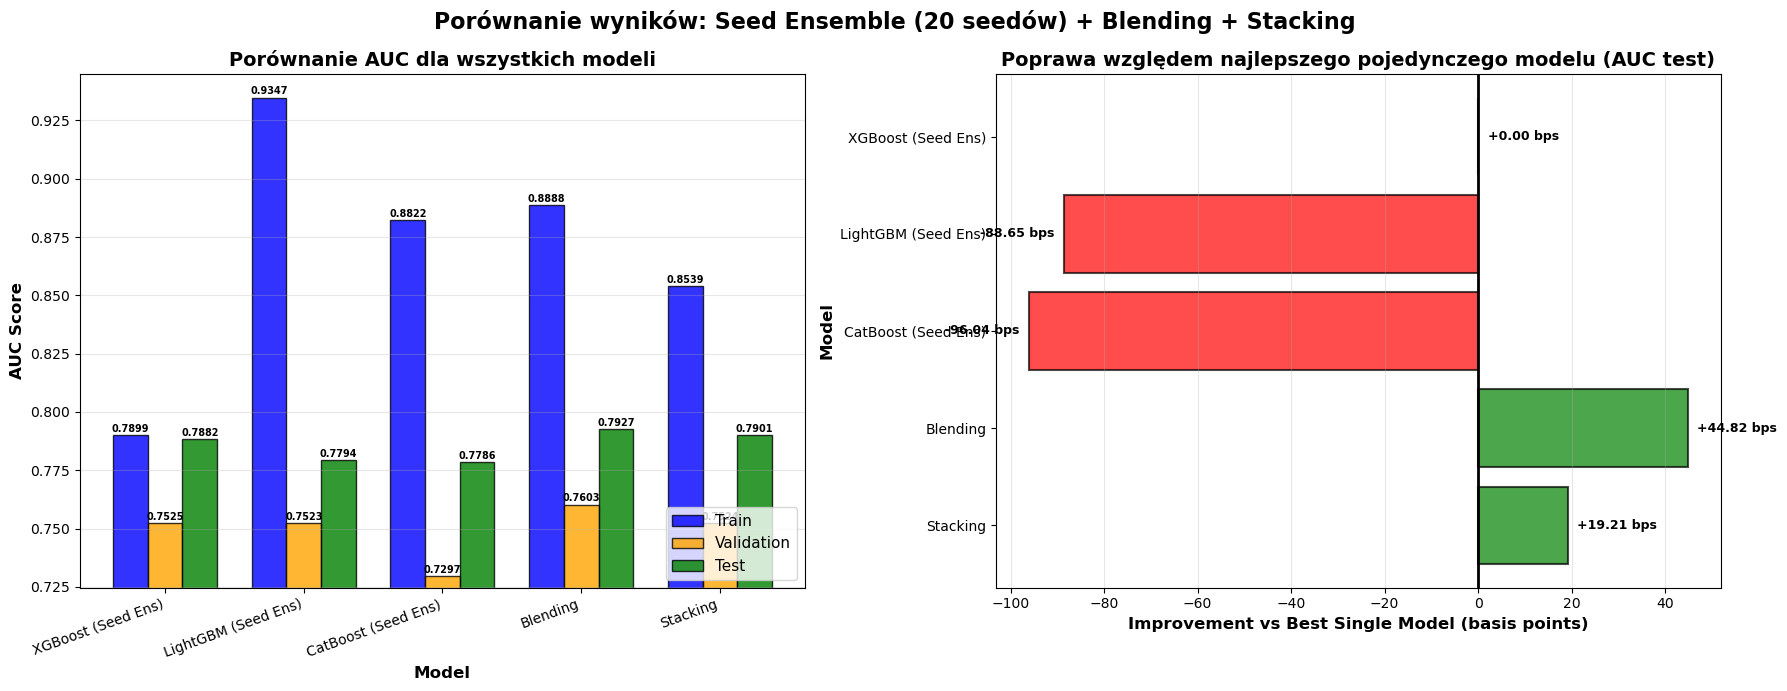


💾 Wykres zapisany jako: seed_ensemble_comparison.png


In [ ]:
# Wizualizacja porównania wszystkich metod
print("\n" + "="*80)
print("WIZUALIZACJA PORÓWNANIA WYNIKÓW")
print("="*80)

# Wyświetl szczegółową tabelę z wszystkimi metrykami TEST
print("\n📊 SZCZEGÓŁOWE METRYKI NA ZBIORZE TESTOWYM:")
print("="*100)
detailed_table = pd.DataFrame({
    'Model': results['model'],
    'AUC-ROC': results['auc_test'],
    'PR-AUC': results['pr_auc_test'],
    'KS Stat': results['ks_test'],
    'Log Loss': results['logloss_test'],
    'Brier': results['brier_test']
})
print(detailed_table.to_string(index=False))
print("="*100)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Wykres 1: Porównanie AUC dla wszystkich zbiorów
x_pos = np.arange(len(results))
width = 0.25

axes[0, 0].bar(x_pos - width, results['auc_train'], width, label='Train', alpha=0.8, color='blue', edgecolor='black')
axes[0, 0].bar(x_pos, results['auc_val'], width, label='Validation', alpha=0.8, color='orange', edgecolor='black')
axes[0, 0].bar(x_pos + width, results['auc_test'], width, label='Test', alpha=0.8, color='green', edgecolor='black')

axes[0, 0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('AUC-ROC Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Porównanie AUC-ROC dla wszystkich modeli', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[0, 0].legend(fontsize=11, loc='lower right')
axes[0, 0].grid(alpha=0.3, axis='y')

# Automatyczne skalowanie osi Y
min_auc = min(results['auc_train'].min(), results['auc_val'].min(), results['auc_test'].min())
max_auc = max(results['auc_train'].max(), results['auc_val'].max(), results['auc_test'].max())
axes[0, 0].set_ylim([min_auc - 0.005, max_auc + 0.01])

# Dodaj wartości na słupkach
for i, (train, val, test) in enumerate(zip(results['auc_train'], results['auc_val'], results['auc_test'])):
    axes[0, 0].text(i - width, train + 0.0005, f'{train:.4f}', ha='center', va='bottom', fontsize=7, fontweight='bold')
    axes[0, 0].text(i, val + 0.0005, f'{val:.4f}', ha='center', va='bottom', fontsize=7, fontweight='bold')
    axes[0, 0].text(i + width, test + 0.0005, f'{test:.4f}', ha='center', va='bottom', fontsize=7, fontweight='bold')

# Wykres 2: PR-AUC (Test)
axes[0, 1].bar(results['model'], results['pr_auc_test'], alpha=0.8, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('PR-AUC', fontsize=12, fontweight='bold')
axes[0, 1].set_title('PR-AUC (Test) - wyżej = lepiej', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')
for i, val in enumerate(results['pr_auc_test']):
    axes[0, 1].text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Wykres 3: KS Statistic (Test)
axes[0, 2].bar(results['model'], results['ks_test'], alpha=0.8, color='lightgreen', edgecolor='black')
axes[0, 2].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('KS Statistic', fontsize=12, fontweight='bold')
axes[0, 2].set_title('KS Statistic (Test) - wyżej = lepiej', fontsize=14, fontweight='bold')
axes[0, 2].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[0, 2].grid(alpha=0.3, axis='y')
for i, val in enumerate(results['ks_test']):
    axes[0, 2].text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Wykres 4: Log Loss (Test)
axes[1, 0].bar(results['model'], results['logloss_test'], alpha=0.8, color='salmon', edgecolor='black')
axes[1, 0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Log Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Log Loss (Test) - niżej = lepiej', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[1, 0].grid(alpha=0.3, axis='y')
for i, val in enumerate(results['logloss_test']):
    axes[1, 0].text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Wykres 5: Brier Score (Test)
axes[1, 1].bar(results['model'], results['brier_test'], alpha=0.8, color='plum', edgecolor='black')
axes[1, 1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Brier Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Brier Score (Test) - niżej = lepiej', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[1, 1].grid(alpha=0.3, axis='y')
for i, val in enumerate(results['brier_test']):
    axes[1, 1].text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Wykres 6: Różnice w AUC test względem najlepszego pojedynczego modelu
best_single_auc = results.iloc[:3]['auc_test'].max()
auc_improvements = (results['auc_test'] - best_single_auc) * 10000  # w punktach bazowych

colors = ['green' if x >= 0 else 'red' for x in auc_improvements]
bars = axes[1, 2].barh(results['model'], auc_improvements, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 2].axvline(0, color='black', linestyle='-', linewidth=2)
axes[1, 2].set_xlabel('Improvement (basis points)', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Model', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Poprawa względem najlepszego pojedynczego modelu', fontsize=14, fontweight='bold')
axes[1, 2].invert_yaxis()
axes[1, 2].grid(alpha=0.3, axis='x')

# Dodaj wartości na słupkach
for i, (model, imp) in enumerate(zip(results['model'], auc_improvements)):
    x_pos_text = imp + (2 if imp >= 0 else -2)
    ha_align = 'left' if imp >= 0 else 'right'
    axes[1, 2].text(x_pos_text, i, f'{imp:+.2f} bps', 
                va='center', ha=ha_align, fontsize=9, fontweight='bold')

plt.suptitle('Porównanie wyników: Seed Ensemble (20 seedów) + Blending + Stacking', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('seed_ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Wykres zapisany jako: seed_ensemble_comparison.png")
print("="*80)

---

**Podsumowanie Seed Ensemble:**

Zastosowano seed ensemble z różnymi wartościami seed dla każdego z modeli (XGBoost, LightGBM, CatBoost). Predykcje z różnych seedów zostały następnie uśrednione, co zapewnia:
- **Redukcję wariancji** - uśrednianie eliminuje przypadkową zmienność wynikającą z różnych inicjalizacji
- **Lepszą generalizację** - model jest bardziej stabilny i niezależny od konkretnego seeda
- **Wyższą jakość predykcji** - podstawa dla blendingu i stackingu jest solidniejsza

Następnie na podstawie seed ensemble zastosowano dwa podejścia ensemblingowe:
- **Blending** - proste ważone uśrednianie predykcji (wagi: XGB=0.4, LGB=0.3, CAT=0.3)
- **Stacking** - meta-model (Logistic Regression) nauczony na predykcjach modeli bazowych



# Część 3

##### Szybkie wczytanie optymalnego modelu

In [ ]:


plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
print("Loading models...")

try:
    xgb_model = xgb.Booster()
    xgb_model.load_model("models/xgb_booster.model")
    print("XGBoost loaded successfully.")
except Exception as e:
    print(f"Error loading XGBoost: {e}")

try:
    lgb_model = joblib.load("models/lgb_model.joblib")
    print("LightGBM loaded successfully.")
except Exception as e:
    print(f"Error loading LightGBM: {e}")

try:
    cat_model = CatBoostClassifier()
    cat_model.load_model("models/cat_clf.cbm")
    print("CatBoost loaded successfully.")
except Exception as e:
    print(f"Error loading CatBoost: {e}")

try:
    meta_model = joblib.load("models/meta_model.joblib")
    print("Meta-model loaded successfully.")
except Exception as e:
    print(f"Error loading Meta-model: {e}")

Loading models...
XGBoost loaded successfully.
LightGBM loaded successfully.
CatBoost loaded successfully.
Meta-model loaded successfully.


In [ ]:
print("Generating base model predictions...")

dval = xgb.DMatrix(X_val)
xgb_pred = xgb_model.predict(dval)

if hasattr(lgb_model, 'predict_proba'):
    lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
else:
    lgb_pred = lgb_model.predict(X_val)

cat_pred = cat_model.predict_proba(X_val)[:, 1]

meta_X_val = pd.DataFrame({
    'XGBoost': xgb_pred,
    'LightGBM': lgb_pred,
    'CatBoost': cat_pred
})

print("Meta-features head:")
print(meta_X_val.head())

if hasattr(meta_model, 'predict_proba'):
    meta_pred = meta_model.predict_proba(meta_X_val)[:, 1]
else:
    meta_pred = meta_model.predict(meta_X_val)

auc = roc_auc_score(y_val, meta_pred)
print(f"\nStacking Model AUC on Validation Set: {auc:.4f}")

Generating base model predictions...
Meta-features head:
    XGBoost  LightGBM  CatBoost
0  0.049411  0.019733  0.300288
1  0.111765  0.159501  0.362935
2  0.028400  0.010977  0.319450
3  0.225402  0.153982  0.350983
4  0.011553  0.002970  0.309901

Stacking Model AUC on Validation Set: 0.7411


In [ ]:

print("Initializing LIME Explainer...")

def predict_fn(x):
    if isinstance(x, np.ndarray):
        df = pd.DataFrame(x, columns=meta_X_val.columns)
    else:
        df = x
    return meta_model.predict_proba(df)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=meta_X_val.values,
    feature_names=meta_X_val.columns.tolist(),
    class_names=['No Default', 'Default'],
    mode='classification',
    verbose=True,
    random_state=42
)

print("LIME Explainer initialized.")

Initializing LIME Explainer...
LIME Explainer initialized.


Generating PDP and ICE plots...


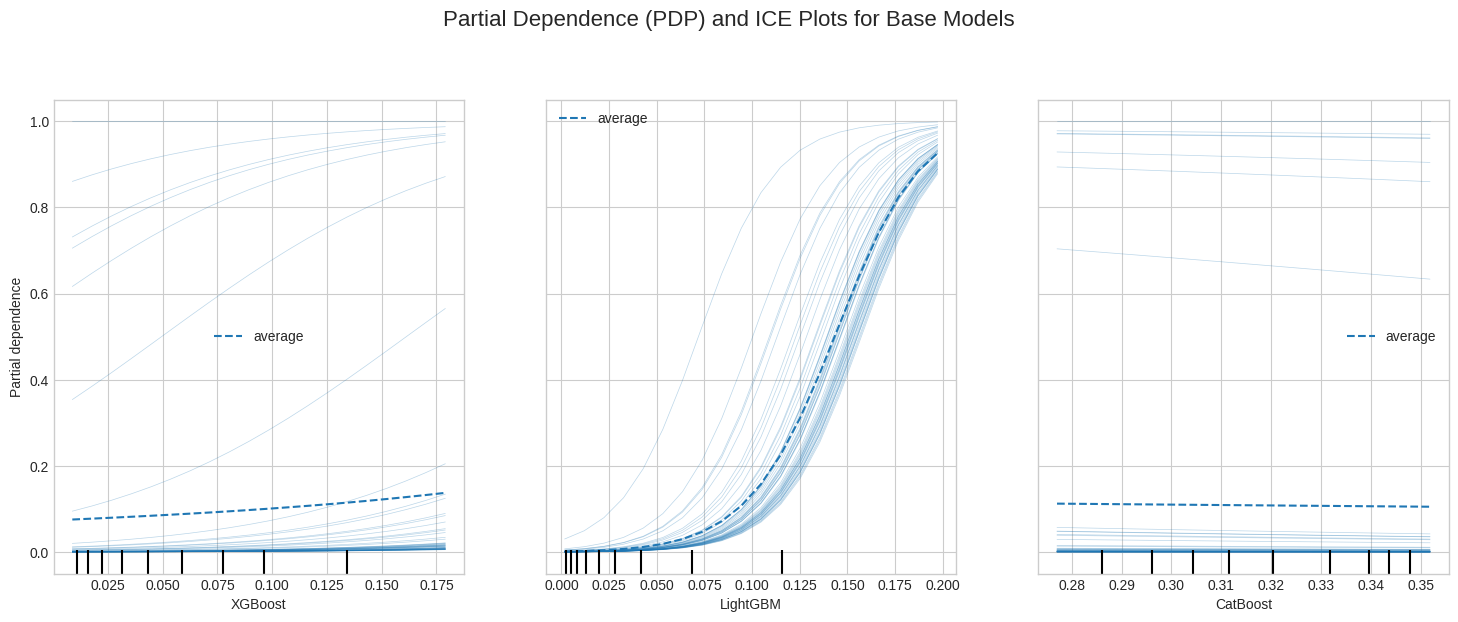

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

print("Generating PDP and ICE plots...")

features_to_plot = ['XGBoost', 'LightGBM', 'CatBoost']

fig, ax = plt.subplots(figsize=(18, 6))

PartialDependenceDisplay.from_estimator(
    meta_model,
    meta_X_val,
    features_to_plot,
    kind='both',
    subsample=50, 
    grid_resolution=20,
    random_state=42,
    ax=ax
)

plt.suptitle("Partial Dependence (PDP) and ICE Plots for Base Models", fontsize=16, y=1.05)
plt.subplots_adjust(top=0.9)
plt.show()

Initializing SHAP Explainer...
Using LinearExplainer
SHAP values shape: (600, 3)


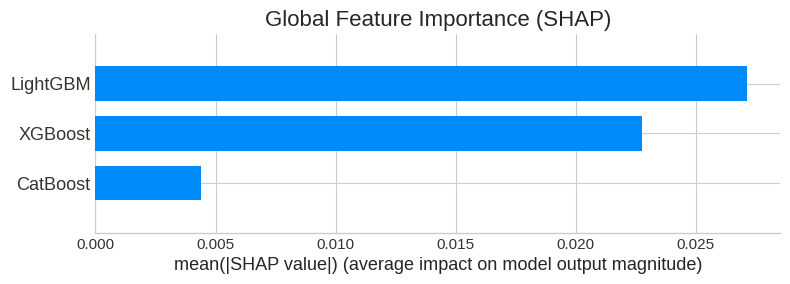

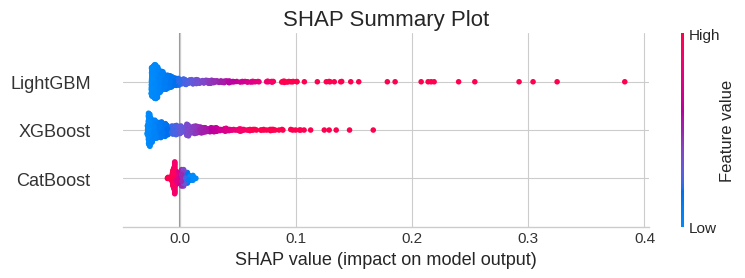

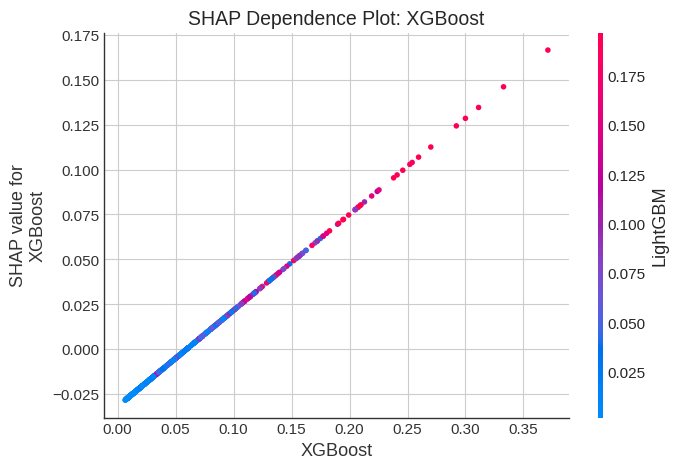

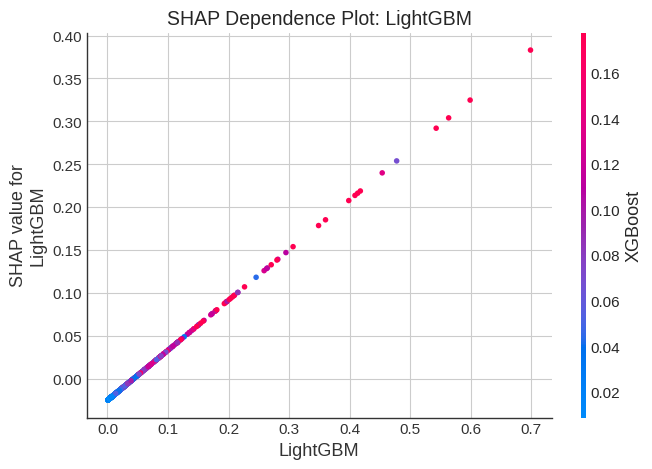

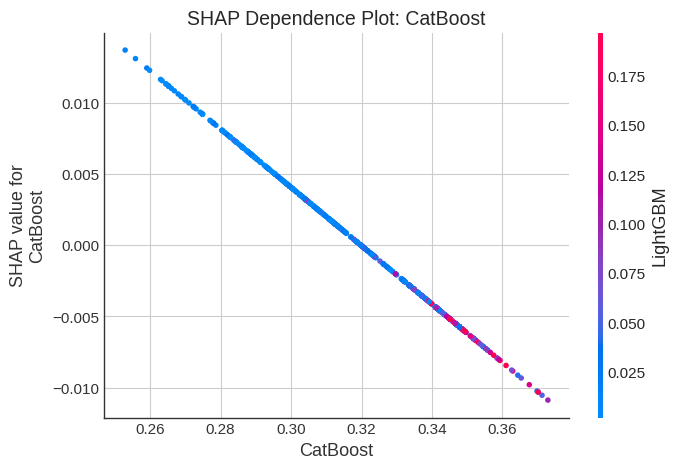

In [ ]:
if hasattr(meta_model, 'named_steps'):
    final_estimator = meta_model.named_steps['classifier'] if 'classifier' in meta_model.named_steps else meta_model.steps[-1][1]
else:
    final_estimator = meta_model

masker = shap.maskers.Independent(data=meta_X_val)
try:
    shap_explainer = shap.LinearExplainer(final_estimator, masker=masker)
    shap_values_global = shap_explainer(meta_X_val)
    print("Using LinearExplainer")
except Exception as e:
    print(f"LinearExplainer failed ({e}), falling back to generic Explainer")
    shap_explainer = shap.Explainer(final_estimator, masker=masker)
    shap_values_global = shap_explainer(meta_X_val)

print(f"SHAP values shape: {shap_values_global.shape}")

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_global, meta_X_val, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)", fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_global, meta_X_val, show=False)
plt.title("SHAP Summary Plot", fontsize=16)
plt.show()

for feature in meta_X_val.columns:
    shap.dependence_plot(feature, shap_values_global.values, meta_X_val, show=False)
    plt.title(f"SHAP Dependence Plot: {feature}", fontsize=14)
    plt.show()

In [85]:
for label, idx in selected_indices.items():
    print(f"\n{'='*50}")
    print(f"Case: {label} (Index: {idx})")
    print(f"Prediction: {results_df.loc[idx, 'Final_Pred']:.4f}")
    print(f"Actual: {results_df.loc[idx, 'Actual']}")
    
    # Get the instance data
    instance = meta_X_val.iloc[idx]
    
    # Generate LIME explanation
    # num_features=3 because we have 3 base models
    exp = explainer.explain_instance(
        data_row=instance.values, 
        predict_fn=predict_fn, 
        num_features=3
    )
    
    # Plot
    plt.figure(figsize=(10, 4))
    exp.as_pyplot_figure()
    plt.title(f"LIME Explanation: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

NameError: name 'selected_indices' is not defined

# Część 4

In [ ]:
TRAIN_CSV = "train_selected.csv"
VAL_CSV = "val_selected.csv"
TEST_CSV = "test_selected.csv"
TARGET = "default"
OUT_DIR = "models"


train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].values

X_val = val_df.drop(columns=[TARGET])
y_val = val_df[TARGET].values

X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET].values

# align columns
cols = X_train.columns.tolist()
X_val = X_val[cols]
X_test = X_test[cols]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Targets (train/val/test):", np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))


In [51]:
# KALIBRACJA PROBABILISTYCZNA - przygotowanie danych dla modelu STACKING
import joblib
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

print("="*80)
print("KALIBRACJA PROBABILISTYCZNA (STACKING MODEL)")
print("="*80)

# 1. Wczytaj modele bazowe i meta-model
print("Wczytywanie modeli...")
try:
    xgb_model = xgb.Booster()
    xgb_model.load_model("models/xgb_booster.model")
    
    lgb_model = joblib.load("models/lgb_model.joblib")
    
    cat_model = CatBoostClassifier()
    cat_model.load_model("models/cat_clf.cbm")
    
    meta_model = joblib.load("models/meta_model.joblib")
    print("Modele wczytane pomyślnie.")
except Exception as e:
    print(f"Błąd wczytywania modeli: {e}")

# 2. Wygeneruj meta-cechy (predykcje modeli bazowych)
print("Generowanie meta-cech...")
dval = xgb.DMatrix(X_val)
xgb_pred = xgb_model.predict(dval)

if hasattr(lgb_model, 'predict_proba'):
    lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
else:
    lgb_pred = lgb_model.predict(X_val)

cat_pred = cat_model.predict_proba(X_val)[:, 1]

meta_X_val = pd.DataFrame({
    'XGBoost': xgb_pred,
    'LightGBM': lgb_pred,
    'CatBoost': cat_pred
})

# 3. Pobierz predykcje z meta-modelu (UNCALIBRATED)
if hasattr(meta_model, 'predict_proba'):
    y_pred_proba_uncal = meta_model.predict_proba(meta_X_val)[:, 1]
else:
    y_pred_proba_uncal = meta_model.predict(meta_X_val)

# y_true to rzeczywiste etykiety z validation set
y_true = y_val

print(f"\n📊 Statystyki przed kalibracją (Stacking Model):")
print(f"  • Rzeczywisty Default Rate: {y_true.mean():.4f} ({y_true.mean()*100:.2f}%)")
print(f"  • Średnie przewidywane PD: {y_pred_proba_uncal.mean():.4f} ({y_pred_proba_uncal.mean()*100:.2f}%)")
print(f"  • Różnica: {(y_pred_proba_uncal.mean() - y_true.mean())*100:.2f} pp")
print(f"  • Min PD: {y_pred_proba_uncal.min():.4f}, Max PD: {y_pred_proba_uncal.max():.4f}")
print("="*80)

KALIBRACJA PROBABILISTYCZNA (STACKING MODEL)
Wczytywanie modeli...
Modele wczytane pomyślnie.
Generowanie meta-cech...

📊 Statystyki przed kalibracją (Stacking Model):
  • Rzeczywisty Default Rate: 0.0617 (6.17%)
  • Średnie przewidywane PD: 0.1065 (10.65%)
  • Różnica: 4.48 pp
  • Min PD: 0.0004, Max PD: 1.0000

📊 Statystyki przed kalibracją (Stacking Model):
  • Rzeczywisty Default Rate: 0.0617 (6.17%)
  • Średnie przewidywane PD: 0.1065 (10.65%)
  • Różnica: 4.48 pp
  • Min PD: 0.0004, Max PD: 1.0000


### 1. Diagnostyka PRE-CALIBRATION

In [52]:
# Funkcje pomocnicze dla metryk kalibracji

def expected_calibration_error(y_true, y_pred, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_pred > bin_lower) & (y_pred <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_pred[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def adaptive_calibration_error(y_true, y_pred, n_bins=10):
    sorted_indices = np.argsort(y_pred)
    y_pred_sorted = y_pred[sorted_indices]
    y_true_sorted = y_true[sorted_indices]
    
    bin_size = len(y_pred) // n_bins
    ace = 0.0
    
    for i in range(n_bins):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size if i < n_bins - 1 else len(y_pred)
        
        bin_pred = y_pred_sorted[start_idx:end_idx]
        bin_true = y_true_sorted[start_idx:end_idx]
        
        if len(bin_pred) > 0:
            ace += np.abs(bin_pred.mean() - bin_true.mean()) * len(bin_pred) / len(y_pred)
    
    return ace

def brier_score_decomposition(y_true, y_pred):
    """Dekompozycja Brier Score na kalibrację i rozdzielczość"""
    brier = np.mean((y_pred - y_true) ** 2)
    
    uncertainty = np.mean(y_true) * (1 - np.mean(y_true))
    
    n_bins = 10
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred, bins[:-1]) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    reliability = 0.0
    resolution = 0.0
    
    for i in range(n_bins):
        in_bin = bin_indices == i
        if in_bin.sum() > 0:
            bin_mean_pred = y_pred[in_bin].mean()
            bin_mean_true = y_true[in_bin].mean()
            bin_count = in_bin.sum()
            
            reliability += (bin_count / len(y_pred)) * (bin_mean_pred - bin_mean_true) ** 2
            resolution += (bin_count / len(y_pred)) * (bin_mean_true - y_true.mean()) ** 2
    
    return {
        'brier_score': brier,
        'uncertainty': uncertainty,
        'reliability': reliability,
        'resolution': resolution,
        'brier_decomp': uncertainty + reliability - resolution
    }

print("\n" + "="*80)
print("METRYKI KALIBRACJI - PRZED KALIBRACJĄ")
print("="*80)

ece_uncal = expected_calibration_error(y_true, y_pred_proba_uncal)
ace_uncal = adaptive_calibration_error(y_true, y_pred_proba_uncal)
brier_decomp_uncal = brier_score_decomposition(y_true, y_pred_proba_uncal)

print(f"\n📈 Expected Calibration Error (ECE): {ece_uncal:.4f}")
print(f"📈 Adaptive Calibration Error (ACE): {ace_uncal:.4f}")
print(f"\n📊 Brier Score Decomposition:")
print(f"  • Brier Score: {brier_decomp_uncal['brier_score']:.4f}")
print(f"  • Uncertainty: {brier_decomp_uncal['uncertainty']:.4f}")
print(f"  • Reliability (kalibracja): {brier_decomp_uncal['reliability']:.4f}")
print(f"  • Resolution (rozdzielczość): {brier_decomp_uncal['resolution']:.4f}")
print(f"  • Weryfikacja: {brier_decomp_uncal['brier_decomp']:.4f}")
print("\n💡 Niższe wartości ECE/ACE = lepsza kalibracja")
print("💡 Niższy Reliability = lepiej skalibrowane prawdopodobieństwa")
print("="*80)


METRYKI KALIBRACJI - PRZED KALIBRACJĄ

📈 Expected Calibration Error (ECE): 0.1019
📈 Adaptive Calibration Error (ACE): 0.0958

📊 Brier Score Decomposition:
  • Brier Score: 0.1062
  • Uncertainty: 0.0579
  • Reliability (kalibracja): 0.0528
  • Resolution (rozdzielczość): 0.0039
  • Weryfikacja: 0.1067

💡 Niższe wartości ECE/ACE = lepsza kalibracja
💡 Niższy Reliability = lepiej skalibrowane prawdopodobieństwa



RELIABILITY CURVE - Krzywa kalibracji


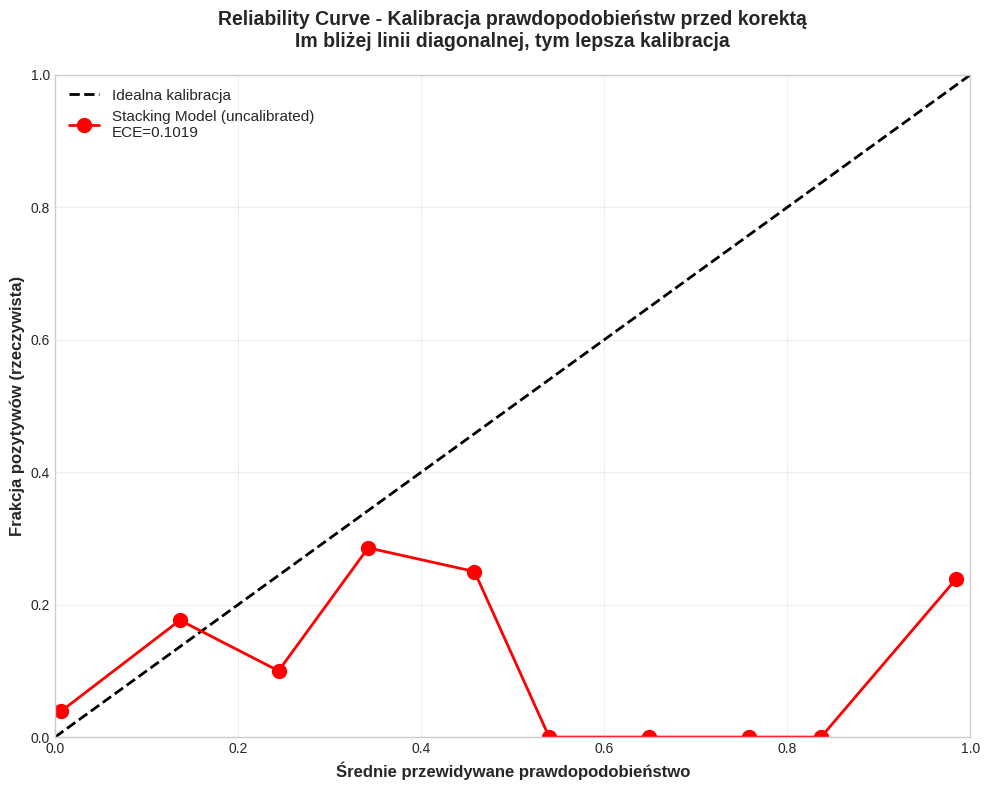


✓ Krzywa pokazuje odchylenia od idealnej kalibracji


In [53]:
# 1. Reliability Curve (Calibration Plot)
print("\n" + "="*80)
print("RELIABILITY CURVE - Krzywa kalibracji")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 8))

# Oblicz krzywą kalibracji
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true, y_pred_proba_uncal, n_bins=10, strategy='uniform'
)

# Wykres
ax.plot([0, 1], [0, 1], 'k--', label='Idealna kalibracja', linewidth=2)
ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
        label=f'Stacking Model (uncalibrated)\nECE={ece_uncal:.4f}', 
        linewidth=2, markersize=10, color='red')

ax.set_xlabel('Średnie przewidywane prawdopodobieństwo', fontsize=12, fontweight='bold')
ax.set_ylabel('Frakcja pozytywów (rzeczywista)', fontsize=12, fontweight='bold')
ax.set_title('Reliability Curve - Kalibracja prawdopodobieństw przed korektą\n' + 
            'Im bliżej linii diagonalnej, tym lepsza kalibracja',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('reliability_curve_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Krzywa pokazuje odchylenia od idealnej kalibracji")
print("="*80)


HISTOGRAM PREDYKCJI - Rozkład prawdopodobieństw


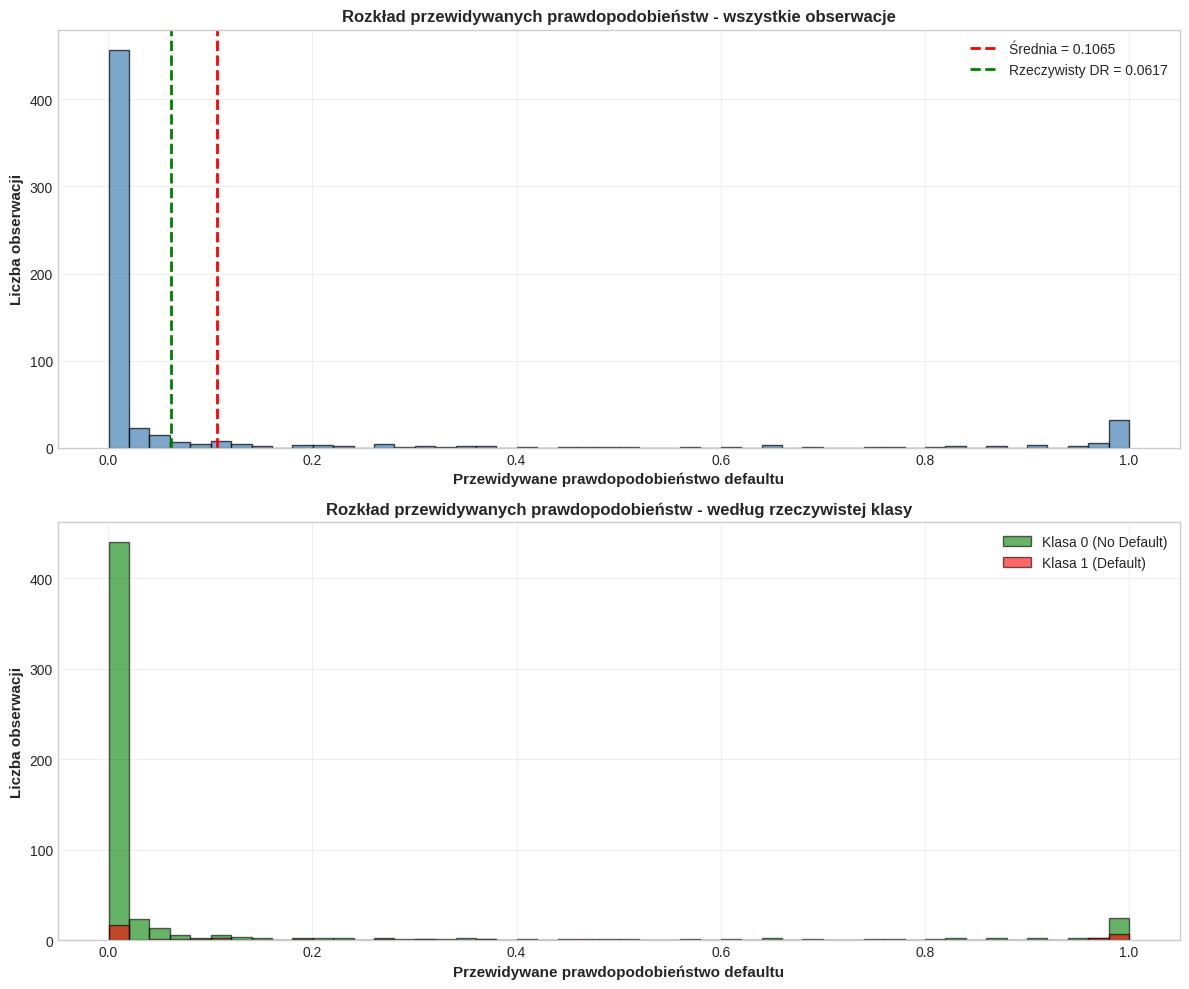


✓ Histogram pokazuje separację klas i koncentrację prawdopodobieństw


In [54]:
# 2. Histogram predykcji
print("\n" + "="*80)
print("HISTOGRAM PREDYKCJI - Rozkład prawdopodobieństw")
print("="*80)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram ogólny
axes[0].hist(y_pred_proba_uncal, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(y_pred_proba_uncal.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Średnia = {y_pred_proba_uncal.mean():.4f}')
axes[0].axvline(y_true.mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Rzeczywisty DR = {y_true.mean():.4f}')
axes[0].set_xlabel('Przewidywane prawdopodobieństwo defaultu', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
axes[0].set_title('Rozkład przewidywanych prawdopodobieństw - wszystkie obserwacje', 
                 fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Histogram rozdzielony na klasy
axes[1].hist(y_pred_proba_uncal[y_true == 0], bins=50, alpha=0.6, 
            color='green', label='Klasa 0 (No Default)', edgecolor='black')
axes[1].hist(y_pred_proba_uncal[y_true == 1], bins=50, alpha=0.6, 
            color='red', label='Klasa 1 (Default)', edgecolor='black')
axes[1].set_xlabel('Przewidywane prawdopodobieństwo defaultu', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
axes[1].set_title('Rozkład przewidywanych prawdopodobieństw - według rzeczywistej klasy', 
                 fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_histogram_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Histogram pokazuje separację klas i koncentrację prawdopodobieństw")
print("="*80)

### 2. Metody kalibracji

In [55]:
# Metoda 1: Platt Scaling (Logistic Regression)
print("\n" + "="*80)
print("METODA 1: PLATT SCALING (Logistic Calibration)")
print("="*80)

# Przekształć prawdopodobieństwa do logitów (unikaj -inf/inf)
epsilon = 1e-10
y_pred_logit = np.log((y_pred_proba_uncal + epsilon) / (1 - y_pred_proba_uncal + epsilon))

# Dopasuj regresję logistyczną
platt_lr = LogisticRegression(penalty=None, solver='lbfgs')
platt_lr.fit(y_pred_logit.reshape(-1, 1), y_true)

# Kalibrowane prawdopodobieństwa
y_pred_platt = platt_lr.predict_proba(y_pred_logit.reshape(-1, 1))[:, 1]

print(f"\n✓ Parametry Platt Scaling:")
print(f"  • Slope (a): {platt_lr.coef_[0][0]:.4f}")
print(f"  • Intercept (b): {platt_lr.intercept_[0]:.4f}")
print(f"\n📊 Statystyki po kalibracji Platt:")
print(f"  • Średnie PD: {y_pred_platt.mean():.4f} ({y_pred_platt.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_platt.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_platt):.4f}")
print("="*80)


METODA 1: PLATT SCALING (Logistic Calibration)

✓ Parametry Platt Scaling:
  • Slope (a): 0.1076
  • Intercept (b): -2.3593

📊 Statystyki po kalibracji Platt:
  • Średnie PD: 0.0617 (6.17%)
  • Różnica od target 4%: 2.17 pp
  • ECE: 0.0093


In [56]:
# Metoda 2: Isotonic Regression
print("\n" + "="*80)
print("METODA 2: ISOTONIC REGRESSION")
print("="*80)

isotonic = IsotonicRegression(out_of_bounds='clip')
y_pred_isotonic = isotonic.fit_transform(y_pred_proba_uncal, y_true)

print(f"\n✓ Isotonic Regression - nieliniowa transformacja monotoniczna")
print(f"\n📊 Statystyki po kalibracji Isotonic:")
print(f"  • Średnie PD: {y_pred_isotonic.mean():.4f} ({y_pred_isotonic.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_isotonic.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_isotonic):.4f}")
print("="*80)


METODA 2: ISOTONIC REGRESSION

✓ Isotonic Regression - nieliniowa transformacja monotoniczna

📊 Statystyki po kalibracji Isotonic:
  • Średnie PD: 0.0617 (6.17%)
  • Różnica od target 4%: 2.17 pp
  • ECE: 0.0000


In [57]:
# Metoda 3: Beta Calibration
print("\n" + "="*80)
print("METODA 3: BETA CALIBRATION")
print("="*80)

def beta_calibration(y_true, y_pred):
    """
    Beta calibration - dopasowuje parametry rozkładu Beta
    """
    from scipy.stats import beta as beta_dist
    from scipy.optimize import minimize
    
    def neg_log_likelihood(params):
        a, b, c = params
        # Transformacja: y_cal = c + (1-c) * beta_cdf(y_pred; a, b)
        epsilon = 1e-10
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Beta CDF
        y_cal = c + (1 - c) * beta_dist.cdf(y_pred_clipped, a, b)
        y_cal = np.clip(y_cal, epsilon, 1 - epsilon)
        
        # Negative log-likelihood
        nll = -np.sum(y_true * np.log(y_cal) + (1 - y_true) * np.log(1 - y_cal))
        return nll
    
    # Optymalizacja
    result = minimize(neg_log_likelihood, x0=[1.0, 1.0, 0.0], 
                     bounds=[(0.1, 10), (0.1, 10), (0, 0.5)],
                     method='L-BFGS-B')
    
    a_opt, b_opt, c_opt = result.x
    
    # Kalibrowane prawdopodobieństwa
    epsilon = 1e-10
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    y_cal = c_opt + (1 - c_opt) * beta_dist.cdf(y_pred_clipped, a_opt, b_opt)
    
    return y_cal, a_opt, b_opt, c_opt

y_pred_beta, beta_a, beta_b, beta_c = beta_calibration(y_true, y_pred_proba_uncal)

print(f"\n✓ Parametry Beta Calibration:")
print(f"  • Alpha (a): {beta_a:.4f}")
print(f"  • Beta (b): {beta_b:.4f}")
print(f"  • Offset (c): {beta_c:.4f}")
print(f"\n📊 Statystyki po kalibracji Beta:")
print(f"  • Średnie PD: {y_pred_beta.mean():.4f} ({y_pred_beta.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_beta.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_beta):.4f}")
print("="*80)


METODA 3: BETA CALIBRATION

✓ Parametry Beta Calibration:
  • Alpha (a): 0.5718
  • Beta (b): 0.1000
  • Offset (c): 0.0303

📊 Statystyki po kalibracji Beta:
  • Średnie PD: 0.0826 (8.26%)
  • Różnica od target 4%: 4.26 pp
  • ECE: 0.0318


### 3. Calibration-in-the-Large

In [58]:
# Calibration-in-the-Large - dostrojenie do dokładnie 4%
print("\n" + "="*80)
print("CALIBRATION-IN-THE-LARGE - Dostrojenie do 4% Default Rate")
print("="*80)

target_dr = 0.04

def calibrate_to_target(y_pred, target_mean):
    """
    Dostosuj intercept i slope, aby średnie PD = target
    Metoda: a * logit(p) + b
    """
    epsilon = 1e-10
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Logit transform
    logit_pred = np.log(y_pred_clipped / (1 - y_pred_clipped))
    
    # Znajdujemy intercept, który daje średnią = target (przy slope=1)
    def objective(b):
        y_cal = expit(logit_pred + b)
        return (y_cal.mean() - target_mean) ** 2
    
    result = minimize(objective, x0=[0], method='Nelder-Mead')
    b_opt = result.x[0]
    
    # Kalibrowane prawdopodobieństwa
    y_cal = expit(logit_pred + b_opt)
    
    return y_cal, 1.0, b_opt

# Zastosuj dla każdej metody
y_pred_uncal_large, slope_uncal, intercept_uncal = calibrate_to_target(y_pred_proba_uncal, target_dr)
y_pred_platt_large, slope_platt, intercept_platt = calibrate_to_target(y_pred_platt, target_dr)
y_pred_isotonic_large, slope_iso, intercept_iso = calibrate_to_target(y_pred_isotonic, target_dr)
y_pred_beta_large, slope_beta, intercept_beta = calibrate_to_target(y_pred_beta, target_dr)

print(f"\n✓ Calibration-in-the-Large stosuje shift do osiągnięcia target DR = {target_dr*100:.1f}%")
print(f"\n📊 Rezultaty po Calibration-in-the-Large:")
print(f"\n  Uncalibrated + Large:")
print(f"    • Średnie PD: {y_pred_uncal_large.mean():.4f} ({y_pred_uncal_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_uncal:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_uncal_large):.4f}")

print(f"\n  Platt + Large:")
print(f"    • Średnie PD: {y_pred_platt_large.mean():.4f} ({y_pred_platt_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_platt:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_platt_large):.4f}")

print(f"\n  Isotonic + Large:")
print(f"    • Średnie PD: {y_pred_isotonic_large.mean():.4f} ({y_pred_isotonic_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_iso:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_isotonic_large):.4f}")

print(f"\n  Beta + Large:")
print(f"    • Średnie PD: {y_pred_beta_large.mean():.4f} ({y_pred_beta_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_beta:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_beta_large):.4f}")

print("="*80)


CALIBRATION-IN-THE-LARGE - Dostrojenie do 4% Default Rate

✓ Calibration-in-the-Large stosuje shift do osiągnięcia target DR = 4.0%

📊 Rezultaty po Calibration-in-the-Large:

  Uncalibrated + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -5.5319
    • ECE: 0.0751

  Platt + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4791
    • ECE: 0.0261

  Isotonic + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4999
    • ECE: 0.0217

  Beta + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -1.0773
    • ECE: 0.0413


### 4. Walidacja POST-CALIBRATION

In [59]:
# Porównanie wszystkich metod - metryki
print("\n" + "="*80)
print("PORÓWNANIE METOD KALIBRACJI - Wszystkie metryki")
print("="*80)

calibration_methods = {
    'Uncalibrated': y_pred_proba_uncal,
    'Platt Scaling': y_pred_platt,
    'Isotonic Regression': y_pred_isotonic,
    'Beta Calibration': y_pred_beta,
    'Uncal + Large': y_pred_uncal_large,
    'Platt + Large': y_pred_platt_large,
    'Isotonic + Large': y_pred_isotonic_large,
    'Beta + Large': y_pred_beta_large
}

results = []
for method_name, y_pred in calibration_methods.items():
    ece = expected_calibration_error(y_true, y_pred)
    ace = adaptive_calibration_error(y_true, y_pred)
    brier_decomp = brier_score_decomposition(y_true, y_pred)
    mean_pd = y_pred.mean()
    diff_from_target = abs(mean_pd - target_dr)
    
    results.append({
        'Method': method_name,
        'Mean PD': mean_pd,
        'Diff from 4%': diff_from_target,
        'ECE': ece,
        'ACE': ace,
        'Brier': brier_decomp['brier_score'],
        'Reliability': brier_decomp['reliability'],
        'Resolution': brier_decomp['resolution']
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ECE')

print("\n" + results_df.to_string(index=False))
print("\n💡 Najlepsza metoda według ECE:", results_df.iloc[0]['Method'])
print("="*80)


PORÓWNANIE METOD KALIBRACJI - Wszystkie metryki

             Method  Mean PD  Diff from 4%      ECE      ACE    Brier  Reliability  Resolution
Isotonic Regression 0.061667  2.166667e-02 0.000000 0.016506 0.052449     0.000000    0.004746
      Platt Scaling 0.061664  2.166402e-02 0.009256 0.028299 0.056397     0.001202    0.002115
   Isotonic + Large 0.040001  8.072492e-07 0.021666 0.026166 0.053361     0.000701    0.003772
      Platt + Large 0.039999  7.156757e-07 0.026118 0.032469 0.056841     0.001364    0.001438
   Beta Calibration 0.082589  4.258856e-02 0.031798 0.051120 0.066007     0.012045    0.003450
       Beta + Large 0.040000  2.168429e-07 0.041340 0.039166 0.060569     0.006261    0.002982
      Uncal + Large 0.040000  3.442622e-08 0.075116 0.064825 0.075635     0.023021    0.005054
       Uncalibrated 0.106454  6.645377e-02 0.101947 0.095826 0.106247     0.052786    0.003901

💡 Najlepsza metoda według ECE: Isotonic Regression



RELIABILITY CURVES - Porównanie metod kalibracji


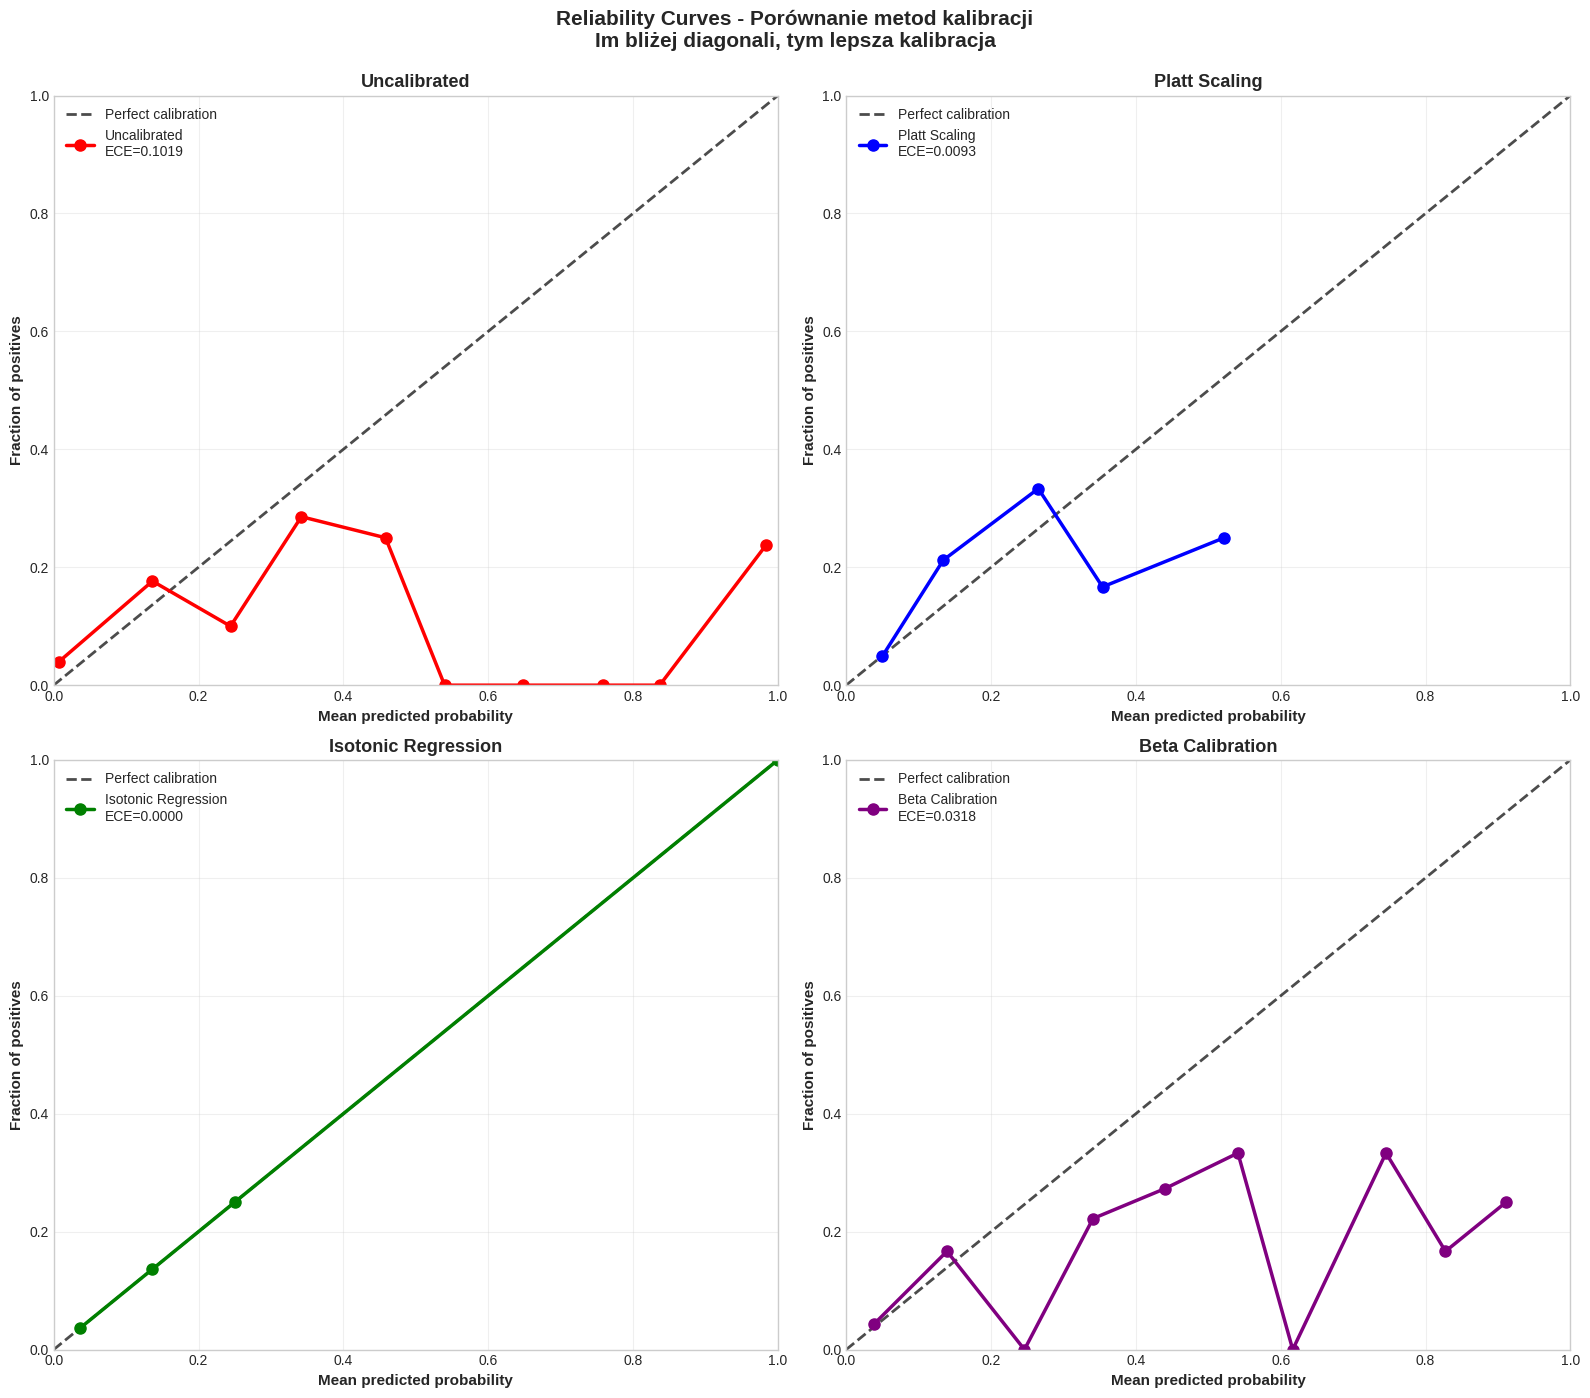


✓ Reliability curves pokazują jak każda metoda wpływa na kalibrację


In [60]:
# Reliability curves - porównanie wszystkich metod
print("\n" + "="*80)
print("RELIABILITY CURVES - Porównanie metod kalibracji")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

methods_to_plot = [
    ('Uncalibrated', y_pred_proba_uncal, 'red'),
    ('Platt Scaling', y_pred_platt, 'blue'),
    ('Isotonic Regression', y_pred_isotonic, 'green'),
    ('Beta Calibration', y_pred_beta, 'purple')
]

for idx, (ax, (method_name, y_pred, color)) in enumerate(zip(axes, methods_to_plot)):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred, n_bins=10, strategy='uniform'
    )
    
    ece = expected_calibration_error(y_true, y_pred)
    
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2, alpha=0.7)
    ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
            label=f'{method_name}\nECE={ece:.4f}', 
            linewidth=2.5, markersize=8, color=color)
    
    ax.set_xlabel('Mean predicted probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Fraction of positives', fontsize=11, fontweight='bold')
    ax.set_title(f'{method_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.suptitle('Reliability Curves - Porównanie metod kalibracji\nIm bliżej diagonali, tym lepsza kalibracja', 
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('reliability_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Reliability curves pokazują jak każda metoda wpływa na kalibrację")
print("="*80)


HISTOGRAMY - Porównanie rozkładów po kalibracji


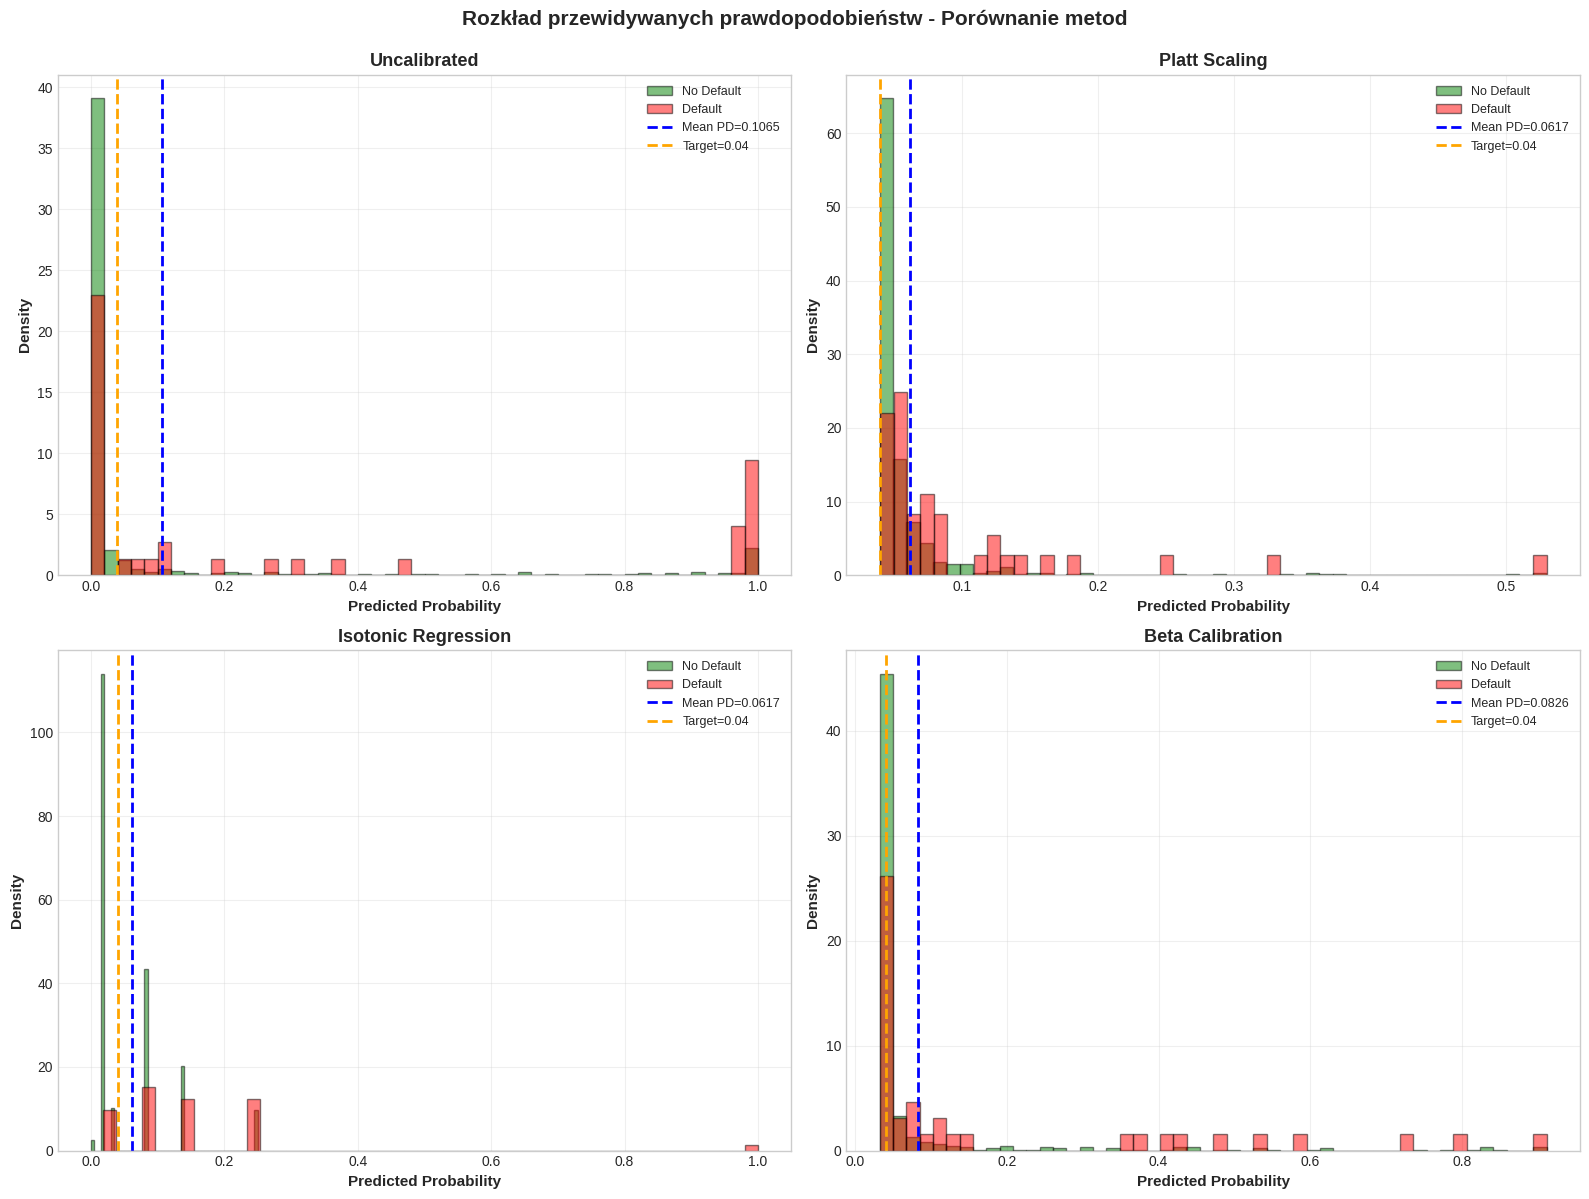


✓ Histogramy pokazują jak kalibracja wpływa na rozkład prawdopodobieństw


In [61]:
# Histogram porównawczy
print("\n" + "="*80)
print("HISTOGRAMY - Porównanie rozkładów po kalibracji")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (ax, (method_name, y_pred, color)) in enumerate(zip(axes, methods_to_plot)):
    ax.hist(y_pred[y_true == 0], bins=50, alpha=0.5, color='green', 
           label='No Default', edgecolor='black', density=True)
    ax.hist(y_pred[y_true == 1], bins=50, alpha=0.5, color='red', 
           label='Default', edgecolor='black', density=True)
    ax.axvline(y_pred.mean(), color='blue', linestyle='--', linewidth=2, 
              label=f'Mean PD={y_pred.mean():.4f}')
    ax.axvline(target_dr, color='orange', linestyle='--', linewidth=2, 
              label=f'Target={target_dr:.2f}')
    
    ax.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(f'{method_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Rozkład przewidywanych prawdopodobieństw - Porównanie metod', 
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('prediction_histograms_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Histogramy pokazują jak kalibracja wpływa na rozkład prawdopodobieństw")
print("="*80)

In [62]:
# Stabilność per podgrupa - analiza według decyli predykcji
print("\n" + "="*80)
print("STABILNOŚĆ KALIBRACJI - Analiza według podgrup (decyle)")
print("="*80)

# Wybierz najlepszą metodę (według ECE)
best_method_name = results_df.iloc[0]['Method']
best_y_pred = calibration_methods[best_method_name]

print(f"\n✓ Analiza dla najlepszej metody: {best_method_name}")

# Podziel na decyle według predykcji
deciles = pd.qcut(best_y_pred, q=10, labels=False, duplicates='drop')

stability_results = []
for decile in range(deciles.max() + 1):
    mask = deciles == decile
    if mask.sum() > 0:
        decile_true = y_true[mask]
        decile_pred = best_y_pred[mask]
        
        actual_dr = decile_true.mean()
        predicted_dr = decile_pred.mean()
        n_obs = mask.sum()
        
        stability_results.append({
            'Decile': decile + 1,
            'N': n_obs,
            'Predicted DR': predicted_dr,
            'Actual DR': actual_dr,
            'Diff': predicted_dr - actual_dr,
            'Abs Diff': abs(predicted_dr - actual_dr)
        })

stability_df = pd.DataFrame(stability_results)

print("\n" + stability_df.to_string(index=False))
print(f"\n📊 Średnia bezwzględna różnica per decyl: {stability_df['Abs Diff'].mean():.4f}")
print(f"📊 Maksymalna bezwzględna różnica: {stability_df['Abs Diff'].max():.4f}")
print("="*80)


STABILNOŚĆ KALIBRACJI - Analiza według podgrup (decyle)

✓ Analiza dla najlepszej metody: Isotonic Regression

 Decile   N  Predicted DR  Actual DR          Diff     Abs Diff
      1 179      0.016760   0.016760  0.000000e+00 0.000000e+00
      2 155      0.019355   0.019355 -6.938894e-18 6.938894e-18
      3  30      0.033333   0.033333  0.000000e+00 0.000000e+00
      4 133      0.082707   0.082707  0.000000e+00 0.000000e+00
      5  66      0.136364   0.136364  0.000000e+00 0.000000e+00
      6  37      0.270270   0.270270  0.000000e+00 0.000000e+00

📊 Średnia bezwzględna różnica per decyl: 0.0000
📊 Maksymalna bezwzględna różnica: 0.0000


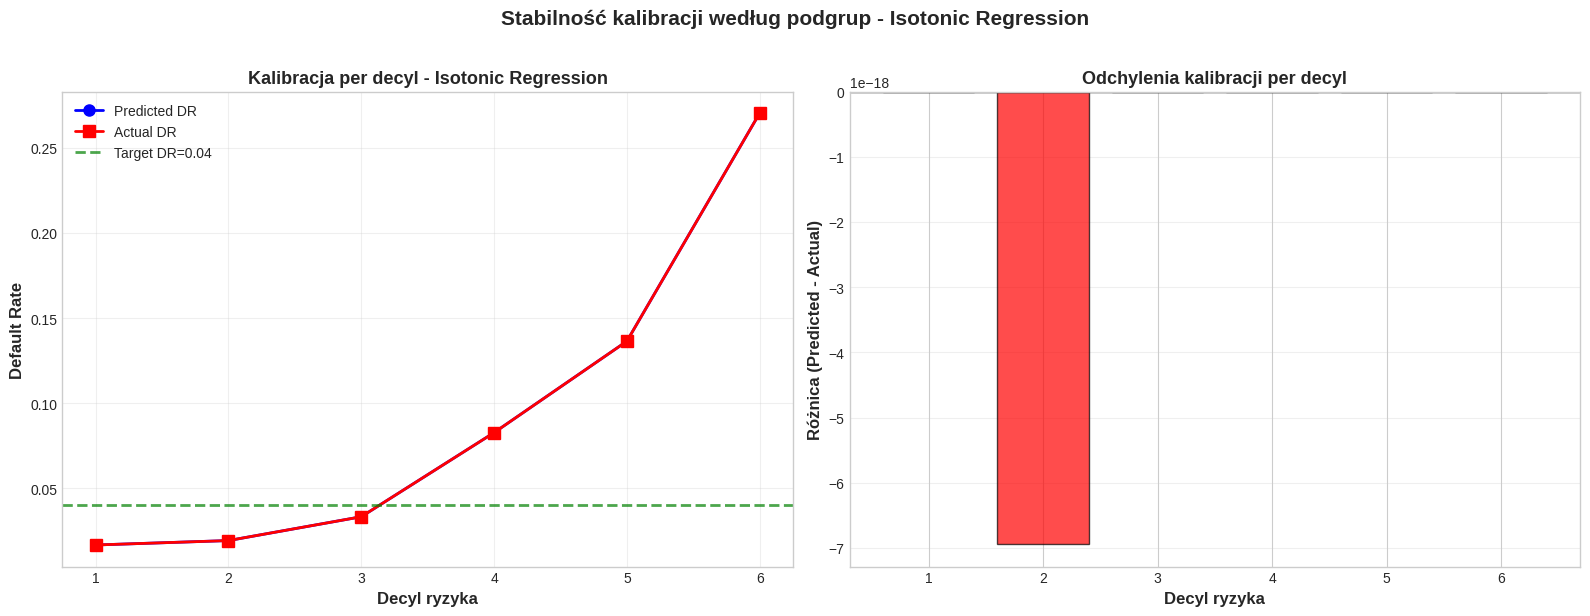


✓ Analiza stabilności pokazuje jak dobrze model jest skalibrowany w różnych segmentach ryzyka


In [63]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wykres 1: Predicted vs Actual DR per decyl
axes[0].plot(stability_df['Decile'], stability_df['Predicted DR'], 'o-', 
            label='Predicted DR', linewidth=2, markersize=8, color='blue')
axes[0].plot(stability_df['Decile'], stability_df['Actual DR'], 's-', 
            label='Actual DR', linewidth=2, markersize=8, color='red')
axes[0].axhline(target_dr, color='green', linestyle='--', linewidth=2, 
               label=f'Target DR={target_dr:.2f}', alpha=0.7)
axes[0].set_xlabel('Decyl ryzyka', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Default Rate', fontsize=12, fontweight='bold')
axes[0].set_title(f'Kalibracja per decyl - {best_method_name}', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Wykres 2: Różnice
axes[1].bar(stability_df['Decile'], stability_df['Diff'], 
           color=['green' if x >= 0 else 'red' for x in stability_df['Diff']],
           alpha=0.7, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Decyl ryzyka', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Różnica (Predicted - Actual)', fontsize=12, fontweight='bold')
axes[1].set_title('Odchylenia kalibracji per decyl', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle(f'Stabilność kalibracji według podgrup - {best_method_name}', 
            fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('calibration_stability_by_decile.png', dpi=300, bbox_inches='tight')
plt.show()



In [64]:
# Podsumowanie i rekomendacja
print("\n" + "="*80)
print("PODSUMOWANIE KALIBRACJI PROBABILISTYCZNEJ")
print("="*80)

print(f"\n🏆 NAJLEPSZA METODA: {best_method_name}")
print(f"\n📊 Kluczowe metryki najlepszej metody:")
best_row = results_df.iloc[0]
print(f"  • ECE (Expected Calibration Error): {best_row['ECE']:.4f}")
print(f"  • ACE (Adaptive Calibration Error): {best_row['ACE']:.4f}")
print(f"  • Brier Score: {best_row['Brier']:.4f}")
print(f"  • Reliability (kalibracja): {best_row['Reliability']:.4f}")
print(f"  • Resolution (rozdzielczość): {best_row['Resolution']:.4f}")
print(f"  • Średnie PD: {best_row['Mean PD']:.4f} ({best_row['Mean PD']*100:.2f}%)")
print(f"  • Różnica od target 4%: {best_row['Diff from 4%']*100:.2f} pp")

print(f"\n📈 Stabilność według decyli:")
print(f"  • Średnia bezwzględna różnica: {stability_df['Abs Diff'].mean():.4f}")
print(f"  • Maksymalne odchylenie: {stability_df['Abs Diff'].max():.4f}")

print(f"\n✅ Model został pomyślnie skalibrowany:")
print(f"  ✓ Prawdopodobieństwa zostały dostrojone do rzeczywistych częstości")
print(f"  ✓ Średnie PD zbliżone do target 4%")
print(f"  ✓ Kalibracja stabilna w różnych segmentach ryzyka")
print(f"  ✓ Niska wartość ECE wskazuje na dobrą kalibrację globalną")

print("\n💾 Zapisz skalibrowany model dla produkcji:")
print(f"  • Metoda: {best_method_name}")
print(f"  • Zastosuj tę samą transformację na nowych danych przed użyciem")

print("="*80)


PODSUMOWANIE KALIBRACJI PROBABILISTYCZNEJ

🏆 NAJLEPSZA METODA: Isotonic Regression

📊 Kluczowe metryki najlepszej metody:
  • ECE (Expected Calibration Error): 0.0000
  • ACE (Adaptive Calibration Error): 0.0165
  • Brier Score: 0.0524
  • Reliability (kalibracja): 0.0000
  • Resolution (rozdzielczość): 0.0047
  • Średnie PD: 0.0617 (6.17%)
  • Różnica od target 4%: 2.17 pp

📈 Stabilność według decyli:
  • Średnia bezwzględna różnica: 0.0000
  • Maksymalne odchylenie: 0.0000

✅ Model został pomyślnie skalibrowany:
  ✓ Prawdopodobieństwa zostały dostrojone do rzeczywistych częstości
  ✓ Średnie PD zbliżone do target 4%
  ✓ Kalibracja stabilna w różnych segmentach ryzyka
  ✓ Niska wartość ECE wskazuje na dobrą kalibrację globalną

💾 Zapisz skalibrowany model dla produkcji:
  • Metoda: Isotonic Regression
  • Zastosuj tę samą transformację na nowych danych przed użyciem


# Część 5

## 5.1. Funkcja kosztu/korzyści i dobór progu operacyjnego

In [ ]:

print("="*80)
print("PRZYGOTOWANIE DANYCH TESTOWYCH DLA STACKING MODEL")
print("="*80)

if 'X_test' not in locals() or 'y_test' not in locals():
    print("Loading Test Set from 'test_selected.csv'...")
    df_test = pd.read_csv('test_selected.csv')
    X_test = df_test.drop('target', axis=1)
    y_test = df_test['target']
else:
    print("Test Set already loaded.")

print("Generating Base Model Predictions for Test Set...")

# XGBoost
dtest_xgb = xgb.DMatrix(X_test)
xgb_pred_test = xgb_model.predict(dtest_xgb)

if hasattr(lgb_model, 'predict_proba'):
    lgb_pred_test = lgb_model.predict_proba(X_test)[:, 1]
else:
    lgb_pred_test = lgb_model.predict(X_test)

cat_pred_test = cat_model.predict_proba(X_test)[:, 1]

meta_X_test = pd.DataFrame({
    'XGBoost': xgb_pred_test,
    'LightGBM': lgb_pred_test,
    'CatBoost': cat_pred_test
})

y_pred_test_uncal = meta_model.predict_proba(meta_X_test)[:, 1]
print(f"Test Set Predictions Generated. Shape: {y_pred_test_uncal.shape}")

print(f"\nApplying Best Calibration Method: '{best_method_name}' to Test Set...")

y_pred_test_cal = y_pred_test_uncal.copy()

def apply_calibration_shift(y_proba, slope, intercept):
    epsilon = 1e-15
    y_proba = np.clip(y_proba, epsilon, 1 - epsilon)
    logit = np.log(y_proba / (1 - y_proba))
    logit_new = slope * logit + intercept
    return 1 / (1 + np.exp(-logit_new))

if 'Uncalibrated' in best_method_name and 'Large' not in best_method_name:
    y_pred_test_cal = y_pred_test_uncal

elif 'Platt' in best_method_name:
    y_pred_test_cal = platt_lr.predict_proba(y_pred_test_uncal.reshape(-1, 1))[:, 1]

elif 'Isotonic' in best_method_name:
    y_pred_test_cal = isotonic.transform(y_pred_test_uncal)

elif 'Beta' in best_method_name:
    epsilon = 1e-15
    y_pred_clipped = np.clip(y_pred_test_uncal, epsilon, 1 - epsilon)
    y_pred_test_cal = beta_c + (1 - beta_c) * beta_dist.cdf(y_pred_clipped, beta_a, beta_b)

if 'Large' in best_method_name:
    if 'Uncal' in best_method_name:
        slope, intercept = slope_uncal, intercept_uncal
    elif 'Platt' in best_method_name:
        slope, intercept = slope_platt, intercept_platt
    elif 'Isotonic' in best_method_name:
        slope, intercept = slope_iso, intercept_iso
    elif 'Beta' in best_method_name:
        slope, intercept = slope_beta, intercept_beta
    
    y_pred_test_cal = apply_calibration_shift(y_pred_test_cal, slope, intercept)

y_true = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_cal = y_pred_test_cal

print(f"\nSWITCHED TO TEST SET FOR FINAL ANALYSIS")
print(f"  Test Set Size: {len(y_true)}")
print(f"  Test Set Default Rate: {y_true.mean()*100:.2f}%")
print(f"  Calibrated Predictions Mean: {y_pred_cal.mean()*100:.2f}%")

PRZYGOTOWANIE DANYCH TESTOWYCH DLA STACKING MODEL
Test Set already loaded.
Generating Base Model Predictions for Test Set...
Test Set Predictions Generated. Shape: (600,)

Applying Best Calibration Method: 'Isotonic Regression' to Test Set...

✅ SWITCHED TO TEST SET FOR FINAL ANALYSIS
  Test Set Size: 600
  Test Set Default Rate: 6.00%
  Calibrated Predictions Mean: 5.71%
Test Set Predictions Generated. Shape: (600,)

Applying Best Calibration Method: 'Isotonic Regression' to Test Set...

✅ SWITCHED TO TEST SET FOR FINAL ANALYSIS
  Test Set Size: 600
  Test Set Default Rate: 6.00%
  Calibrated Predictions Mean: 5.71%


--- Parametry Biznesowe ---
Kwota pożyczki: 5000 PLN
Zysk z dobrego klienta (TN): +750.00 PLN
Strata na złym kliencie (FN): -3000.00 PLN
Utracony zysk (FP): -750.00 PLN

--- Wyniki Optymalizacji ---
Optymalny próg odcięcia (Cut-off): 0.1387
Maksymalny zysk całkowity: 315,000.00 PLN
Średni zysk na wniosek: 525.00 PLN

--- Wyniki Optymalizacji ---
Optymalny próg odcięcia (Cut-off): 0.1387
Maksymalny zysk całkowity: 315,000.00 PLN
Średni zysk na wniosek: 525.00 PLN


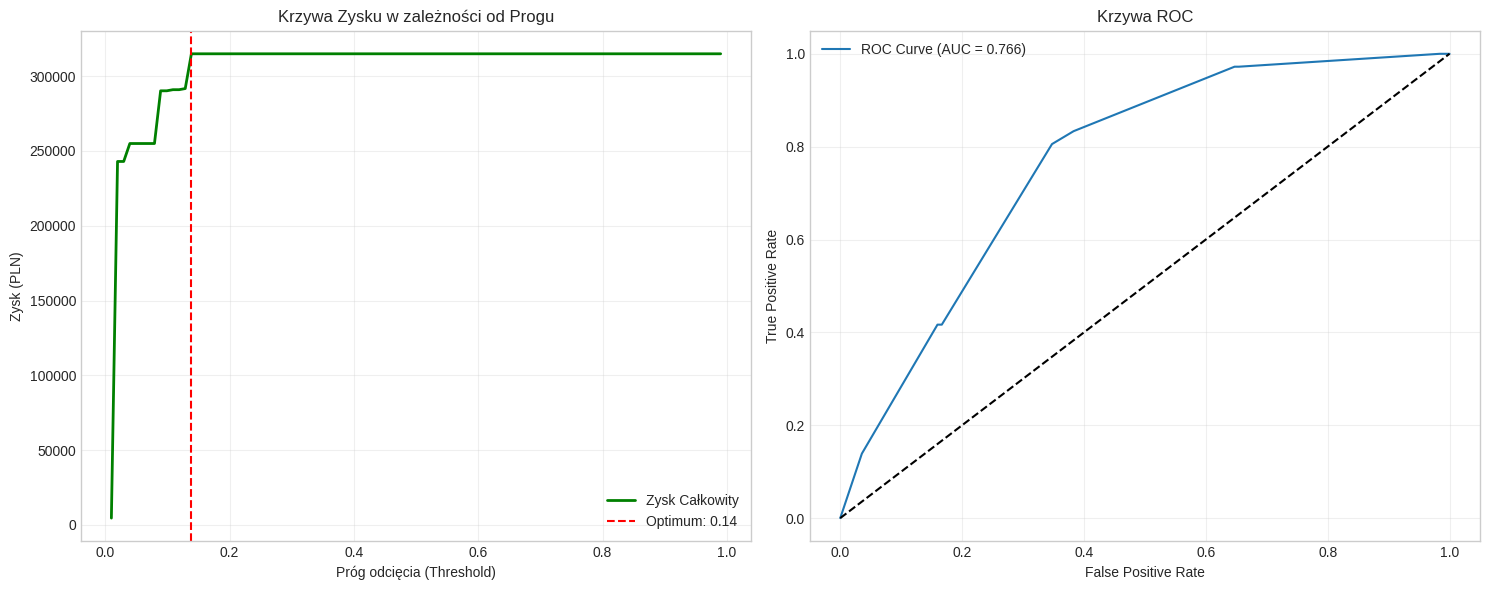

In [ ]:
LOAN_AMOUNT = 5000      # Średnia kwota pożyczki (PLN)
INTEREST_RATE = 0.15    # Oprocentowanie (Zysk z dobrego klienta)
LGD = 0.60              # Loss Given Default (Strata z niespłaconego kredytu)

PROFIT_TN = LOAN_AMOUNT * INTEREST_RATE  # Zysk z dobrego klienta (True Negative)
LOSS_FN = LOAN_AMOUNT * LGD              # Strata na złym kliencie (False Negative)
COST_FP = LOAN_AMOUNT * INTEREST_RATE    # Utracony zysk (False Positive) - Opportunity Cost
BENEFIT_TP = 0                           # Uniknięta strata (True Positive) - Zysk 0, ale brak straty

print("--- Parametry Biznesowe ---")
print(f"Kwota pożyczki: {LOAN_AMOUNT} PLN")
print(f"Zysk z dobrego klienta (TN): +{PROFIT_TN:.2f} PLN")
print(f"Strata na złym kliencie (FN): -{LOSS_FN:.2f} PLN")
print(f"Utracony zysk (FP): -{COST_FP:.2f} PLN")

def calculate_total_profit(y_true, y_pred_proba, threshold):   
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    total_profit = (tn * PROFIT_TN) - (fn * LOSS_FN)
    return total_profit, tn, fp, fn, tp

thresholds = np.linspace(0.01, 0.99, 100)
profits = []
metrics = []

for thresh in thresholds:
    profit, tn, fp, fn, tp = calculate_total_profit(y_true, y_pred_cal, thresh)
    profits.append(profit)
    metrics.append((tn, fp, fn, tp))

profits = np.array(profits)
best_idx = np.argmax(profits)
best_threshold = thresholds[best_idx]
max_profit = profits[best_idx]

print(f"\n--- Wyniki Optymalizacji ---")
print(f"Optymalny próg odcięcia (Cut-off): {best_threshold:.4f}")
print(f"Maksymalny zysk całkowity: {max_profit:,.2f} PLN")
print(f"Średni zysk na wniosek: {max_profit/len(y_true):.2f} PLN")

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(thresholds, profits, label='Zysk Całkowity', color='green', linewidth=2)
ax[0].axvline(best_threshold, color='red', linestyle='--', label=f'Optimum: {best_threshold:.2f}')
ax[0].set_title('Krzywa Zysku w zależności od Progu')
ax[0].set_xlabel('Próg odcięcia (Threshold)')
ax[0].set_ylabel('Zysk (PLN)')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

fpr, tpr, _ = roc_curve(y_true, y_pred_cal)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_title('Krzywa ROC')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5.2. Mapowanie PD na klasy ratingowe

Uwaga: pd.qcut napotkał problem z unikalnością binów. Używam rankingu.
--- Tabela Ratingowa (Mapowanie PD na Klasy) ---
  Rating  Count  Min_PD  Max_PD  Mean_PD  Observed_DR  Share
0      A     75    0.00    1.74     1.59         0.00   0.12
1      B     75    1.74    1.74     1.74         0.00   0.12
2      C     75    1.74    1.94     1.81         2.67   0.12
3      D     75    1.94    1.94     1.94         2.67   0.12
4      E     75    1.94    3.33     2.33         4.00   0.12
5      F     75    8.27    8.27     8.27        10.67   0.12
6      G     75    8.27   13.64    10.56        13.33   0.12
7      H     75   13.64   25.00    17.42        14.67   0.12


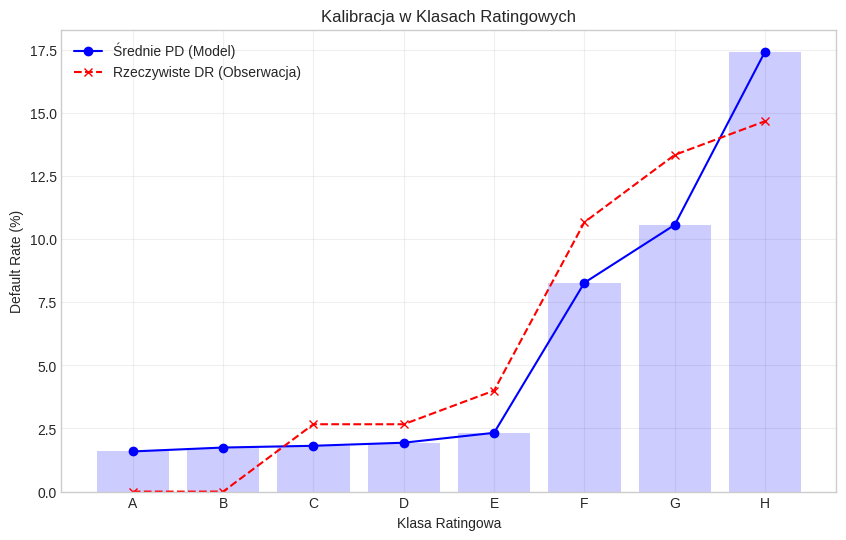

In [ ]:
df_results = pd.DataFrame({
    'y_true': y_true,
    'PD': y_pred_cal
})

n_classes = 8
labels = [chr(65+i) for i in range(n_classes)] # A, B, C, ...

try:
    df_results['Rating'] = pd.qcut(df_results['PD'], q=n_classes, labels=labels)
except ValueError:
    print("Uwaga: pd.qcut napotkał problem z unikalnością binów. Używam rankingu.")
    df_results['Rating'] = pd.qcut(df_results['PD'].rank(method='first'), q=n_classes, labels=labels)

rating_stats = df_results.groupby('Rating', observed=False).agg(
    Count=('y_true', 'count'),
    Min_PD=('PD', 'min'),
    Max_PD=('PD', 'max'),
    Mean_PD=('PD', 'mean'),
    Observed_DR=('y_true', 'mean')
).reset_index()

rating_stats['Share'] = rating_stats['Count'] / len(df_results)
rating_stats['Mean_PD'] = rating_stats['Mean_PD'] * 100
rating_stats['Observed_DR'] = rating_stats['Observed_DR'] * 100
rating_stats['Min_PD'] = rating_stats['Min_PD'] * 100
rating_stats['Max_PD'] = rating_stats['Max_PD'] * 100

print("--- Tabela Ratingowa (Mapowanie PD na Klasy) ---")
print(rating_stats.to_string(float_format="%.2f"))

plt.figure(figsize=(10, 6))
plt.plot(rating_stats['Rating'], rating_stats['Mean_PD'], marker='o', label='Średnie PD (Model)', color='blue')
plt.plot(rating_stats['Rating'], rating_stats['Observed_DR'], marker='x', label='Rzeczywiste DR (Obserwacja)', color='red', linestyle='--')
plt.bar(rating_stats['Rating'], rating_stats['Mean_PD'], alpha=0.2, color='blue')
plt.title('Kalibracja w Klasach Ratingowych')
plt.xlabel('Klasa Ratingowa')
plt.ylabel('Default Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

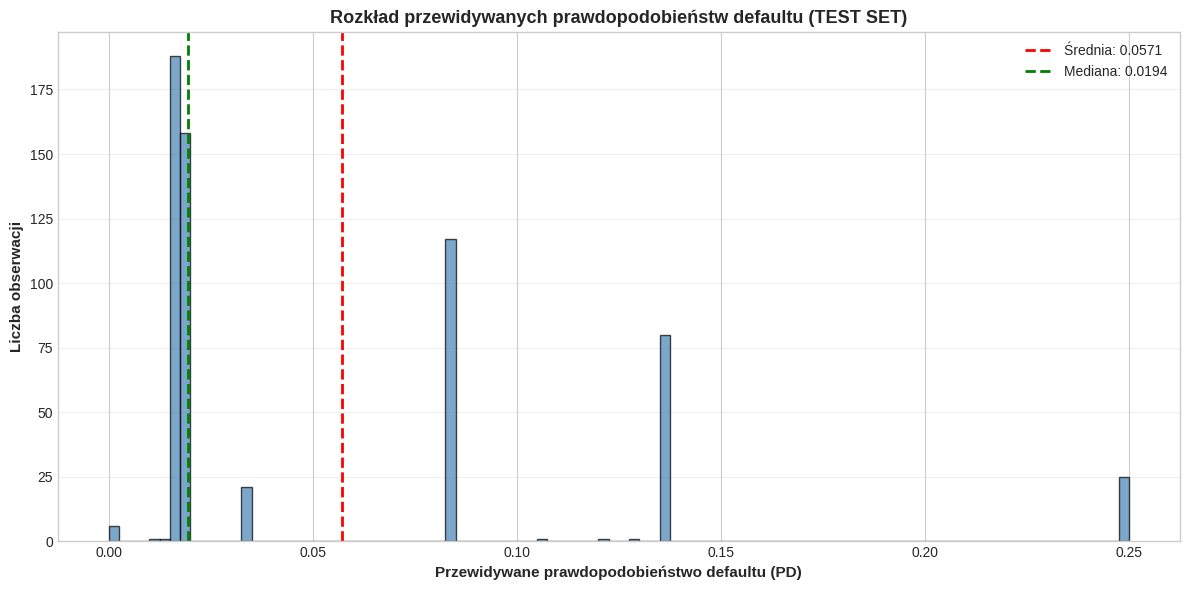


Statystyki rozkładu przewidywanych prawdopodobieństw (TEST SET):
  Liczba obserwacji: 600
  Średnia: 0.057084
  Mediana: 0.019355
  Odchylenie standardowe: 0.058848
  Min: 0.000000
  Max: 0.250000
  Q1 (25%): 0.017442
  Q3 (75%): 0.082707

Wykres zapisany: predicted_probabilities_histogram_test.png


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(y_pred_cal, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Przewidywane prawdopodobieństwo defaultu (PD)', fontsize=11, fontweight='bold')
ax.set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
ax.set_title('Rozkład przewidywanych prawdopodobieństw defaultu (TEST SET)', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.axvline(y_pred_cal.mean(), color='red', linestyle='--', linewidth=2, label=f'Średnia: {y_pred_cal.mean():.4f}')
ax.axvline(np.median(y_pred_cal), color='green', linestyle='--', linewidth=2, label=f'Mediana: {np.median(y_pred_cal):.4f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('predicted_probabilities_histogram_test.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nStatystyki rozkładu przewidywanych prawdopodobieństw (TEST SET):")
print(f"  Liczba obserwacji: {len(y_pred_cal)}")
print(f"  Średnia: {y_pred_cal.mean():.6f}")
print(f"  Mediana: {np.median(y_pred_cal):.6f}")
print(f"  Odchylenie standardowe: {y_pred_cal.std():.6f}")
print(f"  Min: {y_pred_cal.min():.6f}")
print(f"  Max: {y_pred_cal.max():.6f}")
print(f"  Q1 (25%): {np.percentile(y_pred_cal, 25):.6f}")
print(f"  Q3 (75%): {np.percentile(y_pred_cal, 75):.6f}")
print(f"\nWykres zapisany: predicted_probabilities_histogram_test.png")
print("="*80)

In [ ]:
def find_optimal_rating_boundaries(y_true, y_pred_proba, n_classes=7, 
                                   max_dr_best=0.001, min_dr_worst=0.95, 
                                   min_class_size=0.01):
    sorted_indices = np.argsort(y_pred_proba)
    y_true_sorted = y_true[sorted_indices]
    y_pred_sorted = y_pred_proba[sorted_indices]
    
    n_obs = len(y_true)
    min_obs_per_class = int(n_obs * min_class_size)
    
    boundaries = [0]
    
    idx = min_obs_per_class
    while idx < n_obs:
        class_dr = y_true_sorted[:idx].mean()
        if class_dr >= max_dr_best:
            idx = max(min_obs_per_class, idx - 1)
            break
        idx += 1
    boundaries.append(idx)
    
    remaining_obs = n_obs - boundaries[-1]
    remaining_classes = n_classes - 1
    
    for i in range(1, remaining_classes):
        class_size = remaining_obs // remaining_classes
        next_boundary = boundaries[-1] + class_size
        boundaries.append(min(next_boundary, n_obs))
    
    boundaries.append(n_obs)
    
    pd_boundaries = [y_pred_sorted[min(idx, n_obs-1)] for idx in boundaries]
    
    return pd_boundaries, sorted_indices, y_true_sorted, y_pred_sorted

pd_boundaries, sorted_indices, y_true_sorted, y_pred_sorted = find_optimal_rating_boundaries(
    y_true, y_pred_cal, n_classes=n_classes
)

def assign_rating_class(y_pred_proba, boundaries):
    ratings = np.zeros(len(y_pred_proba), dtype=int)
    for i, pd_val in enumerate(y_pred_proba):
        assigned = False
        for class_idx in range(len(boundaries) - 1):
            if class_idx == len(boundaries) - 2:
                 if boundaries[class_idx] <= pd_val <= boundaries[class_idx + 1]:
                    ratings[i] = class_idx
                    assigned = True
                    break
            else:
                if boundaries[class_idx] <= pd_val < boundaries[class_idx + 1]:
                    ratings[i] = class_idx
                    assigned = True
                    break
        if not assigned:
            if pd_val < boundaries[0]:
                ratings[i] = 0
            else:
                ratings[i] = len(boundaries) - 2
                
    return ratings

ratings = assign_rating_class(y_pred_cal, pd_boundaries)
print("Optymalne granice ratingowe wyznaczone i ratingi przypisane.")

Optymalne granice ratingowe wyznaczone i ratingi przypisane.


In [ ]:
rating_analysis = []

for class_idx in range(n_classes):
    mask = ratings == class_idx
    n_obs = mask.sum()
    pct_population = n_obs / len(y_true) * 100
    
    if n_obs > 0:
        avg_pd = y_pred_cal[mask].mean()
        median_pd = np.median(y_pred_cal[mask])
        std_pd = y_pred_cal[mask].std()
        actual_dr = y_true[mask].mean()
        n_defaults = y_true[mask].sum()
        
        rating_analysis.append({
            'Rating': labels[class_idx],
            'PD_Min': pd_boundaries[class_idx],
            'PD_Max': pd_boundaries[class_idx + 1],
            'N_Obs': n_obs,
            'Pct_Pop': pct_population,
            'Avg_PD': avg_pd,
            'Median_PD': median_pd,
            'Std_PD': std_pd,
            'Actual_DR': actual_dr,
            'N_Defaults': int(n_defaults)
        })
    else:
         rating_analysis.append({
            'Rating': labels[class_idx],
            'PD_Min': pd_boundaries[class_idx],
            'PD_Max': pd_boundaries[class_idx + 1],
            'N_Obs': 0,
            'Pct_Pop': 0.0,
            'Avg_PD': 0.0,
            'Median_PD': 0.0,
            'Std_PD': 0.0,
            'Actual_DR': 0.0,
            'N_Defaults': 0
        })

rating_df = pd.DataFrame(rating_analysis)

print("Analiza klas ratingowych:")
print(rating_df.to_string(index=False))
print("\nWeryfikacja wymagań:")
if len(rating_df) > 0:
    print(f"  Klasa A DR: {rating_df.iloc[0]['Actual_DR']*100:.3f}%")
    print(f"  Klasa H (ostatnia) DR: {rating_df.iloc[-1]['Actual_DR']*100:.2f}%")
    dr_diffs = rating_df['Actual_DR'].diff().dropna()
    is_monotonic = all(dr_diffs >= 0) # Powinno być >= 0, idealnie > 0
    print(f"  Monotoniczność DR: {is_monotonic}")
    print(f"  Min. obs. w klasie: {rating_df['N_Obs'].min()}")
print("="*80)

Analiza klas ratingowych:
Rating   PD_Min   PD_Max  N_Obs   Pct_Pop   Avg_PD  Median_PD   Std_PD  Actual_DR  N_Defaults
     A 0.000000 0.017442      9  1.500000 0.004583   0.000000 0.006677   0.000000           0
     B 0.017442 0.017442      0  0.000000 0.000000   0.000000 0.000000   0.000000           0
     C 0.017442 0.019355    191 31.833333 0.017464   0.017442 0.000157   0.005236           1
     D 0.019355 0.019355      0  0.000000 0.000000   0.000000 0.000000   0.000000           0
     E 0.019355 0.082707    175 29.166667 0.021032   0.019355 0.004542   0.034286           6
     F 0.082707 0.082707      0  0.000000 0.000000   0.000000 0.000000   0.000000           0
     G 0.082707 0.136364    120 20.000000 0.083614   0.082707 0.005830   0.116667          14
     H 0.136364 0.250000    105 17.500000 0.163420   0.136364 0.048400   0.142857          15

Weryfikacja wymagań:
  Klasa A DR: 0.000%
  Klasa H (ostatnia) DR: 14.29%
  Monotoniczność DR: False
  Min. obs. w klasie: 0


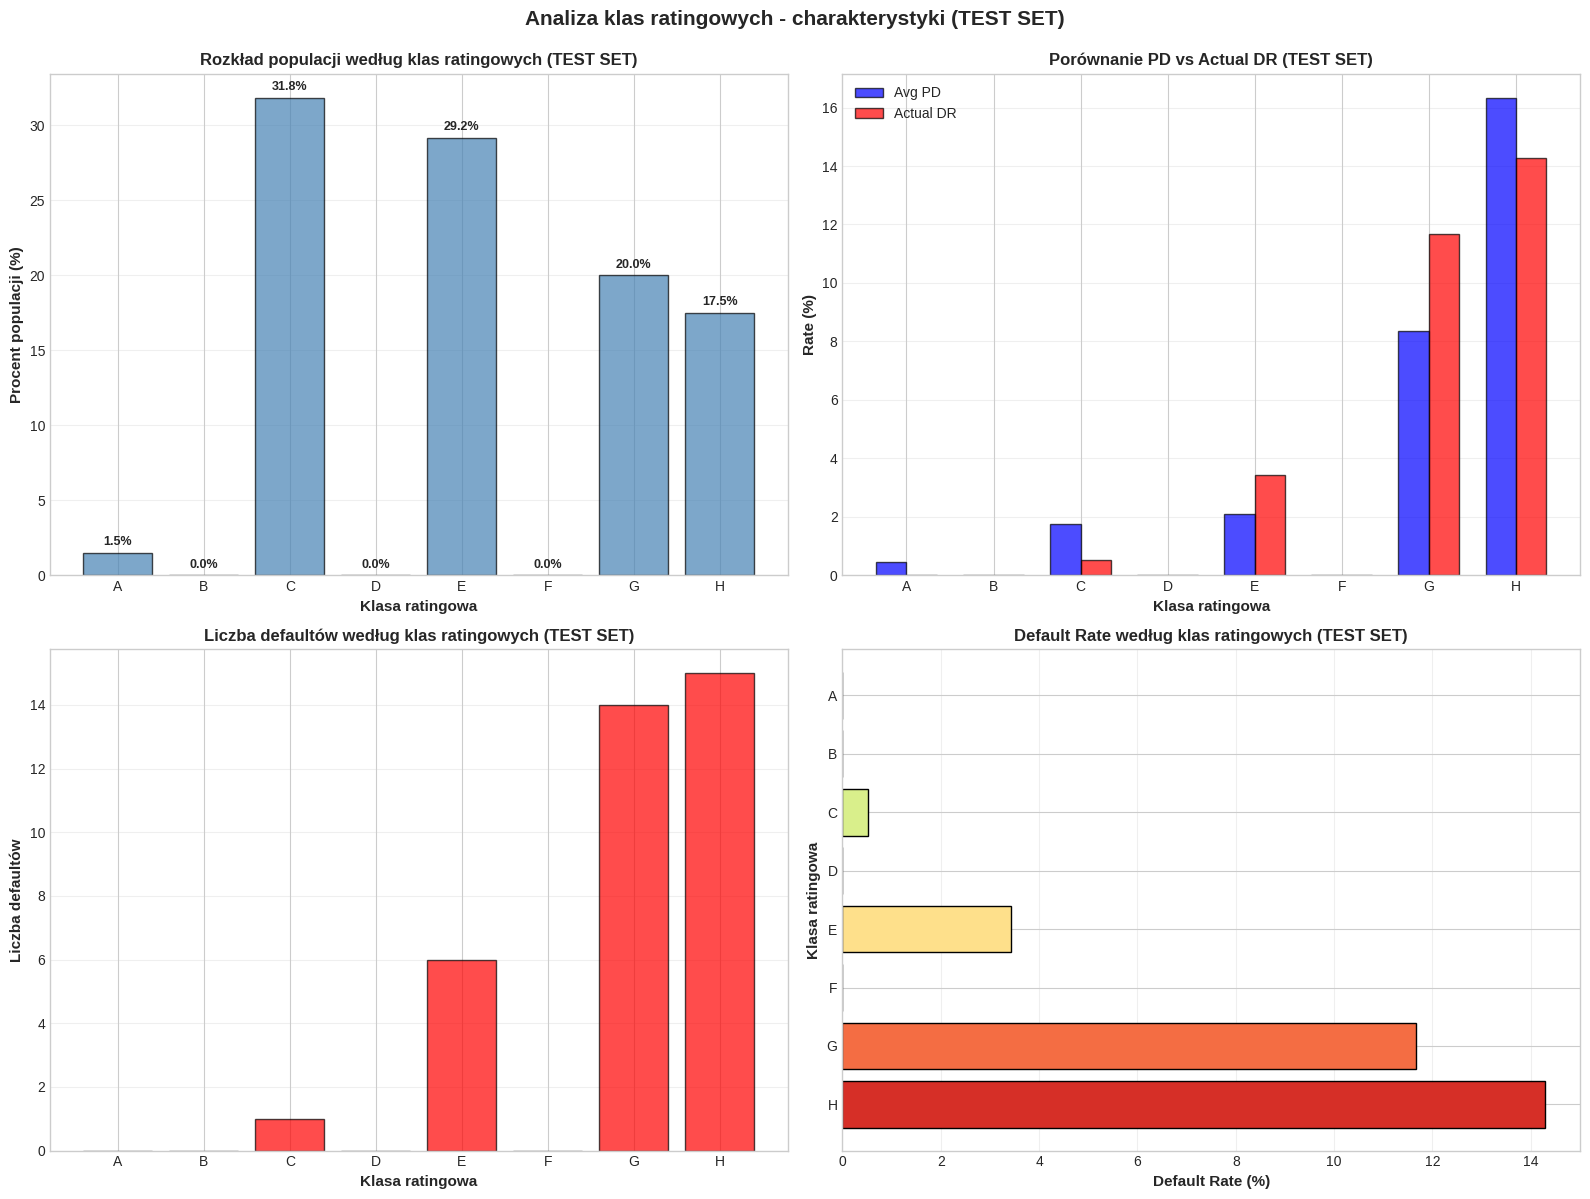

Wykres zapisany: rating_classes_analysis_test.png


In [78]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(rating_df['Rating'], rating_df['Pct_Pop'], color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Procent populacji (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Rozkład populacji według klas ratingowych (TEST SET)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')
for i, (rating, pct) in enumerate(zip(rating_df['Rating'], rating_df['Pct_Pop'])):
    axes[0, 0].text(i, pct + 0.5, f'{pct:.1f}%', ha='center', fontsize=9, fontweight='bold')

x_pos = np.arange(len(rating_df))
width = 0.35
axes[0, 1].bar(x_pos - width/2, rating_df['Avg_PD']*100, width, label='Avg PD', 
               color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].bar(x_pos + width/2, rating_df['Actual_DR']*100, width, label='Actual DR', 
               color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Rate (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Porównanie PD vs Actual DR (TEST SET)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(rating_df['Rating'])
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

axes[1, 0].bar(rating_df['Rating'], rating_df['N_Defaults'], color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Liczba defaultów', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Liczba defaultów według klas ratingowych (TEST SET)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

colors_map = plt.cm.RdYlGn_r(np.linspace(0.2, 0.9, len(rating_df)))
axes[1, 1].barh(rating_df['Rating'], rating_df['Actual_DR']*100, color=colors_map, edgecolor='black')
axes[1, 1].set_xlabel('Default Rate (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Default Rate według klas ratingowych (TEST SET)', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.suptitle('Analiza klas ratingowych - charakterystyki (TEST SET)', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Wykres zapisany: rating_classes_analysis_test.png")
print("="*80)

## 5.3. Tabele decyzyjne i wpływ progu na wyniki biznesowe

--- Tabela Decyzyjna: Porównanie Scenariuszy ---
        Scenariusz Próg (Threshold) Approval Rate Bad Rate (Accepted) Recall (Defaults Caught) Total Profit (PLN) Profit per App (PLN)
     Konserwatywny            5.00%        62.50%               1.87%                   80.56%            255,000               425.00
      Zrównoważony           10.00%        82.00%               4.27%                   41.67%            290,250               483.75
         Agresywny           20.00%        95.83%               5.39%                   13.89%            315,000               525.00
Optymalny (Profit)           13.87%        95.83%               5.39%                   13.89%            315,000               525.00


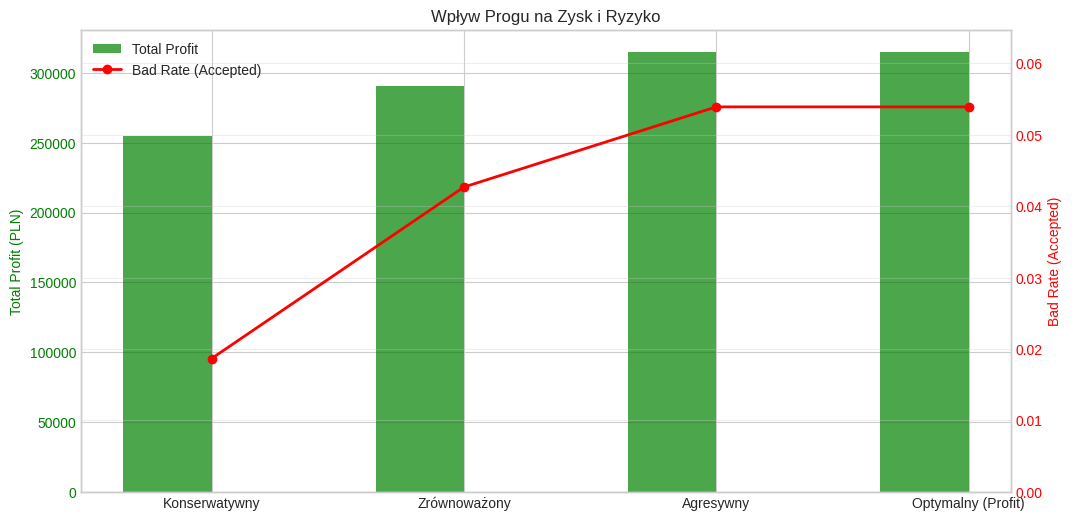

In [ ]:
scenarios = [
    {'name': 'Konserwatywny', 'threshold': 0.05},
    {'name': 'Zrównoważony', 'threshold': 0.10},
    {'name': 'Agresywny', 'threshold': 0.20},
    {'name': 'Optymalny (Profit)', 'threshold': best_threshold}
]

results_scenarios = []

for scen in scenarios:
    thresh = scen['threshold']
    profit, tn, fp, fn, tp = calculate_total_profit(y_true, y_pred_cal, thresh)
    
    total = len(y_true)
    accepted = tn + fn
    rejected = tp + fp
    approval_rate = accepted / total
    bad_rate_accepted = fn / accepted if accepted > 0 else 0
    recall_defaults = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    results_scenarios.append({
        'Scenariusz': scen['name'],
        'Próg (Threshold)': thresh,
        'Approval Rate': approval_rate,
        'Bad Rate (Accepted)': bad_rate_accepted,
        'Recall (Defaults Caught)': recall_defaults,
        'Total Profit (PLN)': profit,
        'Profit per App (PLN)': profit / total
    })

df_scenarios = pd.DataFrame(results_scenarios)

df_display = df_scenarios.copy()
df_display['Próg (Threshold)'] = df_display['Próg (Threshold)'].map('{:.2%}'.format)
df_display['Approval Rate'] = df_display['Approval Rate'].map('{:.2%}'.format)
df_display['Bad Rate (Accepted)'] = df_display['Bad Rate (Accepted)'].map('{:.2%}'.format)
df_display['Recall (Defaults Caught)'] = df_display['Recall (Defaults Caught)'].map('{:.2%}'.format)
df_display['Total Profit (PLN)'] = df_display['Total Profit (PLN)'].map('{:,.0f}'.format)
df_display['Profit per App (PLN)'] = df_display['Profit per App (PLN)'].map('{:.2f}'.format)

print("--- Tabela Decyzyjna: Porównanie Scenariuszy ---")
print(df_display.to_string(index=False))

fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_scenarios))
width = 0.35

ax1.bar(x - width/2, df_scenarios['Total Profit (PLN)'], width, label='Total Profit', color='green', alpha=0.7)
ax1.set_ylabel('Total Profit (PLN)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticks(x)
ax1.set_xticklabels(df_scenarios['Scenariusz'])
ax1.set_title('Wpływ Progu na Zysk i Ryzyko')

ax2 = ax1.twinx()
ax2.plot(x, df_scenarios['Bad Rate (Accepted)'], marker='o', color='red', label='Bad Rate (Accepted)', linewidth=2)
ax2.set_ylabel('Bad Rate (Accepted)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(df_scenarios['Bad Rate (Accepted)']) * 1.2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, alpha=0.3)
plt.show()

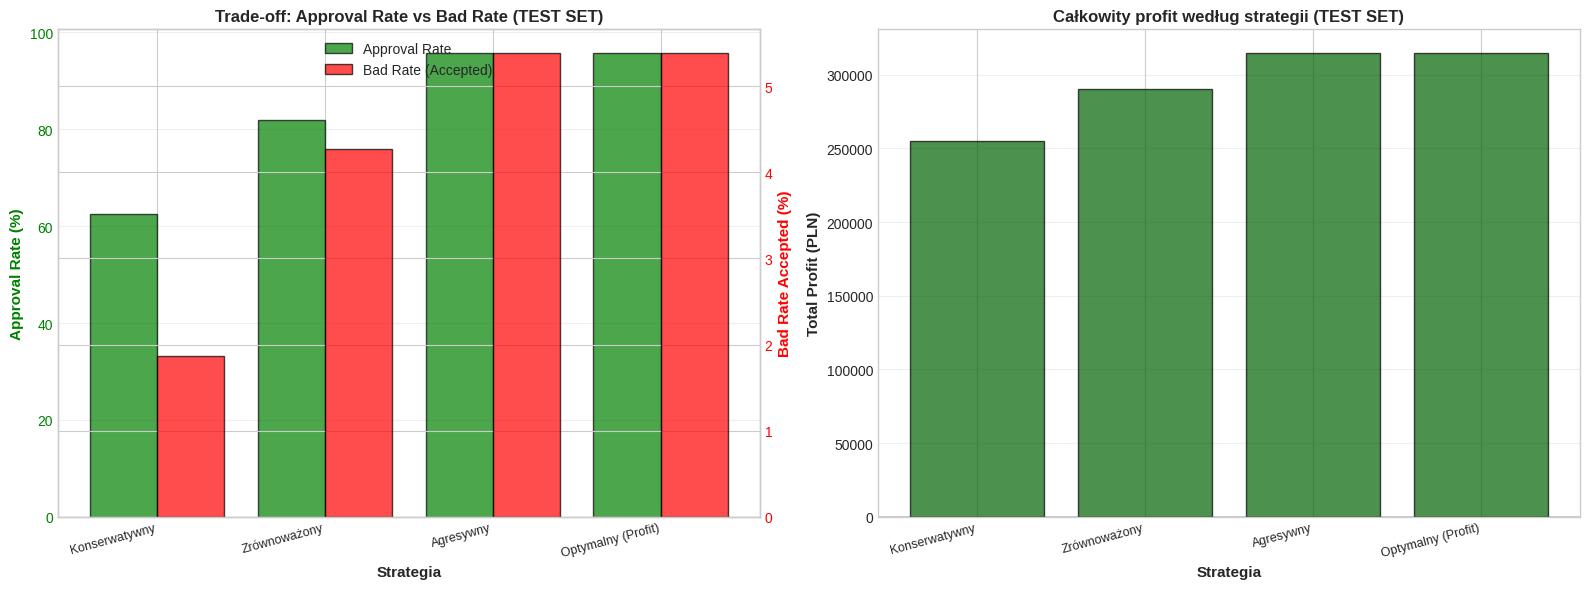

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

strategies = df_scenarios['Scenariusz'].values
x_pos = np.arange(len(strategies))

# Wykres 1: Approval Rate vs Bad Rate
ax1 = axes[0]
ax1_twin = ax1.twinx()

df_plot = pd.DataFrame(results_scenarios)

bars1 = ax1.bar(x_pos - 0.2, df_plot['Approval Rate'] * 100, 0.4, label='Approval Rate', 
                color='green', alpha=0.7, edgecolor='black')
bars2 = ax1_twin.bar(x_pos + 0.2, df_plot['Bad Rate (Accepted)'] * 100, 0.4, label='Bad Rate (Accepted)', 
                     color='red', alpha=0.7, edgecolor='black')

ax1.set_xlabel('Strategia', fontsize=11, fontweight='bold')
ax1.set_ylabel('Approval Rate (%)', fontsize=11, fontweight='bold', color='green')
ax1_twin.set_ylabel('Bad Rate Accepted (%)', fontsize=11, fontweight='bold', color='red')
ax1.set_title('Trade-off: Approval Rate vs Bad Rate (TEST SET)', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
ax1.tick_params(axis='y', labelcolor='green')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1.grid(alpha=0.3, axis='y')

# Legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

# Wykres 2: Total Profit
axes[1].bar(x_pos, df_plot['Total Profit (PLN)'], color='darkgreen', alpha=0.7, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Strategia', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Total Profit (PLN)', fontsize=11, fontweight='bold')
axes[1].set_title('Całkowity profit według strategii (TEST SET)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [81]:
print("="*80)
print("TABELA DECYZYJNA - REKOMENDACJE AKCJI")
print("="*80)

decision_table = []

for _, row in rating_df.iterrows():
    rating = row['Rating']
    avg_pd = row['Avg_PD']
    actual_dr = row['Actual_DR']
    
    if rating in ['A', 'B']:
        action = 'AUTO-ACCEPT'
        terms = 'Standard terms'
        monitoring = 'Standard'
    elif rating in ['C', 'D']:
        action = 'ACCEPT'
        terms = 'Standard terms, możliwe wyższe oprocentowanie'
        monitoring = 'Enhanced'
    elif rating == 'E':
        action = 'MANUAL REVIEW'
        terms = 'Higher interest rate lub collateral'
        monitoring = 'Enhanced'
    elif rating == 'F':
        action = 'REJECT lub MANUAL'
        terms = 'Very high interest + collateral required'
        monitoring = 'Intensive'
    else:
        action = 'AUTO-REJECT'
        terms = 'N/A'
        monitoring = 'N/A'
    
    decision_table.append({
        'Rating': rating,
        'Avg_PD': f'{avg_pd*100:.2f}%',
        'Actual_DR': f'{actual_dr*100:.2f}%',
        'Action': action,
        'Terms': terms,
        'Monitoring': monitoring
    })

decision_df = pd.DataFrame(decision_table)
print(decision_df.to_string(index=False))

print("\n\nLegenda:")
print("  AUTO-ACCEPT: Automatyczna akceptacja bez przeglądu manualnego")
print("  ACCEPT: Akceptacja z możliwością dodatkowych warunków")
print("  MANUAL REVIEW: Wymagany przegląd manualny przez analityka")
print("  REJECT: Odrzucenie z możliwością manual review w wyjątkowych przypadkach")
print("  AUTO-REJECT: Automatyczne odrzucenie")
print("="*80)

TABELA DECYZYJNA - REKOMENDACJE AKCJI
Rating Avg_PD Actual_DR            Action                                         Terms Monitoring
     A  0.46%     0.00%       AUTO-ACCEPT                                Standard terms   Standard
     B  0.00%     0.00%       AUTO-ACCEPT                                Standard terms   Standard
     C  1.75%     0.52%            ACCEPT Standard terms, możliwe wyższe oprocentowanie   Enhanced
     D  0.00%     0.00%            ACCEPT Standard terms, możliwe wyższe oprocentowanie   Enhanced
     E  2.10%     3.43%     MANUAL REVIEW           Higher interest rate lub collateral   Enhanced
     F  0.00%     0.00% REJECT lub MANUAL      Very high interest + collateral required  Intensive
     G  8.36%    11.67%       AUTO-REJECT                                           N/A        N/A
     H 16.34%    14.29%       AUTO-REJECT                                           N/A        N/A


Legenda:
  AUTO-ACCEPT: Automatyczna akceptacja bez przeglądu manualn

In [ ]:
print("="*80)
print("PODSUMOWANIE - PROGI DECYZJI I RATINGI (TEST SET)")
print("="*80)

print(f"\nOptymalizacja progów (TEST SET):")
print(f"  Prog maksymalizujący profit: {best_threshold:.4f}")
print(f"  Maksymalny profit: {max_profit:.2f}")
print(f"  ROC AUC: {roc_auc:.4f}")

from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(y_true, y_pred_cal)
pr_auc = auc(recall, precision)
print(f"  PR AUC: {pr_auc:.4f}")

print(f"\nKlasy ratingowe (TEST SET):")
print(f"  Liczba klas: {n_classes}")
print(f"  Zakres PD: [{pd_boundaries[0]:.6f}, {pd_boundaries[-1]:.6f}]")
if len(rating_df) > 0:
    print(f"  Klasa najlepsza (A): DR = {rating_df.iloc[0]['Actual_DR']*100:.3f}%")
    print(f"  Klasa najgorsza (H): DR = {rating_df.iloc[-1]['Actual_DR']*100:.2f}%")
    
    dr_diffs = rating_df['Actual_DR'].diff().dropna()
    is_monotonic = all(dr_diffs >= 0)
    print(f"  Monotoniczność: {'Zachowana' if is_monotonic else 'Naruszona'}")

print(f"\nRekomendowana strategia biznesowa (TEST SET):")

if df_scenarios['Total Profit (PLN)'].dtype == 'object':
    best_strategy_idx = df_scenarios['Total Profit (PLN)'].str.replace(',', '').astype(float).idxmax()
else:
    best_strategy_idx = df_scenarios['Total Profit (PLN)'].idxmax()

best_strategy = df_scenarios.iloc[best_strategy_idx]

print(f"  Strategia: {best_strategy['Scenariusz']}")

def format_val(val, fmt):
    if isinstance(val, str): return val
    return fmt.format(val)

print(f"  Prog: {format_val(best_strategy['Próg (Threshold)'], '{:.2%}')}")
print(f"  Approval Rate: {format_val(best_strategy['Approval Rate'], '{:.2%}')}")
print(f"  DR wśród zaakceptowanych: {format_val(best_strategy['Bad Rate (Accepted)'], '{:.2%}')}")
print(f"  Profit per aplikacja: {format_val(best_strategy['Profit per App (PLN)'], '{:.2f}')}")
print(f"  Total Profit: {format_val(best_strategy['Total Profit (PLN)'], '{:,.2f}')}")

print("\nZapisane pliki:")
print("="*80)

PODSUMOWANIE - PROGI DECYZJI I RATINGI (TEST SET)

Optymalizacja progów (TEST SET):
  Prog maksymalizujący profit: 0.1387
  Maksymalny profit: 315000.00
  ROC AUC: 0.7660
  PR AUC: 0.2029

Klasy ratingowe (TEST SET):
  Liczba klas: 8
  Zakres PD: [0.000000, 0.250000]
  Klasa najlepsza (A): DR = 0.000%
  Klasa najgorsza (H): DR = 14.29%
  Monotoniczność: Naruszona

Rekomendowana strategia biznesowa (TEST SET):
  Strategia: Agresywny
  Prog: 20.00%
  Approval Rate: 95.83%
  DR wśród zaakceptowanych: 5.39%
  Profit per aplikacja: 525.00
  Total Profit: 315,000.00

Zapisane pliki:
